In [1]:
import os
import json
import argparse
import torch
import random
import numpy as np
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from dataloader.dataloader import CreateLoaders
import pkbar
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from models.freia_models import create_freai
from dataloader.create_data import return_data,create_dataset
from mmd_loss import MMD
import pandas as pd
import time

C:\Users\James-PC\miniconda3\envs\ptorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = json.load(open(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\config\default_config.json"))
config

{'name': 'IBU2_KinematicConds_Unfold',
 'seed': 752022,
 'run_val': 1,
 'scalers': {'MLP': 'none', 'MNF': 'none'},
 'model': {'blocks': [64, 128, 512, 1024, 512, 128, 64, 3],
  'num_layers': 8,
  'identity_path': 'C:\\Users\\James-PC\\James\\EIC\\IBU2Q-main\\IBU2Q-main\\Trained_Models\\IBU2_KinematicConds_Identity___Feb-18-2024\\IBU2_KinematicConds_Identity_epoch51_val_loss_0.000001.pth'},
 'dataset': {'root_dir': 'C:\\Users\\James-PC\\James\\EIC\\IBU2Q-main\\IBU2Q-main',
  'N_t': 1000000,
  'N_v': 600000},
 'lr_scheduler': {'step_size': 25, 'gamma': 0.1},
 'optimizer': {'lr': 0.0004,
  'KL_scale': 0.0005,
  'cost_scale': 0.0001,
  'mmd_scale': 1.2},
 'num_epochs': 100,
 'dataloader': {'split': [0.7, 0.15, 0.15],
  'train': {'batch_size': 1024},
  'val': {'batch_size': 1024},
  'herwig': {'batch_size': 75}},
 'output': {'dir': 'C:\\Users\\James-PC\\James\\EIC\\IBU2Q-main\\IBU2Q-main\\Trained_Models'},
 'Inference': {'samples': 10000,
  'MNF_model': 'C:\\Users\\James-PC\\James\\EIC\\IBU

In [3]:
# Setup random seed
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
random.seed(config['seed'])
torch.cuda.manual_seed(config['seed'])

# Create experiment name
curr_date = datetime.now()
exp_name = config['name'] + '___' + curr_date.strftime('%b-%d-%Y___%H:%M:%S')
exp_name = exp_name[:-11]
print(exp_name)

# Create directory structure
output_folder = config['Inference']['out_dir']


# Load the dataset
print('Creating Loaders.')
N_t= config['dataset']['N_t']
N_v = config['dataset']['N_v']
augment = False

data,scaler,kscaler = return_data(N_t=N_t,N_v=N_v,constrain=True)

sim_herwig          = data['sim_herwig'][N_t:]
gen_herwig          = data['gen_herwig'][N_t:]
scaled_sim_herwig   = data['sim_herwig'][N_t:]
sim_herwig_conds = np.c_[data['sim_herwig_conds'][:,0]][N_t:]

if augment:
    N_t = int(3*N_t)
    N_v = int(3*N_v)

gen_features        = data['gen_features']
sim_features        = data['sim_features']

train_gen_features = gen_features[:N_t]
train_sim_features = sim_features[:N_t]

val_gen_features = gen_features[N_t:]
val_sim_features = sim_features[N_t:]

scaled_gen_features = data['gen_features']
scaled_sim_features = data['sim_features']
scaled_sim_conds = np.c_[data['sim_conds'][:,0]]

train_gen = scaled_gen_features[:N_t]
train_sim = scaled_sim_features[:N_t]
train_sim_conds = scaled_sim_conds[:N_t]

val_gen = scaled_gen_features[N_t:]
val_sim = scaled_sim_features[N_t:]
val_sim_conds = scaled_sim_conds[N_t:]

train_dataset = TensorDataset(torch.tensor(train_sim),torch.tensor(train_gen),torch.tensor(train_sim_conds))
val_dataset = TensorDataset(torch.tensor(val_sim),torch.tensor(val_gen),torch.tensor(val_sim_conds))

train_loader,val_loader = CreateLoaders(train_dataset,val_dataset,config)

history = {'train_loss':[],'val_loss':[],'lr':[]}

print("Training Size: {0}".format(len(train_dataset)))
print("Validation Size: {0}".format(len(val_dataset)))

herwig_data = TensorDataset(torch.tensor(scaled_sim_herwig),torch.tensor(gen_herwig),torch.tensor(sim_herwig_conds))
herwig_loader = DataLoader(herwig_data,batch_size=config['dataloader']['herwig']['batch_size'],shuffle=False)

IBU2_KinematicConds_Unfold___Feb-19-2024
Creating Loaders.
Applying cuts on Gen. and Sim. for Pythia26
Cutting negative masses from Herwig generations.
Constraining Herwig simulation to domain of Pythia.
(1553009, 3)
Training Size: 1000000
Validation Size: 553009


In [30]:
gen_features[0].round(1)

array([28.1, 37. ,  0.1,  1. ,  0.1, -7.5])

In [21]:
a = gen_features[0] == gen_features[0]

In [35]:
potential_match = np.unique(np.where(gen_features[0] == gen_features)[0])
ids = []
for idx in potential_match:
    eq = gen_features[0].round(1) == gen_features[idx].round(1)
    if eq.sum() > 4:
        ids.append(idx)

In [37]:
gen_features[0]

array([28.10535812, 37.        ,  0.07036012,  1.01042995,  0.13117749,
       -7.45053452])

In [38]:
gen_features[ids]

array([[28.10535812, 37.        ,  0.07036012,  1.01042995,  0.13117749,
        -7.45053452],
       [20.1315155 , 37.        ,  0.05742655,  0.96927967,  0.12568559,
        -7.54398206],
       [16.23749542, 37.        ,  0.09764178,  0.9552582 ,  0.13237237,
        -7.53944206],
       [24.79861832, 37.        ,  0.09321832,  1.01744613,  0.10275404,
        -7.51972035],
       [24.51624489, 37.        ,  0.11396379,  0.97330794,  0.11199291,
        -7.52232253],
       [13.62546921, 37.        ,  0.09301847,  0.95921029,  0.1183748 ,
        -7.49858586],
       [23.5942688 , 37.        ,  0.08436943,  1.00548905,  0.14547074,
        -7.48412472],
       [21.49800491, 37.        ,  0.06814952,  0.99742643,  0.10394765,
        -7.5309027 ],
       [22.54911804, 37.        ,  0.08774292,  1.03030607,  0.11809066,
        -7.47910892],
       [15.92663479, 37.        ,  0.10398607,  1.04161778,  0.10625739,
        -7.46806301],
       [25.22737122, 37.        ,  0.11787946,  0.

In [8]:
a = pd.DataFrame(gen_features[0])

In [9]:
b = pd.DataFrame(gen_features[1:])

In [6]:

from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(gen_features[0].reshape(-1,1),gen_features[1].reshape(-1,1))

array([[ 1.,  1.,  1.,  1.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  1., -1.],
       [-1., -1., -1., -1., -1.,  1.]])

In [7]:
np.dot(gen_features[0],gen_features[1])/(np.linalg.norm(gen_features[0])*np.linalg.norm(gen_features[1]))

0.9980673716105312

In [15]:
np.sum(abs((gen_features[0] - gen_features[1])/ (gen_features[0]))) / 6

0.7612915807263313

In [9]:
gen_features[0]

array([28.10535812, 37.        ,  0.07036012,  1.01042995,  0.13117749,
       -7.45053452])

In [12]:
gen_features[1]

array([14.88274384, 22.        ,  0.20622546,  0.87954784,  0.30191109,
       -4.99334006])

In [28]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming 'data1' and 'data2' are your two datasets as NumPy arrays
# Each row represents a vector
similar_points = []
indices = []
k = 100
for i in range(1,len(gen_features)):
    ratio = (gen_features[i] - gen_features[k]) / (gen_features[k])
    if (np.sum(abs(ratio)) / 6.0 < 0.025) & (i != k):
        indices.append(i)
        #print(gen_features[i])


print(len(indices))

1


In [29]:
gen_features[k]

array([42.62858963, 37.        ,  0.1871177 ,  0.51383737,  0.11908428,
       -4.6121659 ])

In [30]:
gen_features[indices]

array([[43.93527985, 37.        ,  0.18270667,  0.48759608,  0.11910143,
        -4.51348998]])

In [31]:
sim_features[0]

array([25.65855598, 24.        ,  0.08694565,  0.99765762,  0.13740738,
       -8.4697226 ])

In [32]:
sim_features[indices]

array([[48.9439888 , 29.        ,  0.20062354,  0.65601081,  0.14335209,
        -4.3831219 ]])

In [38]:
gen_features[indices][:,idx]

array([28.1789093 , 29.39196396, 27.85181427, 32.26089859, 26.95518112,
       28.14557076, 27.39315033, 28.66802597, 27.28310585, 28.39029884,
       28.45596695, 27.94717026, 27.97639275, 26.69995689, 27.17396927,
       27.93075371, 28.05545616, 29.75693703, 29.4423008 , 29.40615845,
       30.82649803, 29.06413841, 26.18852806, 27.61112785, 27.82435799,
       28.36576843, 28.99958038, 26.91625404, 28.21469879, 26.89835548,
       30.05434799, 27.72096825, 27.47541046, 28.93200302, 27.84226608,
       30.30643845, 25.97599602, 25.67226219, 26.18000603, 28.5131855 ,
       26.36183739, 28.24028969, 28.78667259, 27.72890854, 25.44445801,
       26.80225754, 26.30176353, 25.04405212])

In [53]:
idx = 1

a = (gen_features[indices][:,idx] - gen_features[k][idx])/gen_features[k][idx]
print(abs(a)*100)

[ 0.          5.40540541  5.40540541  0.          5.40540541  2.7027027
  2.7027027   0.          2.7027027   2.7027027   8.10810811  2.7027027
  2.7027027  10.81081081  0.          2.7027027  10.81081081  2.7027027
  0.          5.40540541  0.          5.40540541  0.          2.7027027
  0.        ]


In [32]:
1 / 28

0.03571428571428571

In [29]:
gen_features[0,0]

28.105358123779297

In [22]:
gen_features[indices]

array([[28.1789093 , 35.        ,  0.07263849,  0.92231689,  0.12897309,
        -7.07508009],
       [29.39196396, 37.        ,  0.07153128,  0.93606263,  0.13562811,
        -7.10157043],
       [27.85181427, 36.        ,  0.06468726,  1.00113366,  0.1185939 ,
        -7.62127315],
       [32.26089859, 38.        ,  0.0751041 ,  1.006462  ,  0.13041117,
        -7.4797391 ],
       [26.95518112, 35.        ,  0.0708516 ,  1.02834774,  0.12782361,
        -8.54975938],
       [28.14557076, 32.        ,  0.07162507,  0.94032462,  0.12927944,
        -7.26307666],
       [27.39315033, 37.        ,  0.06565773,  0.99456921,  0.11789802,
        -8.0797004 ],
       [28.66802597, 41.        ,  0.07711438,  0.99534761,  0.13206165,
        -7.78721574],
       [27.28310585, 38.        ,  0.07063496,  0.85676077,  0.13076659,
        -8.00656663],
       [28.39029884, 34.        ,  0.07379186,  0.99774642,  0.12524803,
        -7.16329283],
       [28.45596695, 39.        ,  0.07186394,  0.

In [6]:
print("Gen Herwig Stats: ")
print(gen_herwig.max(0))
print(gen_herwig.min(0))
print(" ")
print("Gen Pythia Stats: ")
print(gen_features.max(0))
print(gen_features.min(0))
print(" ")
print("Sim Herwig Stats: ")
print(sim_herwig.max(0))
print(sim_herwig.min(0))
print(" ")
print("Sim Pythia Stats: ")
print(sim_features.max(0))
print(sim_features.min(0))

Gen Herwig Stats: 
[166.53804016 107.           0.67625917   1.55685342   0.49999918
   0.        ]
[ 3.30362468e-06  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.73288634e+01]
 
Gen Pythia Stats: 
[69.99081421 74.          0.68353397  1.55245389  0.49999946 -2.1856937 ]
[ 7.36135960e-01  2.00000000e+00  3.18249790e-03  0.00000000e+00
  1.00000092e-01 -1.49996009e+01]
 
Sim Herwig Stats: 
[99.93767548 67.          0.65396146  1.41170293  0.49999815 -2.29922126]
[ 1.42285436e-01  2.00000000e+00  1.88268723e-03  0.00000000e+00
  1.00000217e-01 -1.56284416e+01]
 
Sim Pythia Stats: 
[99.99720001 67.          0.66438817  1.55687874  0.49999938 -2.26491756]
[ 1.28449023e-01  2.00000000e+00  1.60297855e-03  0.00000000e+00
  1.00000086e-01 -1.78659089e+01]


In [6]:
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
train_gen_features = pd.DataFrame(gen_features,columns=cols)
#train_gen_features = train_gen_features[(train_gen_features.Mass < 8) | (train_gen_features.Mass > 30)]
#train_gen_features = train_gen_features[(train_gen_features.Mult < 15) | (train_gen_features.Mult > 50)]
#train_gen_features = train_gen_features[(train_gen_features.Width < 0.02) | (train_gen_features.Width > 0.2)]

array([[<AxesSubplot:title={'center':'Mass'}>,
        <AxesSubplot:title={'center':'Mult'}>],
       [<AxesSubplot:title={'center':'Width'}>,
        <AxesSubplot:title={'center':'tau21'}>],
       [<AxesSubplot:title={'center':'zg'}>,
        <AxesSubplot:title={'center':'log_rho'}>]], dtype=object)

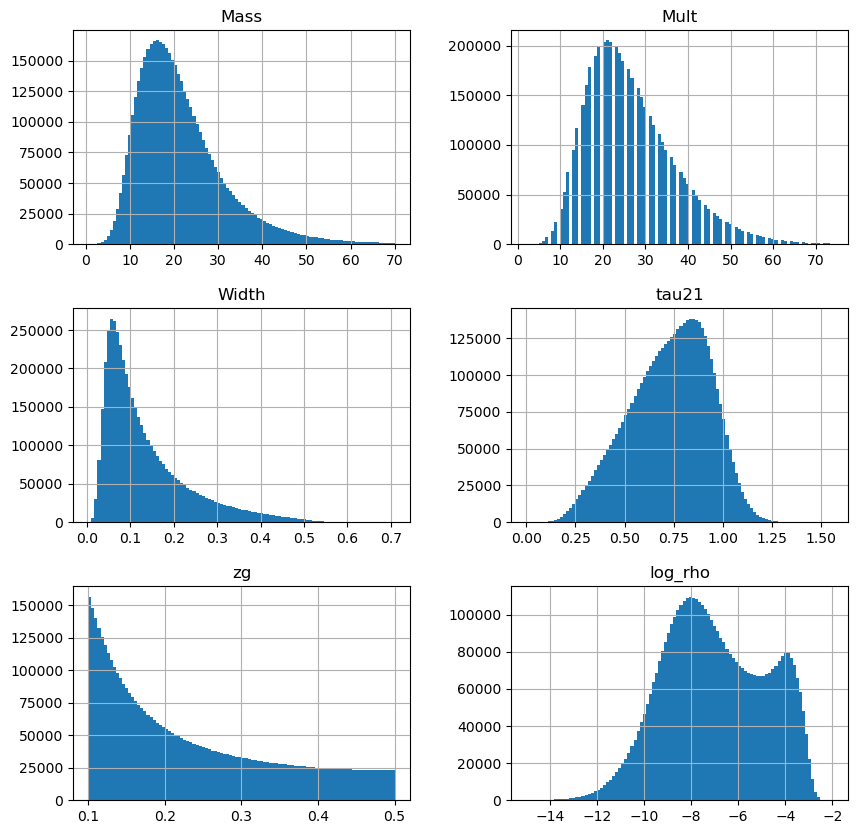

In [8]:
train_gen_features.hist(figsize=(10,10),bins=100)

array([[<AxesSubplot:title={'center':'Mass'}>,
        <AxesSubplot:title={'center':'Mult'}>],
       [<AxesSubplot:title={'center':'Width'}>,
        <AxesSubplot:title={'center':'tau21'}>],
       [<AxesSubplot:title={'center':'zg'}>,
        <AxesSubplot:title={'center':'log_rho'}>]], dtype=object)

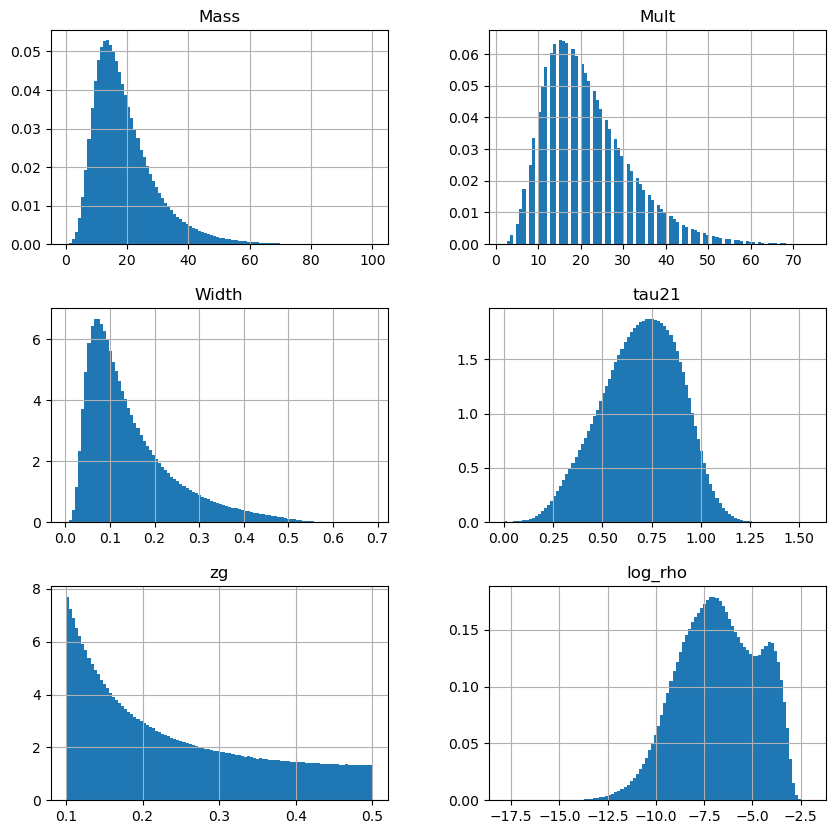

In [7]:
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
train_sim_features = pd.DataFrame(sim_features,columns=cols)
train_sim_features.hist(figsize=(10,10),bins=100,density=True)

In [6]:
from models.mlp import MLP
net = MLP(config['model']['blocks'],dropout_setval=0.0)
dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2_MLP___Feb-12-2024\IBU2_MLP_epoch99_val_loss_0.028303.pth")
net.to('cuda')
net.load_state_dict(dicte['net_state_dict'])

<All keys matched successfully>

In [4]:
 # Load the MNF model
net = create_freai(6,layers=config['model']['num_layers'])
net.to('cuda')
dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2_KinematicConds_Unfold___Feb-19-2024\IBU2_KinematicConds_Unfold_epoch99_val_loss_0.027595.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2_KinematicConds_Div___Feb-18-2024\IBU2_KinematicConds_Div_epoch96_val_loss_0.062767.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2_Variational_Inverse___Feb-14-2024\IBU2_Variational_Inverse_epoch99_val_loss_0.059936.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2_OneDirection___Feb-12-2024\IBU2_OneDirection_epoch74_val_loss_0.028673.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2_Unfold_SmoothL1___Feb-08-2024\IBU2_Unfold_SmoothL1_epoch22_val_loss_0.064356.pth")
#dicte = torch.load(config['Inference']['MNF_model'])
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Augmented_Unfold___Jan-30-2024\IBU2Q_Augmented_Unfold_epoch66_val_loss_0.022282.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Augmented_Unfold___Jan-30-2024\IBU2Q_Augmented_Unfold_epoch09_val_loss_0.025676.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Augmented_Identity___Jan-26-2024\IBU2Q_Augmented_Identity_epoch35_val_loss_0.000007.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Augmented_Unfold___Jan-25-2024\IBU2Q_Augmented_Unfold_epoch57_val_loss_0.041764.pth")
##dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Unfold_RMLargeBW_Max0.1___Jan-25-2024\IBU2Q_Unfold_RMLargeBW_Max0.1_epoch29_val_loss_0.030355.pth")
#----googe----dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Unfold_RMLargeBW___Jan-24-2024\IBU2Q_Unfold_RMLargeBW_epoch99_val_loss_0.033217.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Unfold_TightSimCuts___Jan-24-2024\IBU2Q_Unfold_TightSimCuts_epoch56_val_loss_0.030517.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Unfold_RBFKernel___Jan-24-2024\IBU2Q_Unfold_RBFKernel_epoch54_val_loss_0.021579.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Unfold_RemoveSmallBW___Jan-23-2024\IBU2Q_Unfold_RemoveSmallBW_epoch97_val_loss_0.020467.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Unfold_WiderBandwidth___Jan-23-2024\IBU2Q_Unfold_WiderBandwidth_epoch62_val_loss_0.030966.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Unfold_WiderBandwidth___Jan-23-2024\IBU2Q_Unfold_WiderBandwidth_epoch86_val_loss_0.030156.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Unfold_MMDScale1.2___Jan-22-2024\IBU2Q_Unfold_MMDScale1.2_epoch97_val_loss_0.028411.pth")
#dicte = torch.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Trained_Models\IBU2Q_Identity___Jan-19-2024\IBU2Q_Identity_epoch99_val_loss_0.000006.pth")
net.load_state_dict(dicte['net_state_dict'])

<All keys matched successfully>

In [5]:
t_params = sum(p.numel() for p in net.parameters())
print("Network Parameters: ",t_params)

Network Parameters:  2624544


In [ ]:
pred_reco = []
truth_reco = []
sigmas = []
pred_gen = []
truth_gen = []
net.eval()
for i,data in enumerate(herwig_loader):
    reco = data[0]
    gen = data[1]
    k = data[2].to('cuda').float()
    truth_gen.append(data[1].numpy())
    truth_reco.append(data[0].numpy())

    with torch.no_grad():
        pred_g,_ = net.forward(reco.to('cuda').float(),rev=True,c=[k])
        
    pred_g = pred_g.detach().cpu().numpy()
    pred_gen.append(pred_g)
#     if i == 1000:
#         break
    
#pred_reco = scaler.inverse_transform(np.concatenate(pred_reco))
#truth_reco = scaler.inverse_transform(np.concatenate(truth_reco))
#pred_gen = scaler.inverse_transform(np.concatenate(pred_gen))
pred_gen = np.concatenate(pred_gen)
truth_gen = np.concatenate(truth_gen)

In [10]:
(pred_gen - truth_gen)/(truth_gen + 1e-50)

array([[ 0.00735855,  0.22536936, -0.01068365, -0.08034253,  0.05173151,
        -0.01535136],
       [ 0.04343956,  0.10647456,  0.72826627, -0.24659426, -0.19464118,
         0.11200457],
       [ 0.14560797, -0.16968489, -0.41795258,  0.00843297, -0.14609861,
         0.06138198],
       ...,
       [ 0.08122972,  0.4623153 , -0.23113745,  0.18605786, -0.01180171,
        -0.00544036],
       [ 0.08489739, -0.0231054 , -0.02951235, -0.03519474, -0.12956531,
        -0.00602515],
       [ 0.18458842,  0.13136211,  0.56840979,  0.02013071,  0.09315014,
         0.18045179]])

In [12]:
truth_gen

array([[ 3.56044693e+01,  3.10000000e+01,  2.87552926e-01,
         2.77774993e-01,  2.71869995e-01, -4.01553207e+00],
       [ 1.86661224e+01,  1.80000000e+01,  5.53866140e-02,
         6.78307558e-01,  2.19972055e-01, -9.99185007e+00],
       [ 1.45453701e+01,  2.00000000e+01,  4.55789512e-02,
         9.82640933e-01,  2.90605012e-01, -8.88821941e+00],
       ...,
       [ 1.42249880e+01,  1.10000000e+01,  7.95715898e-02,
         5.23963745e-01,  2.15878692e-01, -1.04709453e+01],
       [ 3.65020218e+01,  5.10000000e+01,  3.81226517e-01,
         6.64373857e-01,  2.73874960e-01, -3.70966869e+00],
       [ 2.94382191e+01,  3.30000000e+01,  1.24850762e-01,
         7.63953003e-01,  1.30882614e-01, -5.79624954e+00]])

In [11]:
feature_names = np.array([r"$\Delta$ Jet Mass [GeV]",r"$\Delta$ Jet Width", r"$\Delta$ $n_{constituents}$",r"$\Delta$ $ln\rho$",r"$\Delta$ $z_g$",r"$\Delta$ $\tau_{21}$"])
feature_names = feature_names[[0,2,1,5,4,3]]
bins_pt = np.linspace(40,1200,50)
bins_res = np.arange(-6,6,0.12)
for i in range(len(feature_names)):
    #pred = inf_data['Events'][:,i]
    #true = inf_data['Truth'][:,i]
    pred = pred_gen[:,i]
    true = truth_gen[:,i]
    if 'n_{constituents}' in feature_names[i]:
        print('Discrete')
        pred = pred.round()
    res = (true - pred)/(true + 1e-10)
    
    idx = np.where(abs(res) < 0.05)[0]
    
    print(feature_names[i])
    print(len(idx)/len(res))


$\Delta$ Jet Mass [GeV]
0.16910853953850863
Discrete
$\Delta$ $n_{constituents}$
0.2537228268433212
$\Delta$ Jet Width
0.14517285050240766
$\Delta$ $\tau_{21}$
0.24079383193698334
$\Delta$ $z_g$
0.10595617502157152
$\Delta$ $ln\rho$
0.2728971247251371


In [13]:
pred_reco = []
truth_reco = []
sigmas = []
pred_gen = []
truth_gen = []
net.eval()
samples = 100
for i,data in enumerate(val_loader):
    reco = data[0]
    gen = data[1]
    truth_gen.append(data[1].numpy())
    truth_reco.append(data[0].numpy())
#    temp_gen = []
    temp_reco = []
    for j in range(len(reco)):
        temp_reco.append(np.expand_dims(reco[j],0).repeat(samples,0))
#        temp_gen.append(np.expand_dims(gen[j],0).repeat(samples,0))
    
    temp_reco = torch.tensor(np.concatenate(temp_reco)).to('cuda').float()
#    temp_gen = torch.tensor(np.concatenate(temp_gen)).to('cuda').float()

    with torch.no_grad():
#        pred_r,_ = net.forward(temp_gen,rev=False)
        pred_g,_ = net.forward(temp_reco,rev=True)
        
#    pred_r = pred_r.detach().cpu().numpy().reshape(-1,samples,temp_gen.shape[1])
    pred_g = pred_g.detach().cpu().numpy().reshape(-1,samples,temp_reco.shape[1])
    
#    pred_reco.append(np.mean(pred_r,axis=1))
    pred_gen.append(np.mean(pred_g,axis=1))
    sigmas.append(np.std(pred_g,axis=1))
#     if i == 1000:
#         break
    
#pred_reco = scaler.inverse_transform(np.concatenate(pred_reco))
truth_reco = scaler.inverse_transform(np.concatenate(truth_reco))
pred_gen = scaler.inverse_transform(np.concatenate(pred_gen))
truth_gen = scaler.inverse_transform(np.concatenate(truth_gen))
# truth_gen = np.concatenate(truth_gen)
sigmas = np.concatenate(sigmas)# * np.sqrt(scaler.var_)

In [14]:
truth_gen

array([[16.07519913, 18.        ,  0.06864428,  1.02411147,  0.30805646,
        -9.26416591],
       [12.21319771, 16.        ,  0.0401058 ,  0.72924522,  0.30938665,
        -8.95612824],
       [10.12253761, 14.        ,  0.03865262,  0.75725245,  0.36145207,
        -7.98652641],
       ...,
       [13.75187302, 16.        ,  0.07187855,  0.59480637,  0.29745708,
        -9.78644271],
       [ 8.1295414 ,  8.        ,  0.05649306,  0.96863172,  0.10017324,
        -8.63523628],
       [ 8.95035362, 21.        ,  0.06495669,  0.84526689,  0.24437765,
        -8.26420503]])

In [15]:
pred_gen

array([[ 14.54613   ,  19.097002  ,   0.0686418 ,   0.97307205,
          0.17164624,  -8.190019  ],
       [ 11.907941  ,  15.840454  ,   0.02833523,   0.96326655,
          0.27615872,  -8.989363  ],
       [ 11.793296  ,  11.50756   ,   0.03226578,   0.97283274,
          0.16965069,  -8.107016  ],
       ...,
       [ 17.205595  ,  17.208567  ,   0.06730411,   0.5862429 ,
          0.2535551 , -11.00128   ],
       [  5.324513  ,   8.483367  ,   0.03218199,   0.6989437 ,
          0.39413786,  -8.376585  ],
       [ 13.36638   ,  23.297077  ,   0.06734327,   0.9070766 ,
          0.10921151,  -8.111079  ]], dtype=float32)

In [11]:
pred_gen

array([[10.839915  , 13.989161  ,  0.07999284,  0.9177213 ,  0.18458737,
        -7.9572287 ],
       [ 8.007729  , 10.951188  ,  0.03618032,  0.8550252 ,  0.3019611 ,
        -8.709298  ],
       [ 7.195928  ,  7.987373  ,  0.04870944,  0.8667681 ,  0.18289523,
        -7.751183  ],
       ...,
       [11.762125  , 13.01445   ,  0.10169623,  0.41457847,  0.2188537 ,
        -6.0321283 ],
       [12.617091  , 17.993387  ,  0.19313775,  0.75786436,  0.22042653,
        -5.398676  ],
       [15.568351  , 15.028051  ,  0.14605552,  0.62420803,  0.18042046,
        -7.7730837 ]], dtype=float32)

In [22]:
np.concatenate(np.concatenate(pred_gen)).shape

(505000, 6)

In [14]:
import matplotlib.pyplot as plt

In [12]:
#res_reco = (pred_reco - truth_reco)/(truth_reco + 1e-50)
res_gen = (pred_gen - truth_gen)/(truth_gen + 1e-50)

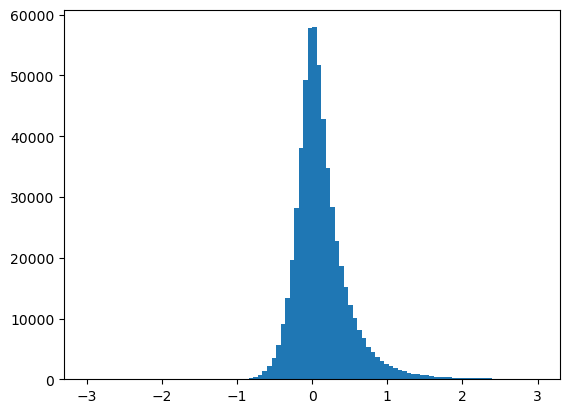

In [20]:
plt.hist(res_gen[:,0],bins=100,range=[-3,3])
plt.show()

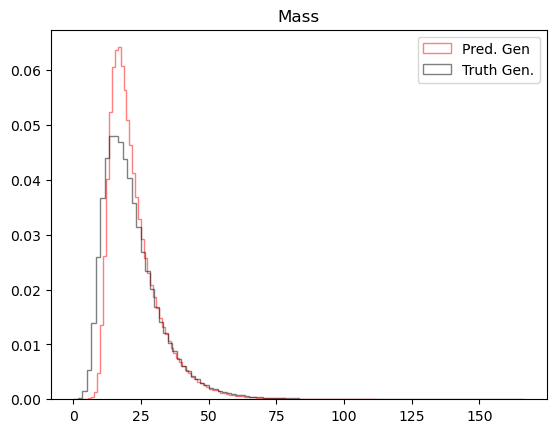

In [8]:
import matplotlib.pyplot as plt
idx = 0
#q = pred_reco[:,idx]
p = pred_gen[:,idx]
#print(q.min())
if idx == 1:
#    q = q.round()
    p = p.round()
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
# plt.hist(q,bins=100,alpha=0.5,label='Pred. Reco',density=True,histtype='step',color='green')
# plt.hist(truth_reco[:,idx],bins=100,alpha=0.5,label='Truth Reco',density=True,histtype='step',color='blue')

plt.hist(p,bins=100,alpha=0.5,label='Pred. Gen',density=True,histtype='step',color='red')
plt.hist(truth_gen[:,idx],bins=100,alpha=0.5,label='Truth Gen.',density=True,histtype='step',color='k')
plt.title(cols[idx])
#if idx == 4:
#    plt.yscale('log')
plt.legend()
plt.show()

In [10]:
pred_gen[:,5]

-15.187075

In [15]:
a = np.array(100*(preds - truth)/(truth + 1e-50))
b = abs(preds - truth)

0.004132756631270925


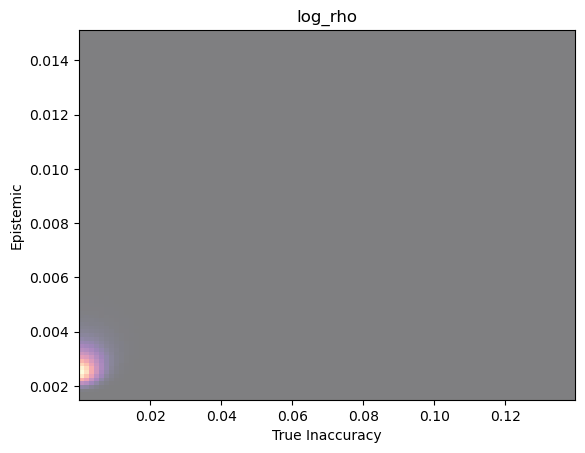

In [17]:
idx = 5
q = b[:,idx]
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
e = sigmas[:,idx]
#if idx == 1:
#    q = q.round()
    
print(q.mean())
plt.hist2d(q,e,bins=100,alpha=0.5,label='Res.',density=True,cmap='magma')
#plt.scatter(q,e)
plt.ylabel('Epistemic')
plt.xlabel('True Inaccuracy')
plt.title(cols[idx])
plt.show()

0.017115103058991336


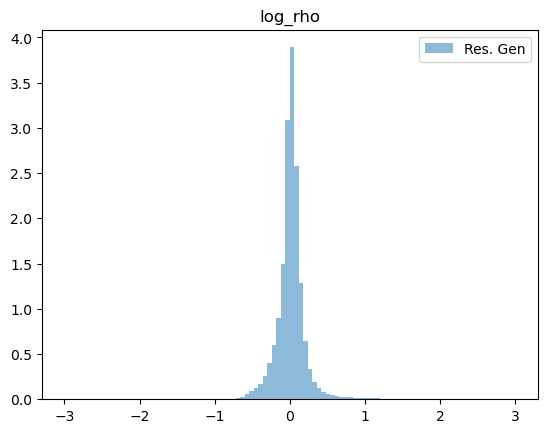

In [35]:
import matplotlib.pyplot as plt
idx = 5
#q = res_reco[:,idx]
p = res_gen[:,idx]
p = p[np.where((p > -3) & (p < 3))]
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]

    
#print(q.mean())
print(p.mean())
#plt.hist(q,bins=100,alpha=0.5,label='Res. Reco',density=True)#,range=[-10,10])
plt.hist(p,bins=100,alpha=0.5,label='Res. Gen',density=True,range=[-3,3])
plt.legend()
plt.title(cols[idx])
plt.show()

In [12]:
100*len(train_sim_features[train_sim_features.zg < 0.1])/len(train_sim_features)

0.18231413700002783

In [29]:
nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]

binning = dict(binning)

In [82]:
train_gen_features['prob']

0         0.021159
1         0.056752
2         0.024160
3         0.003149
4         0.014958
            ...   
999995    0.026608
999996    0.053805
999997    0.016857
999998    0.005289
999999    0.053805
Name: prob, Length: 1000000, dtype: category
Categories (56, float64): [0.000055 < 0.000241 < 0.000788 < 0.002241 ... 0.000944 < 0.000891 < 0.000799 < 0.000727]

In [83]:
train_gen_features['mass_bin'] = pd.cut(train_gen_features['Mass'],binning['Mass'],labels=np.arange(1,len(binning['Mass'])))
bin_counts = train_gen_features['mass_bin'].value_counts()
sorted_bin_counts = bin_counts.sort_index()
prob = sorted_bin_counts / len(train_gen_features)
train_gen_features['prob'] = train_gen_features['mass_bin'].map(prob)
train_gen_features['inverse_prob'] = 1 - train_gen_features['prob'].to_numpy()
train_gen_features

Mass  Mult     Width     tau21        zg    log_rho mass_bin  \
0       28.105358  37.0  0.070360  1.010430  0.131177  -7.450535       26   
1       14.882744  22.0  0.206225  0.879548  0.301911  -4.993340       14   
2       27.174328  24.0  0.116504  0.453487  0.373738  -9.151955       25   
3       46.210918  37.0  0.292143  0.417967  0.142383  -3.646999       43   
4       30.762379  34.0  0.028953  0.933399  0.213502 -12.448340       29   
...           ...   ...       ...       ...       ...        ...      ...   
999995   8.710872  18.0  0.058593  0.956066  0.146275  -7.840727        8   
999996  17.847691  31.0  0.109734  0.925535  0.178851  -7.135863       16   
999997  29.669559  35.0  0.043619  0.905235  0.106005  -9.484102       28   
999998   5.529476  10.0  0.037018  0.903038  0.112163  -7.898616        5   
999999  16.875252  20.0  0.051683  0.819460  0.236085  -8.619607       16   

            prob  inverse_prob  
0       0.021159      0.978841  
1       0.056752      0.943248  
2       0.024160      0.975840  
3       0.003149      0.996851  
4       0.014958      0.985042  
...          ...           ...  
999995  0.026608      0.973392  
999996  0.053805      0.946195  
999997  0.016857      0.983143  
999998  0.005289      0.994711  
999999  0.053805      0.946195  

[1000000 rows x 9 columns]

array([[<AxesSubplot:title={'center':'Mass'}>,
        <AxesSubplot:title={'center':'Mult'}>],
       [<AxesSubplot:title={'center':'Width'}>,
        <AxesSubplot:title={'center':'tau21'}>],
       [<AxesSubplot:title={'center':'zg'}>,
        <AxesSubplot:title={'center':'log_rho'}>]], dtype=object)

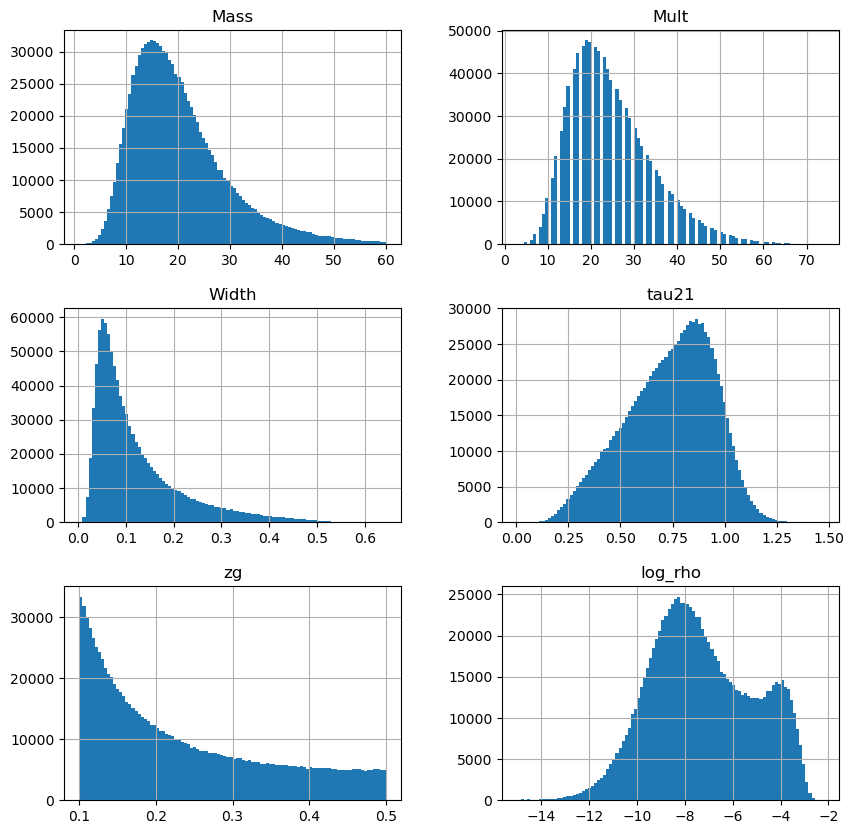

In [96]:
import pandas as pd
import numpy as np

# Assuming train_gen_features is your DataFrame and binning['Mass'] contains your bins
train_gen_features['mass_bin'] = pd.cut(train_gen_features['Mass'], binning['Mass'], labels=np.arange(1, len(binning['Mass'])))
bin_counts = train_gen_features['mass_bin'].value_counts()
sorted_bin_counts = bin_counts.sort_index()
probabilities = sorted_bin_counts / len(train_gen_features)

# Calculate probabilities and store in 'prob' column
train_gen_features['prob'] = train_gen_features['mass_bin'].map(probabilities)

# Adjusting probabilities to oversample the tail
power = 2  # You can adjust the power to control the oversampling
weights = train_gen_features['prob'].to_numpy() ** power

# Sample from train_gen_features based on adjusted weights
sampled_data = train_gen_features.sample(frac=1, replace=True, weights=1.0 - weights)

# Display the sampled_data
sampled_data.hist(figsize=(10,10),bins=100)

In [98]:
train_gen_features.max()

Mass        69.988594
Mult        74.000000
Width        0.664699
tau21        1.552454
zg           0.499999
log_rho     -2.190945
mass_bin    56.000000
prob         0.000727
dtype: float64

In [100]:
gen_features.max(0)

array([69.99081421, 74.        ,  0.68353397,  1.55245389,  0.49999946,
       -2.1856937 ])

In [101]:
sim_features.max(0)

array([69.99939728, 65.        ,  0.66438817,  1.55687874,  0.49999938,
       -2.26491756])

In [102]:
sim_features.min(0)

array([ 1.28449023e-01,  2.00000000e+00,  1.60297855e-03,  0.00000000e+00,
        1.00000086e-01, -1.49884749e+01])

In [103]:
gen_features.min(0)

array([ 7.36135960e-01,  2.00000000e+00,  3.18249790e-03,  0.00000000e+00,
        1.00000092e-01, -1.49996009e+01])

In [106]:
gen_herwig.min(0)

array([-1.07895930e-05,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.73288634e+01])

In [107]:
sim_features.min(0) - sim_herwig.min(0)

array([-1.38364136e-02,  0.00000000e+00, -2.79708676e-04,  0.00000000e+00,
       -1.30960379e-07, -3.72908654e-02])

In [110]:
gen_features.min(0)

array([ 7.36135960e-01,  2.00000000e+00,  3.18249790e-03,  0.00000000e+00,
        1.00000092e-01, -1.49996009e+01])

In [111]:
gen_herwig.min(0)

array([-1.07895930e-05,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.73288634e+01])

In [5]:
df = pd.read_csv(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\Inference.csv")
len(df)

574832

In [113]:
a = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\inn_Herwig.npy")
len(a)

569254

array([[<AxesSubplot:title={'center':'Mass'}>,
        <AxesSubplot:title={'center':'Width'}>,
        <AxesSubplot:title={'center':'Mult'}>],
       [<AxesSubplot:title={'center':'log_rho'}>,
        <AxesSubplot:title={'center':'zg'}>,
        <AxesSubplot:title={'center':'tau21'}>],
       [<AxesSubplot:title={'center':'Mass_sim'}>,
        <AxesSubplot:title={'center':'Width_sim'}>,
        <AxesSubplot:title={'center':'Mult_sim'}>],
       [<AxesSubplot:title={'center':'log_rho_sim'}>,
        <AxesSubplot:title={'center':'zg_sim'}>,
        <AxesSubplot:title={'center':'tau21_sim'}>]], dtype=object)

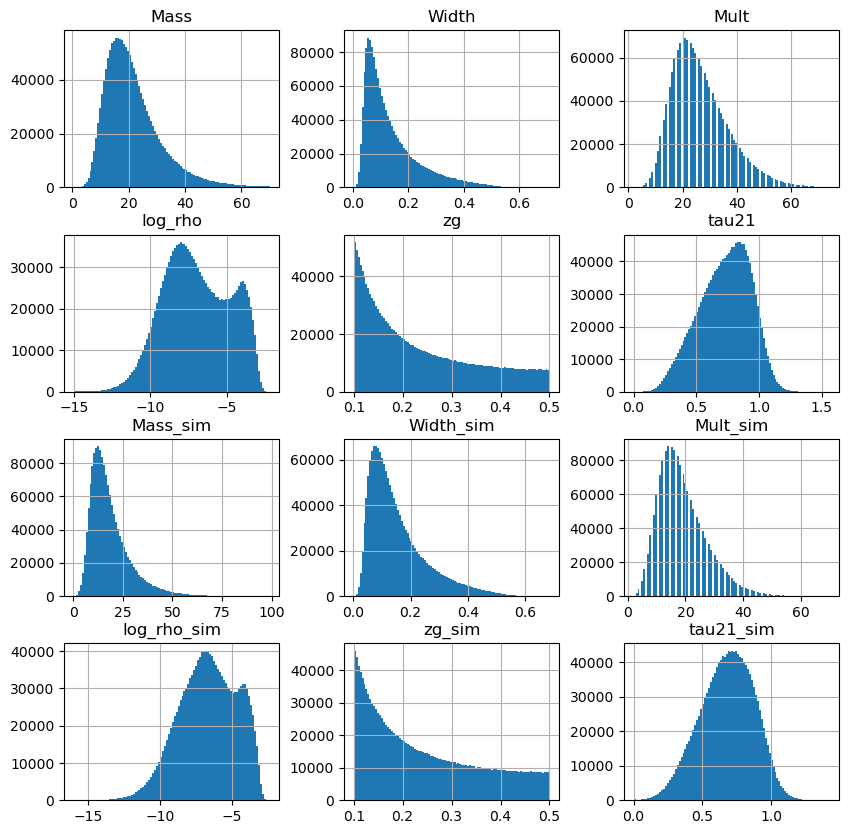

In [32]:
gen_pythia,sim_pythia = create_dataset(sample_name="Pythia21",N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])
gen_pythia = pd.DataFrame(gen_pythia,columns=cols)
sim_pythia = pd.DataFrame(sim_pythia,columns=[col+"_sim" for col in cols])
temp = pd.concat([gen_pythia,sim_pythia],axis=1)
temp = temp[(temp.zg > 0.1) & (temp.zg_sim > 0.1) & (temp.Mass < 70) & (temp.Mass_sim < 100) & (temp.log_rho > -15) & (temp.log_rho_sim > -20) & (temp.Mult < 75) & (temp.Mult_sim < 100) & (temp.Mass > 0)]
temp.hist(figsize=(10,10),bins=100)

In [25]:
pred_gen_df = pd.DataFrame(pred_gen,columns=cols)
true_gen_df = pd.DataFrame(truth,columns=[col+"_truth" for col in cols])
comb = pd.concat([pred_gen_df,true_gen_df],axis=1)

In [27]:
comb[comb.log_rho < -12]

Mass       Mult     Width     tau21        zg    log_rho  \
365     17.521746  17.501947  0.040778  0.603114  0.183535 -12.141972   
654     14.059047  22.332386  0.058299  0.683649  0.117827 -12.007923   
670     26.928579  14.260418  0.114998  0.171475  0.246553 -14.200390   
889     28.991650  27.513367  0.073331  0.697449  0.455279 -13.057428   
943     21.946388  15.280728  0.021417  0.928235  0.188987 -13.086774   
...           ...        ...       ...       ...       ...        ...   
574274  29.901468  14.640174  0.100935  0.321556  0.250474 -13.239238   
574283  31.025173  32.978519  0.051680  0.511191  0.454944 -12.782214   
574716  50.967297  29.446672  0.120002  0.309005  0.384485 -12.331544   
574751  24.215288  28.307636  0.076502  0.616704  0.300012 -12.908149   
574779  16.117596  20.849167  0.032960  0.978279  0.246359 -12.099006   

        Mass_truth  Mult_truth  Width_truth  tau21_truth  zg_truth  \
365      18.651667        13.0     0.048198     0.502751  0.202652   
654      16.532360        18.0     0.043958     0.556803  0.000000   
670      20.834789        18.0     0.117596     0.184125  0.286601   
889      24.390678        25.0     0.076999     0.596385  0.430474   
943      11.656833        15.0     0.029523     0.737732  0.110305   
...            ...         ...          ...          ...       ...   
574274    8.087167        17.0     0.036127     1.021986  0.293845   
574283   27.893795        24.0     0.056037     0.494536  0.397605   
574716   44.326355        32.0     0.161882     0.246989  0.118042   
574751   20.939928        25.0     0.076342     0.512889  0.342411   
574779   16.776382        27.0     0.039155     0.942781  0.343358   

        log_rho_truth  
365         -9.863408  
654        -15.854914  
670        -11.320278  
889        -12.490218  
943         -9.174739  
...               ...  
574274     -11.318885  
574283     -11.259388  
574716      -4.514851  
574751     -11.318604  
574779     -10.693980  

[5424 rows x 12 columns]

array([[<AxesSubplot:title={'center':'Mass'}>,
        <AxesSubplot:title={'center':'Mult'}>],
       [<AxesSubplot:title={'center':'Width'}>,
        <AxesSubplot:title={'center':'tau21'}>],
       [<AxesSubplot:title={'center':'zg'}>,
        <AxesSubplot:title={'center':'log_rho'}>]], dtype=object)

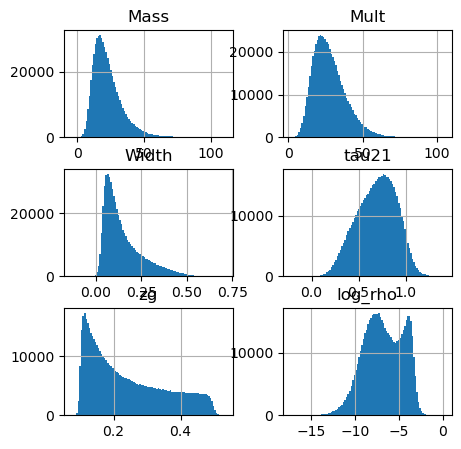

In [21]:
pred_gen_df.hist(figsize=(5,5),bins=100)

In [14]:
np.average(sim_pythia,axis=0)

array([17.18356998,  0.14191468, 17.69846002, -6.86440755,  0.24549394,
        0.67633883])

In [14]:
s = 'Herwig'
if 'Pythia' in s:
    print('hi')

In [5]:
import pandas as pd

df = pd.read_csv(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\Inference.csv",sep=',',index_col=None)

In [19]:
df.columns

Index(['Mass_pred', 'Mult_pred', 'Width_pred', 'tau21_pred', 'zg_pred',
       'log_rho_pred', 'Mass_sigma', 'Mult_sigma', 'Width_sigma',
       'tau21_sigma', 'zg_sigma', 'log_rho_sigma', 'Mass_truth', 'Mult_truth',
       'Width_truth', 'tau21_truth', 'zg_truth', 'log_rho_truth'],
      dtype='object')

In [9]:
df = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\Inference_Augmented.pkl",allow_pickle=True)

In [12]:
mcmc = df['Events']
truth = df['Truth']

In [6]:
df = pd.read_csv(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\Inference.csv",sep=',',index_col=None)

mcmc = df[['Mass_pred', 'Mult_pred', 'Width_pred', 'tau21_pred', 'zg_pred',
       'log_rho_pred']].to_numpy()
truth = df[['Mass_truth', 'Mult_truth',
       'Width_truth', 'tau21_truth', 'zg_truth', 'log_rho_truth']].to_numpy()
sigmas = df[['Mass_sigma', 'Mult_sigma', 'Width_sigma',
       'tau21_sigma', 'zg_sigma', 'log_rho_sigma']].to_numpy()

In [23]:
mcmc[mcmc.Mass_pred < -12]

AttributeError: 'numpy.ndarray' object has no attribute 'Mass_pred'

In [2]:
from utils import load_MCMC
mcmc,truth = load_MCMC(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\metro_chains1k")

Loading MCMC.
125/126 [==================>.] - ETA: 1s

In [11]:
a = np.mean(mcmc['Mass'],axis=1)
print(a.min())

-62.610413


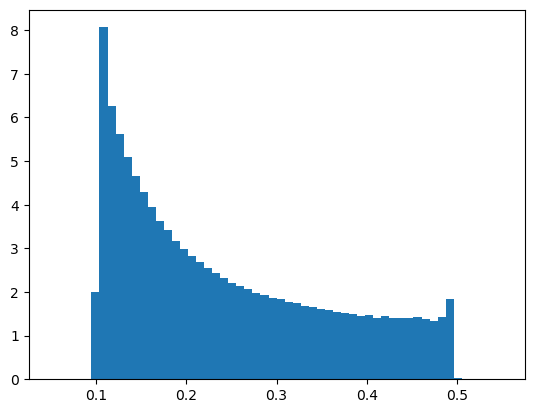

In [8]:
import matplotlib.pyplot as plt
nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]

# mcmc = pred_gen
# truth = truth_gen
#sigma = np.zeros_like(mcmc[:,0])
binning = dict(binning)

plt.hist(a,bins=binning['zg'],density=True)
plt.show()

In [33]:
truth_gen

array([[ 39.24591064,  26.        ,   0.14444214,   0.41157519,
          0.26201837,  -7.7157167 ],
       [ 39.95331955,  33.        ,   0.29190696,   0.54687685,
          0.36958017,  -4.16976807],
       [ 13.92273903,  10.        ,   0.09693509,   0.25401437,
          0.12940093, -10.51495043],
       ...,
       [ 14.22498798,  11.        ,   0.07957159,   0.52396374,
          0.21587869, -10.47094526],
       [ 36.50202179,  51.        ,   0.38122652,   0.66437386,
          0.27387496,  -3.70966869],
       [ 29.43821907,  33.        ,   0.12485076,   0.763953  ,
          0.13088261,  -5.79624954]])

In [117]:
mcmc['Mult'][0].shape

(1000,)

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

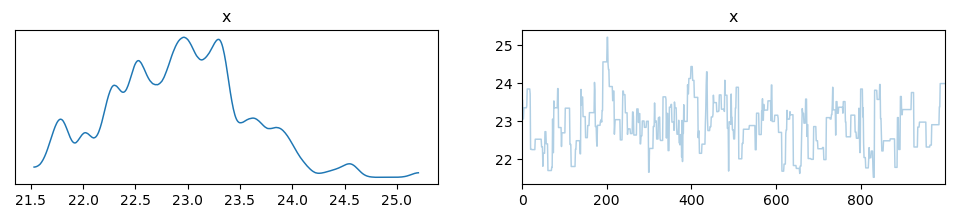

In [123]:
import arviz
arviz.plot_trace(arviz.convert_to_dataset(mcmc['Mass'][100]))

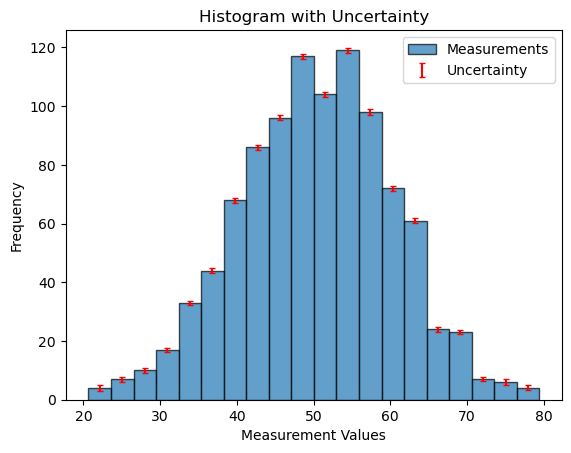

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace this with your actual data)
measurements = np.random.normal(50, 10, 1000)  # mean=50, std=10
errors = np.random.uniform(0, 5, 1000)  # Example: uniform errors between 0 and 5

# Create histogram with error bars
plt.hist(measurements, bins=20, alpha=0.7, label='Measurements', edgecolor='black')

# Calculate mean and standard deviation for each bin
bin_means, bin_edges, _ = plt.hist(measurements, bins=20, alpha=0, edgecolor='black')
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_stddevs = [np.std(measurements[(measurements >= bin_edges[i]) & (measurements < bin_edges[i+1])]) for i in range(len(bin_centers))]

# Plot error bars
plt.errorbar(bin_centers, bin_means, yerr=bin_stddevs, fmt='none', color='red', ecolor='red', capsize=2, label='Uncertainty')

# Customize appearance
plt.xlabel('Measurement Values')
plt.ylabel('Frequency')
plt.title('Histogram with Uncertainty')
plt.legend()
plt.show()

In [108]:
a['trace_0']

[array([37.08720751, 36.67115761,  0.16599657,  0.42499543,  0.28116832,
        -3.56523741]),
 array([37.30781848, 37.42055592,  0.27158206,  0.38239893,  0.27195098,
        -3.36747246]),
 array([36.52607294, 37.07663084,  0.29761219,  0.31478972,  0.36780272,
        -3.88050175]),
 array([36.52607294, 37.07663084,  0.29761219,  0.31478972,  0.36780272,
        -3.88050175]),
 array([36.52607294, 37.07663084,  0.29761219,  0.31478972,  0.36780272,
        -3.88050175]),
 array([35.47006395, 36.98899761,  0.34247583,  0.2688718 ,  0.35709082,
        -3.89241183]),
 array([35.47006395, 36.98899761,  0.34247583,  0.2688718 ,  0.35709082,
        -3.89241183]),
 array([35.14984164, 36.29033072,  0.33049806,  0.12035418,  0.37779286,
        -4.08335067]),
 array([35.14984164, 36.29033072,  0.33049806,  0.12035418,  0.37779286,
        -4.08335067]),
 array([34.81911662, 36.20331757,  0.36151013,  0.19158068,  0.34840219,
        -4.85503127]),
 array([34.81911662, 36.20331757,  0.361

(array([3.000e+00, 1.800e+01, 4.000e+01, 7.700e+01, 1.780e+02, 3.640e+02,
        6.340e+02, 9.760e+02, 1.313e+03, 1.719e+03, 2.266e+03, 2.775e+03,
        3.151e+03, 3.460e+03, 3.815e+03, 4.001e+03, 4.128e+03, 4.109e+03,
        4.112e+03, 4.071e+03, 3.992e+03, 3.923e+03, 3.629e+03, 3.484e+03,
        3.305e+03, 3.117e+03, 2.809e+03, 2.631e+03, 2.499e+03, 2.368e+03,
        2.113e+03, 2.010e+03, 1.917e+03, 1.657e+03, 1.562e+03, 1.361e+03,
        1.281e+03, 1.154e+03, 1.119e+03, 9.710e+02, 9.490e+02, 8.590e+02,
        7.470e+02, 6.940e+02, 5.890e+02, 5.710e+02, 5.250e+02, 4.640e+02,
        4.560e+02, 3.810e+02, 3.470e+02, 3.630e+02, 2.740e+02, 2.780e+02,
        2.350e+02, 2.190e+02, 2.170e+02, 1.860e+02, 1.790e+02, 1.160e+02,
        1.440e+02, 1.400e+02, 1.090e+02, 9.500e+01, 1.020e+02, 9.100e+01,
        7.300e+01, 8.000e+01, 5.400e+01, 5.300e+01, 5.800e+01, 4.300e+01,
        6.200e+01, 4.800e+01, 4.600e+01, 4.300e+01, 3.800e+01, 3.700e+01,
        2.300e+01, 1.800e+01, 2.400e+0

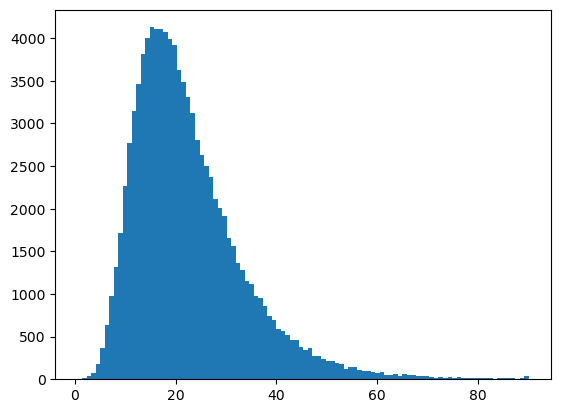

In [105]:
plt.hist(mcmc['Mass'][:,0],bins=100)

In [10]:
len(mcmc['Mass'])

565852

Creating Data.
Applying cuts on Gen. and Sim. for Pythia26
Cutting negative masses from Herwig generations.
Constraining Herwig simulation to domain of Pythia.
 
Running IBU.
Done with Mass
Done with Mult
Done with Width
Done with tau21
Done with zg
Done with log_rho
Plotting  Mass
565852
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Plotting  Mult
565852
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Plotting  Width
565852
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Plotting  tau21
565852
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Plotting  zg
565852
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Plotting  log_rho
565852
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 

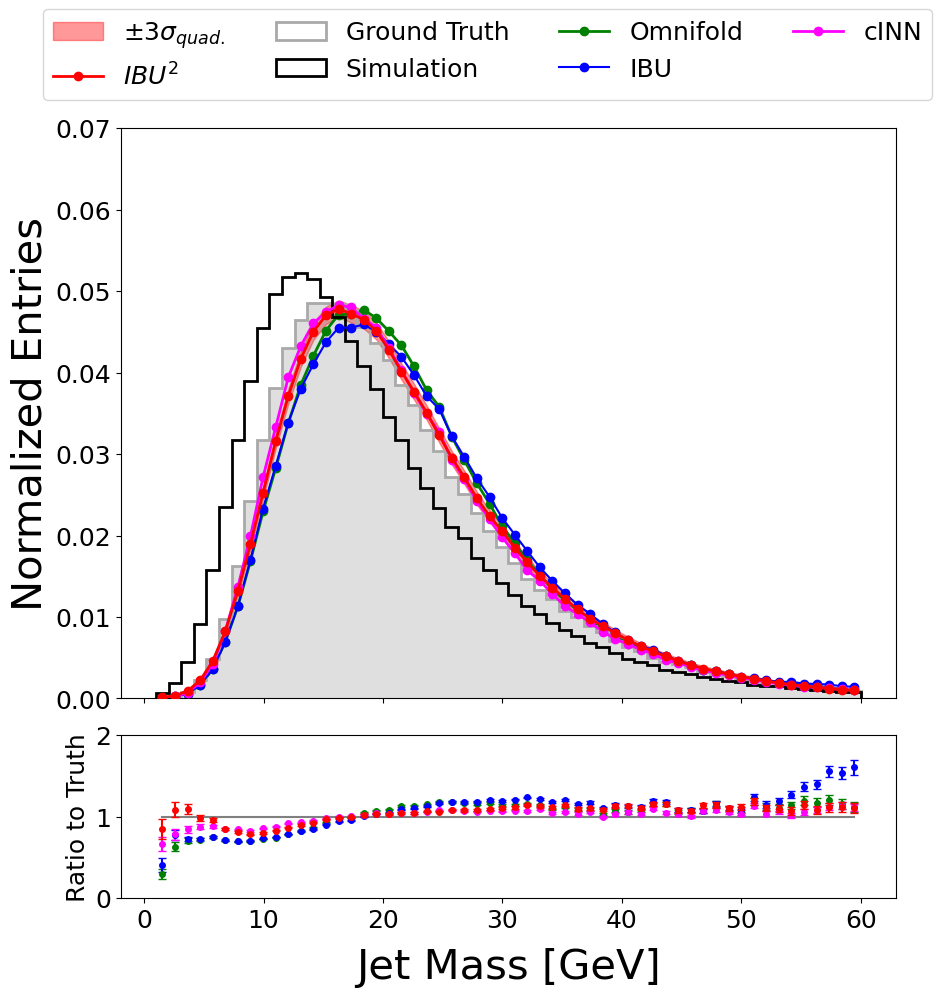

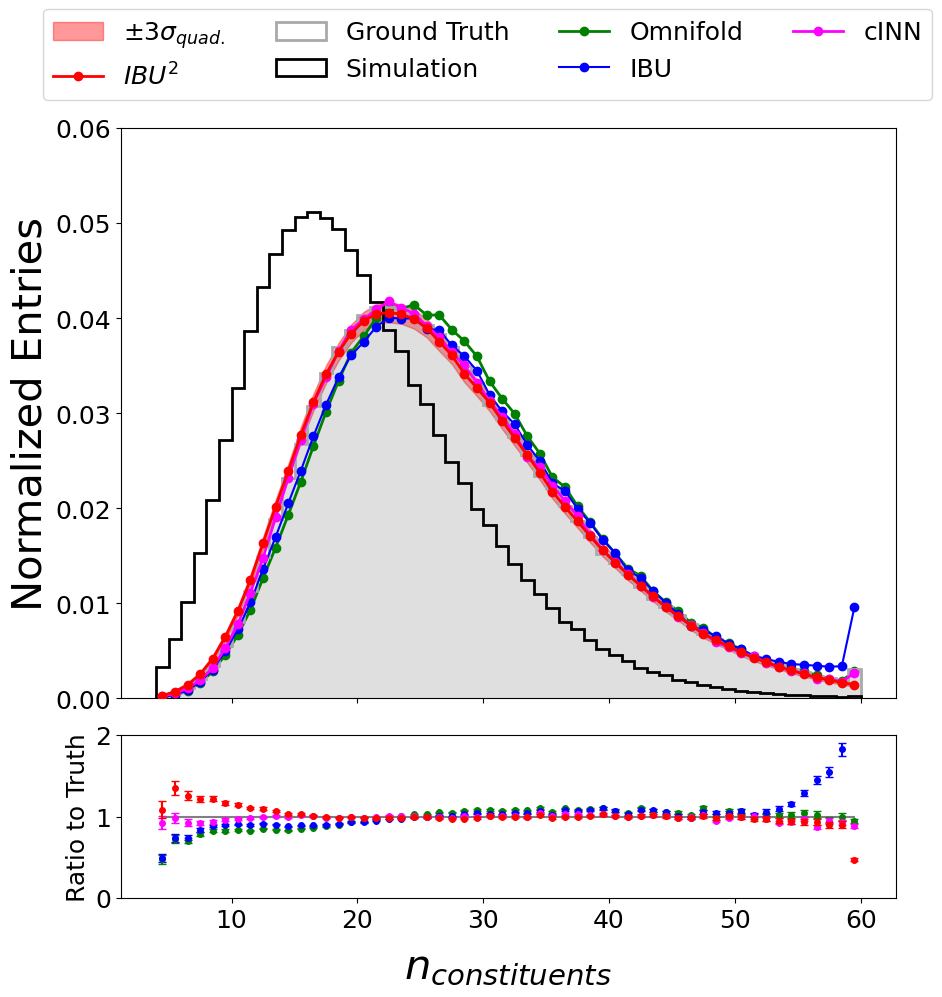

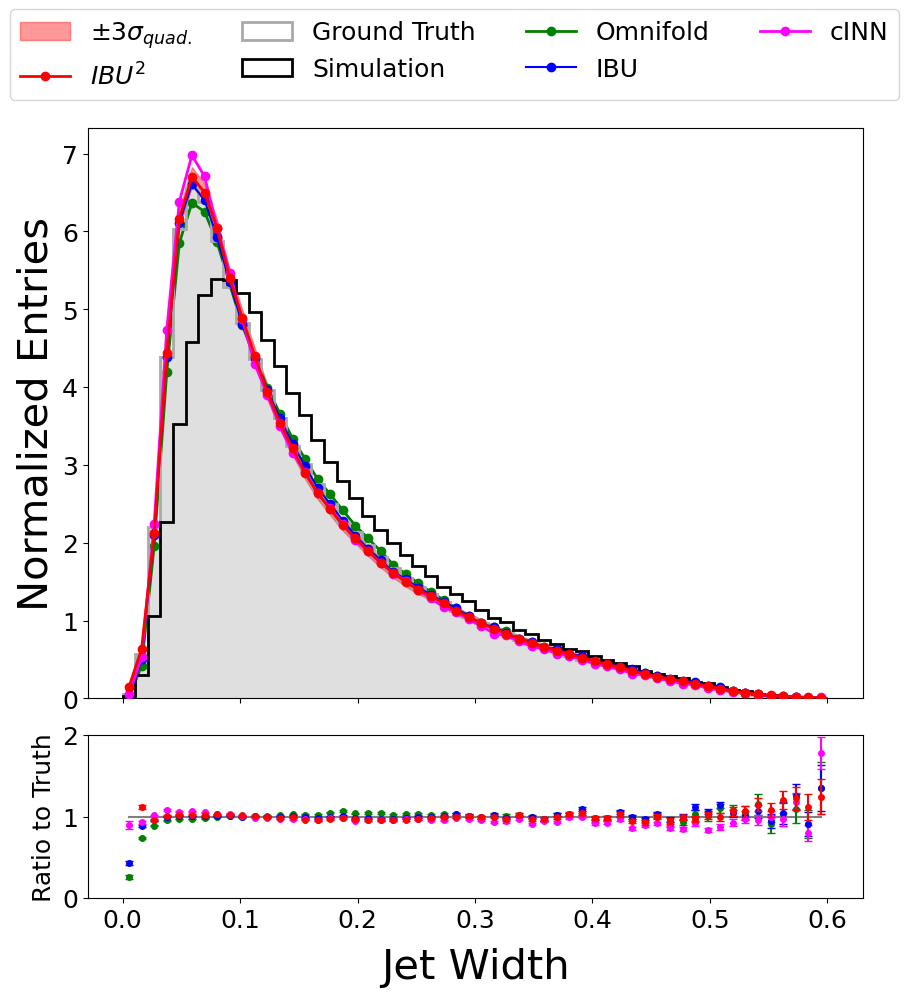

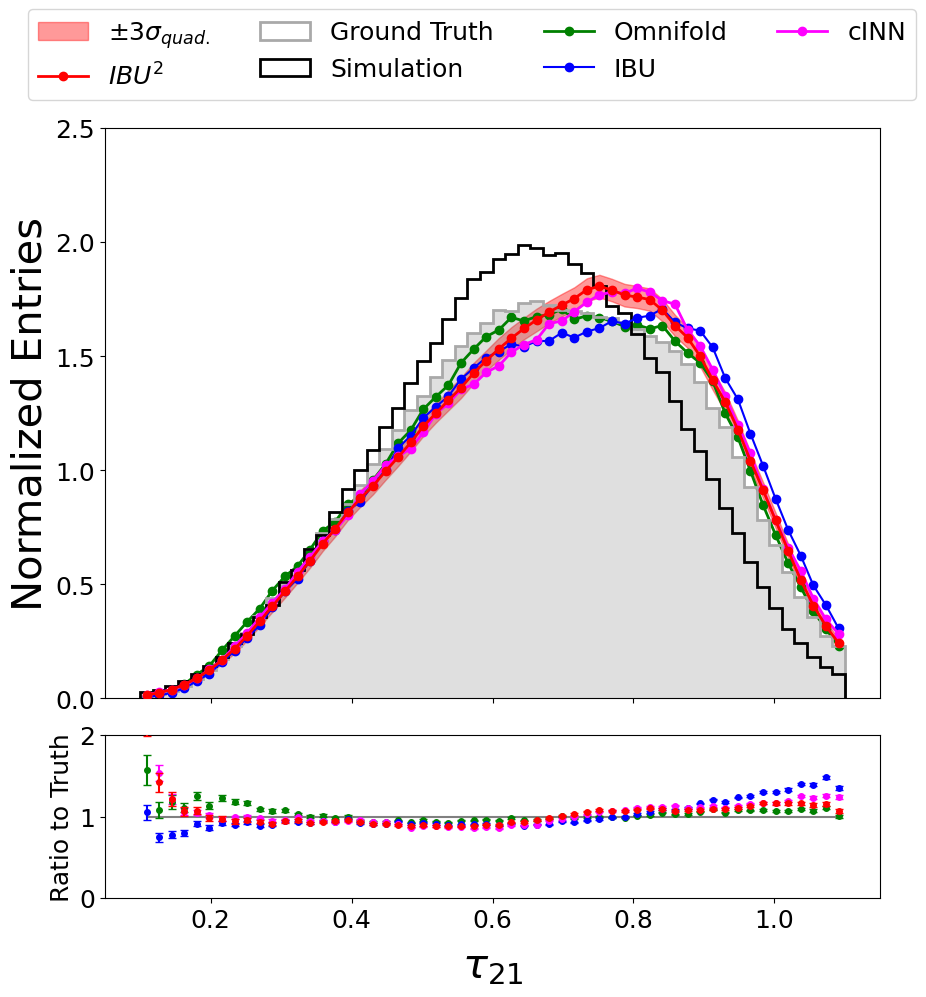

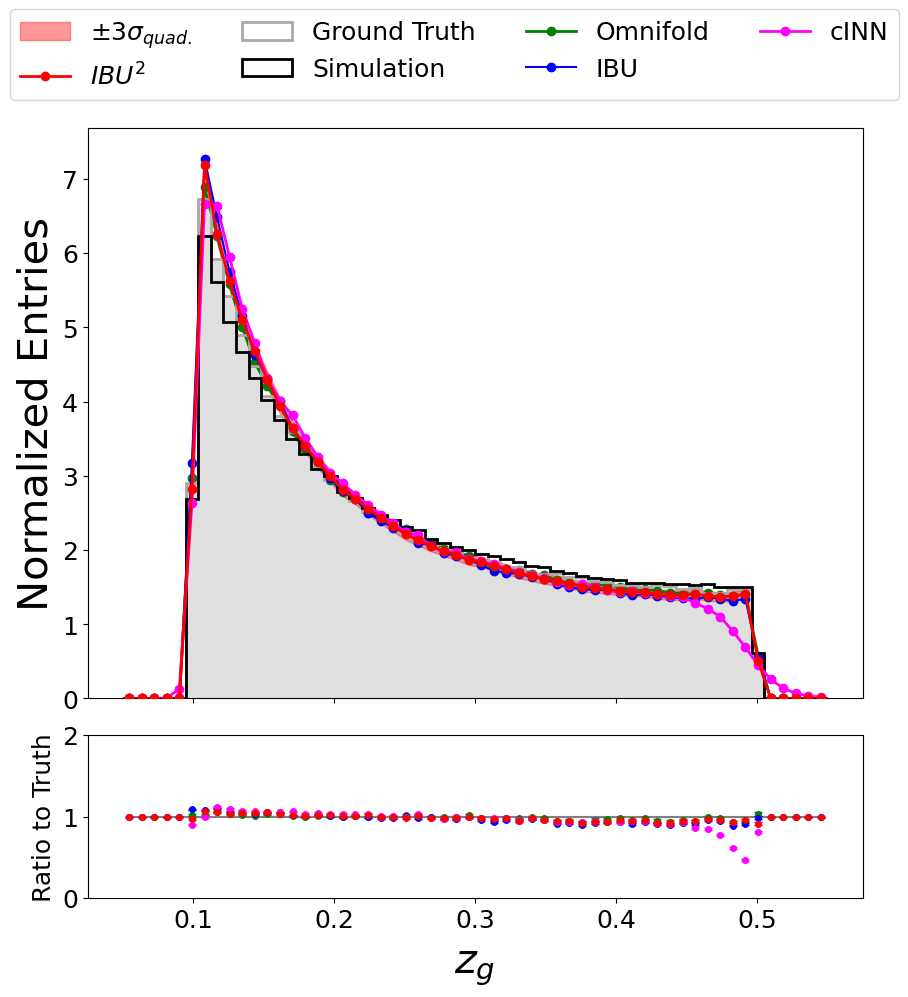

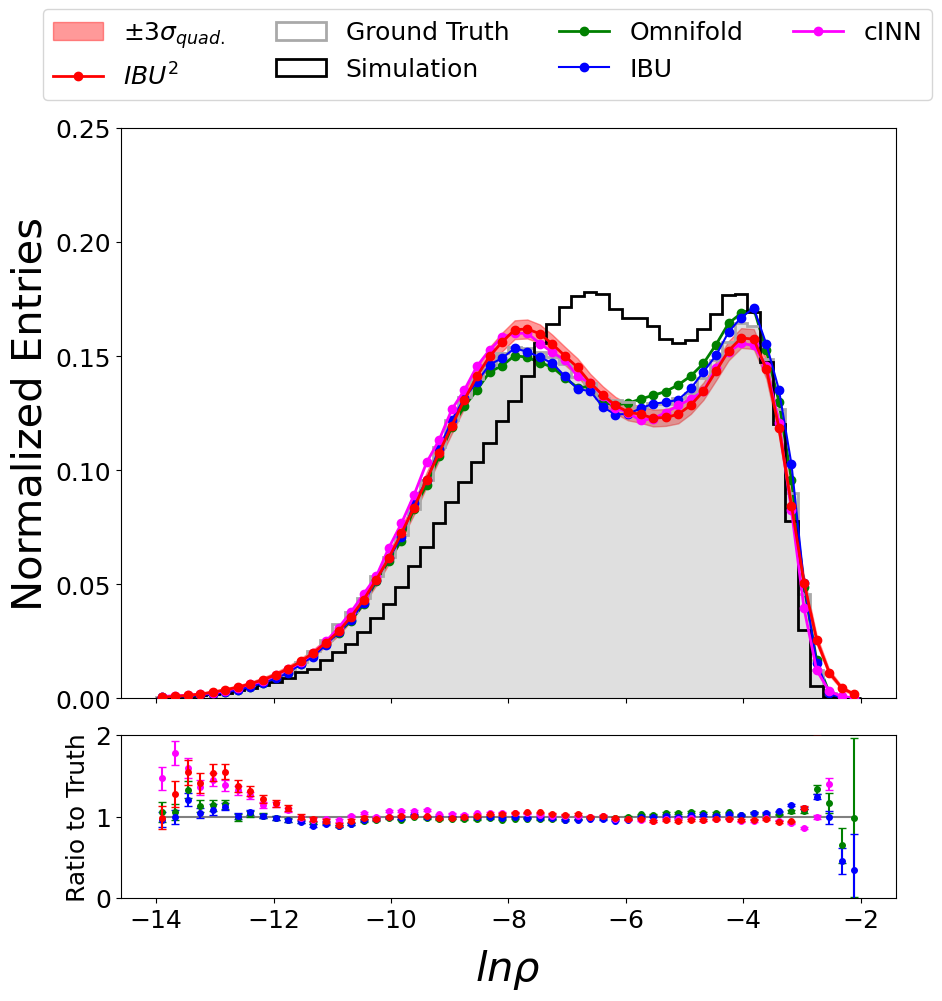

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import argparse
from dataloader.create_data import return_data, create_dictionary
from ibu import run_ibu
import arviz
from utils import load_MCMC
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Two Functions from SBUnfold https://github.com/ViniciusMikuni/SBUnfold/tree/main
def LoadJson(file_name,base_folder='JSON'):
    import json,yaml
    JSONPATH = os.path.join(base_folder,file_name)
    return yaml.safe_load(open(JSONPATH))

def ReversePreprocessing(data,fname,base_folder):
    data_dict = LoadJson(fname,base_folder)
    #data = (np.array(data_dict['max']) - data_dict['min']) * data + data_dict['min']
    data = data * data_dict['std'] + data_dict['mean']
    data[:,2] = np.round(data[:,2]) #particle multiplicity should be an integer
    return data

omnifold_ws = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\weights.npy")
of_data = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\omnifold_Pythia.npy")

of_data = ReversePreprocessing(of_data,'gen_features.json','JSON')
of_data = of_data[:,[0,2,1,5,4,3]]

cinn_data = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\inn_Herwig.npy")
cinn_data = ReversePreprocessing(cinn_data,'gen_features.json','JSON')
cinn_data = cinn_data[:,[0,2,1,5,4,3]]
#truth_cinn = np.load(r)
print('Creating Data.')
N_t= 1000000
N_v = 600000
augment = False

data,scaler = return_data(N_t=N_t,N_v=N_v,constrain=True,augment=augment)

gen_features        = data['gen_features'][N_t:]
sim_features        = data['sim_features'][N_t:]
sim_herwig          = data['sim_herwig'][N_t:]
gen_herwig          = data['gen_herwig'][N_t:]

nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]

# mcmc = pred_gen
# truth = truth_gen
#sigma = np.zeros_like(mcmc[:,0])
binning = dict(binning)
print(' ')
print('Running IBU.')
obs = create_dictionary(gen_features,sim_features,gen_herwig,sim_herwig)
obs = run_ibu(obs,itnum=3,binning=binning)

feature_names = np.array(["Jet Mass [GeV]","Jet Width", "$n_{constituents}$",r"$ln\rho$","$z_g$",r"$\tau_{21}$"])
feature_names = feature_names[[0,2,1,5,4,3]]


ylims = [
    ('Mass',(0,0.07)), # Mass
    ('Width',None), # Width
    ('Mult',(0,0.06)), # Multi
    ('log_rho',(0,0.25)), # lnp
    ('zg',None), # Zg
    ('tau21',(0,2.5)), # Tau21
]
ylims = dict(ylims)

cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]

for i in range(len(obs.keys())):
    key = cols[i]
    print('Plotting ',key)

    fig,ax = plt.subplots(2,figsize=(10,10),sharey=False,sharex=True,gridspec_kw={'height_ratios':(3.5,1),'hspace':0.1})
    ax[1].set_ylim(0,2)
    ax = ax.ravel()
    q = truth[key]
    omni = of_data[:,i]
    bins = binning[key]
    g = mcmc[key]
    print(len(g))
    cinn = cinn_data[:,i]
    herwig_reco = sim_herwig[:,i]

    omni_hist,b = np.histogram(omni,bins=bins,weights=omnifold_ws,density=True)
    digits = np.digitize(omni,b)
    errs = np.asarray([np.linalg.norm(omnifold_ws[digits==i]) for i in range(1, len(b))])
    omni_uncer = errs / (omnifold_ws.sum() *(b[1] - b[0]))


    cinn_hist,b = np.histogram(cinn,bins=bins,weights=np.ones_like(cinn),density=True)
    alea_cinn = np.histogram(cinn,bins=bins,weights=np.ones_like(cinn),density=False)[0]
    alea_cinn = np.sqrt(alea_cinn)/(alea_cinn.sum() * (b[1] - b[0]))

    histograms = np.zeros((g.shape[1], len(bins) - 1))
    alea_hists = np.zeros((g.shape[1], len(bins) - 1))

    for j in range(g.shape[1]):
        bootstrap_sample = g[:,j]
        if j % 100 == 0:
            print(j,"/",1000)
        if key == 'Mult':
            bootstramp_sample = bootstrap_sample.round()

        histogram, _ = np.histogram(bootstrap_sample, bins=bins,density=True)
        alea_hist,_  = np.histogram(bootstrap_sample, bins=bins,density=False)
        histograms[j, :] = histogram
        alea_hists[j,:] = alea_hist

    hdi_results = arviz.hdi(histograms, hdi_prob=0.95)
    hdi_lower = hdi_results[:,0].T
    hdi_upper = hdi_results[:,1].T
    epi = (hdi_upper - hdi_lower)/4.

    mean_histogram = np.mean(histograms, axis=0)
    mean_alea = np.mean(alea_hists,axis=0)
    alea = np.sqrt(mean_alea)/(mean_alea.sum() * (bins[1] - bins[0]))

    #mean_histogram, _ = np.histogram(g,bins=bins,density=True)
    weights = np.ones_like(q)
    ref_hist,_ = np.histogram(q,bins=bins,weights=np.ones_like(q),density=True)

    ratio = mean_histogram / (ref_hist + 1e-50)
    idx = np.where(mean_histogram == ref_hist)
    ratio[idx] = 1.0

    quad = np.sqrt(epi**2 + alea**2)
    ratio_error =  quad / (ref_hist + 1e-50)
    xaxis = [(bins[i] + bins[i+1])/2.0 for i in range(len(bins)-1)]

    bin_centers = (bins[:-1] + bins[1:]) / 2
    ibu_hist = obs[key]['ibu_phis'][3]
    ibu_ratio = ibu_hist / (ref_hist + 1e-50)
    idx = np.where(ibu_hist == ref_hist)
    ibu_ratio[idx] = 1.0
    ibu_unc_ratio = obs[key]['ibu_phi_unc']/(ref_hist + 1e-50)

    omni_ratio = omni_hist / (ref_hist + 1e-50)
    idx = np.where(omni_hist == ref_hist)
    omni_ratio[idx] = 1.0
    omni_ratio_err = omni_uncer / (ref_hist +1e-50)

    cinn_ratio = cinn_hist / (ref_hist + 1e-50)
    idx = np.where(cinn_hist == ref_hist)
    cinn_ratio[idx] = 1.0
    cinn_ratio_error = alea_cinn / (ref_hist + 1e-50)

    # Plots only our model
    ax[0].fill_between(bin_centers, mean_histogram - 3*quad,mean_histogram + 3*quad, color='red', alpha=0.4, label=r'$\pm 3\sigma_{quad.}$')
    ax[0].plot(bin_centers,mean_histogram,color='red',label=r'$IBU^2$',linestyle='-',zorder=4,linewidth=2,marker='o')
    ax[1].errorbar(bin_centers,ratio,yerr=ratio_error,color='red',ls='none',capsize=3,marker='.',ms=8,label=r'$IBU^2$',zorder=4)

    ax[0].hist(q,bins=bins,color='grey',label='Ground Truth',histtype='step',density=True,linewidth=2,alpha=1.0,facecolor='grey',edgecolor='darkgrey')
    ax[0].hist(q,bins=bins,color='grey',alpha=0.25,density=True)
    ax[1].plot(bin_centers,np.ones_like(bins[:-1]),color='grey')
    ax[0].hist(herwig_reco,bins=bins,color='k',label='Simulation',histtype='step',density=True,linewidth=2)

    # Plots omnifold, cINN IBU
    ax[0].plot(bin_centers,omni_hist,color='green',label='Omnifold',linestyle='-',linewidth=2,zorder=1,marker='o')
    ax[1].errorbar(bin_centers,omni_ratio,yerr=omni_ratio_err,color='green',ls='none',capsize=3,marker='.',ms=8,label='Omnifold')

    ax[0].plot(obs[key]['midbins_mc'],obs[key]['ibu_phis'][3],color='blue',linestyle='-',label='IBU',marker='o')
    ax[1].errorbar(bin_centers,ibu_ratio,yerr=ibu_unc_ratio,color='blue',ls='none',capsize=3,marker='.',ms=8,label='IBU')

    ax[0].plot(bin_centers,cinn_hist,color='magenta',label='cINN',linestyle='-',linewidth=2,zorder=3,marker='o')
    ax[1].errorbar(bin_centers,cinn_ratio,yerr=cinn_ratio_error,color='magenta',ls='none',capsize=3,marker='.',ms=8,label='cINN')

    if ylims[key] is not None:
        ax[0].set_ylim(ylims[key])
    else:
        ax[0].set_ylim(bottom=0.0)

    ax[1].set_xlabel(feature_names[i],fontsize=30)
    ax[1].xaxis.set_label_coords(.5, -0.3)
    ax[0].set_ylabel('Normalized Entries',fontsize=30)
    ax[0].legend(loc=(-.1,1.05),fontsize=18,ncol=4)
    ax[1].set_ylabel('Ratio to Truth',fontsize=18)
    ax[1].xaxis.set_tick_params(labelsize=18)
    ax[1].yaxis.set_tick_params(labelsize=18)
    ax[0].yaxis.set_tick_params(labelsize=18)
    #plt.savefig(r"Inference\Plots\{}_Jan22.pdf".format(key))



In [11]:
len(mcmc['Mass'])

565852

Creating Data.
Applying cuts on Gen. and Sim. for Pythia26
Cutting negative masses from Herwig generations.
Constraining Herwig simulation to domain of Pythia.
 
Running IBU.
Done with Mass
Done with Mult
Done with Width
Done with tau21
Done with zg
Done with log_rho
Plotting  Mass
Plotting  Mult
Plotting  Width
Plotting  tau21
Plotting  zg
Plotting  log_rho


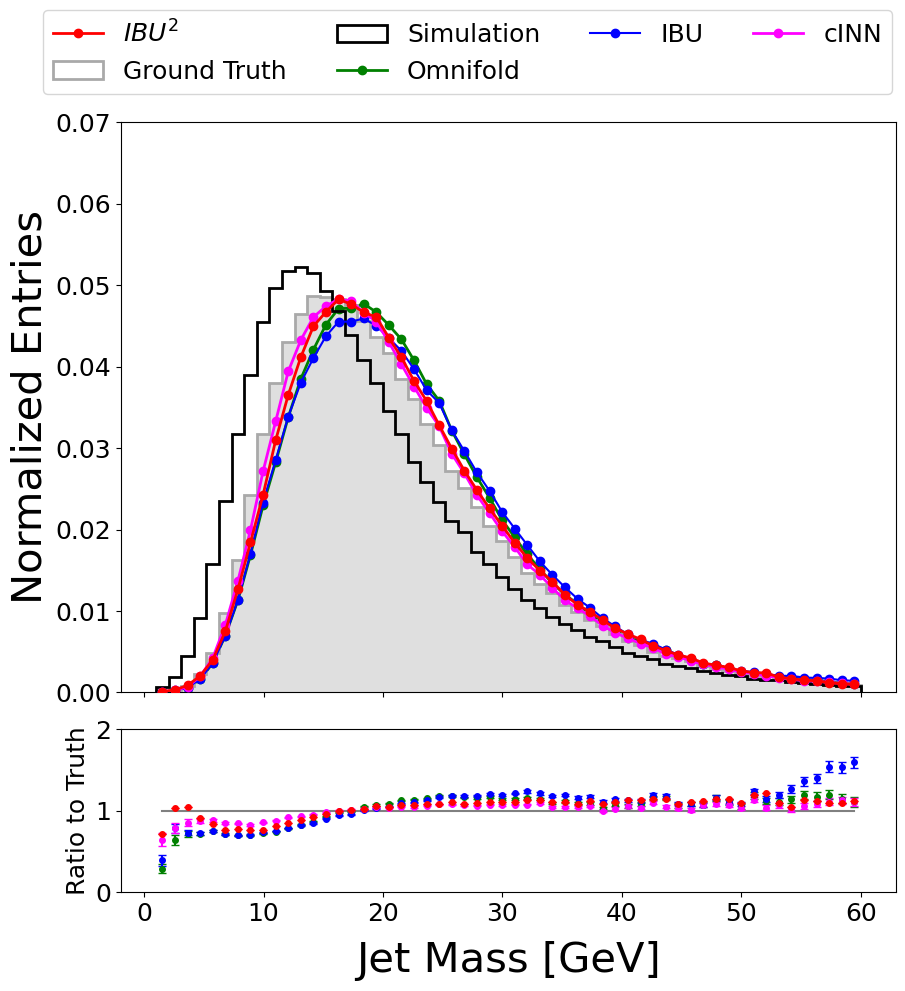

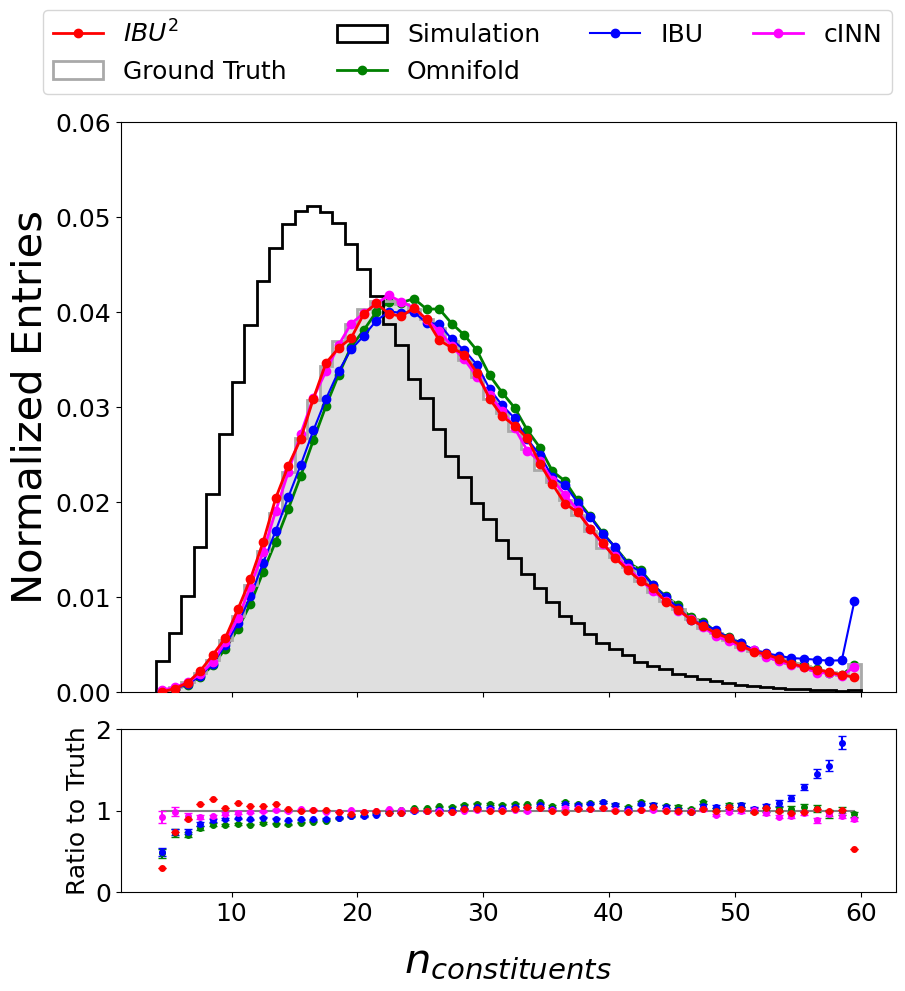

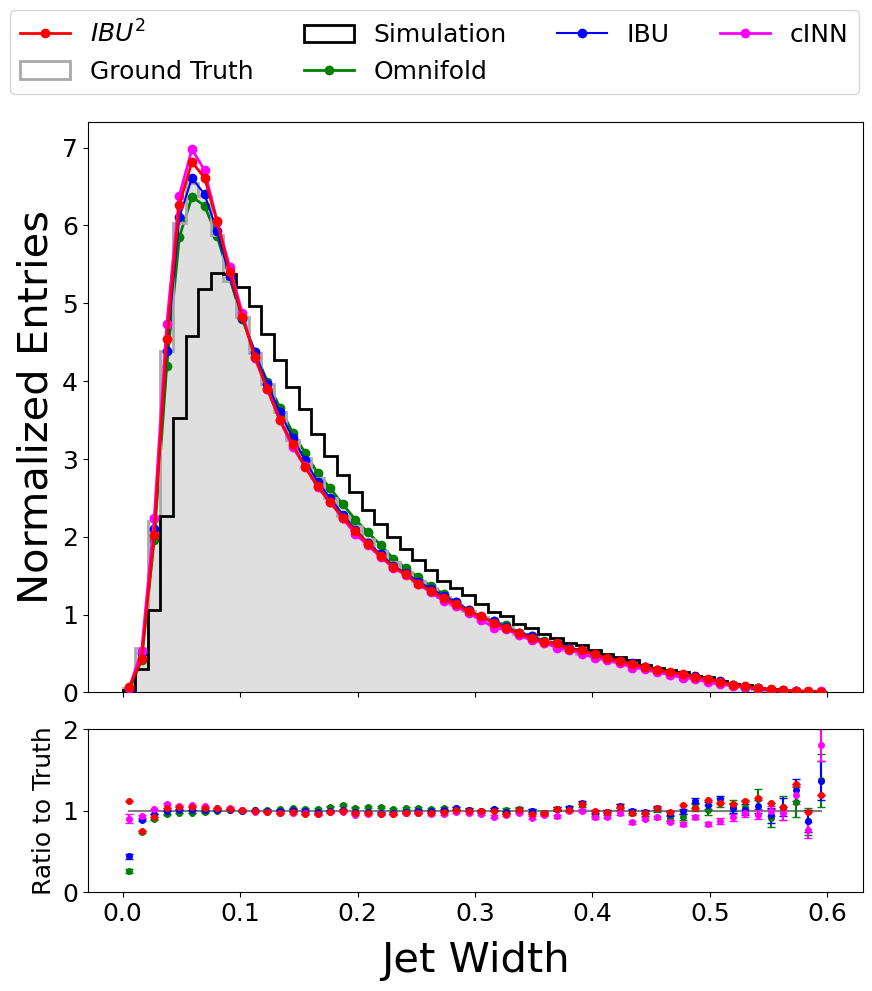

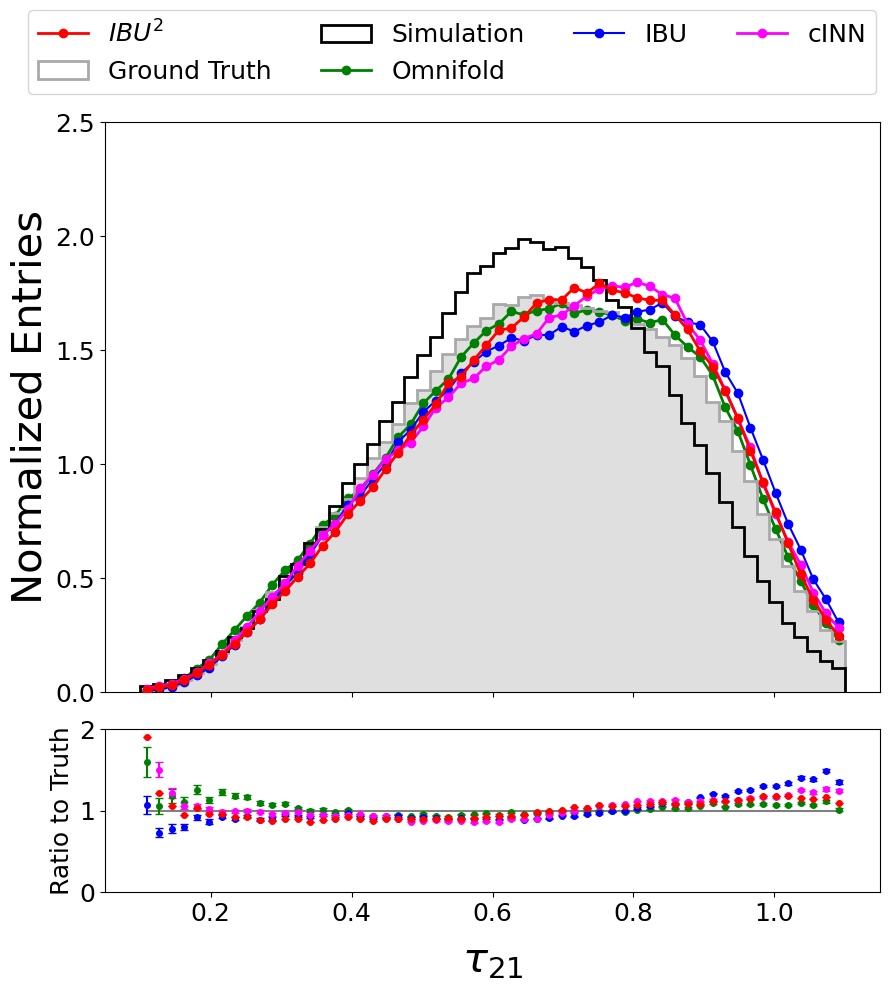

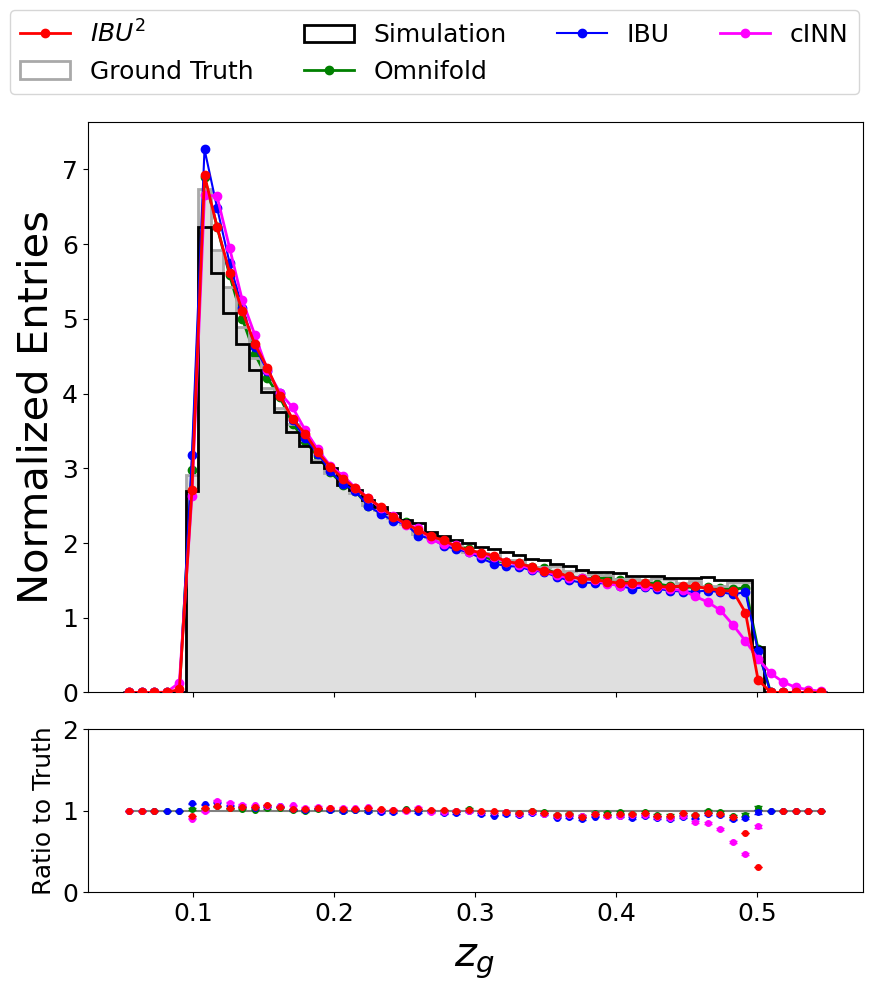

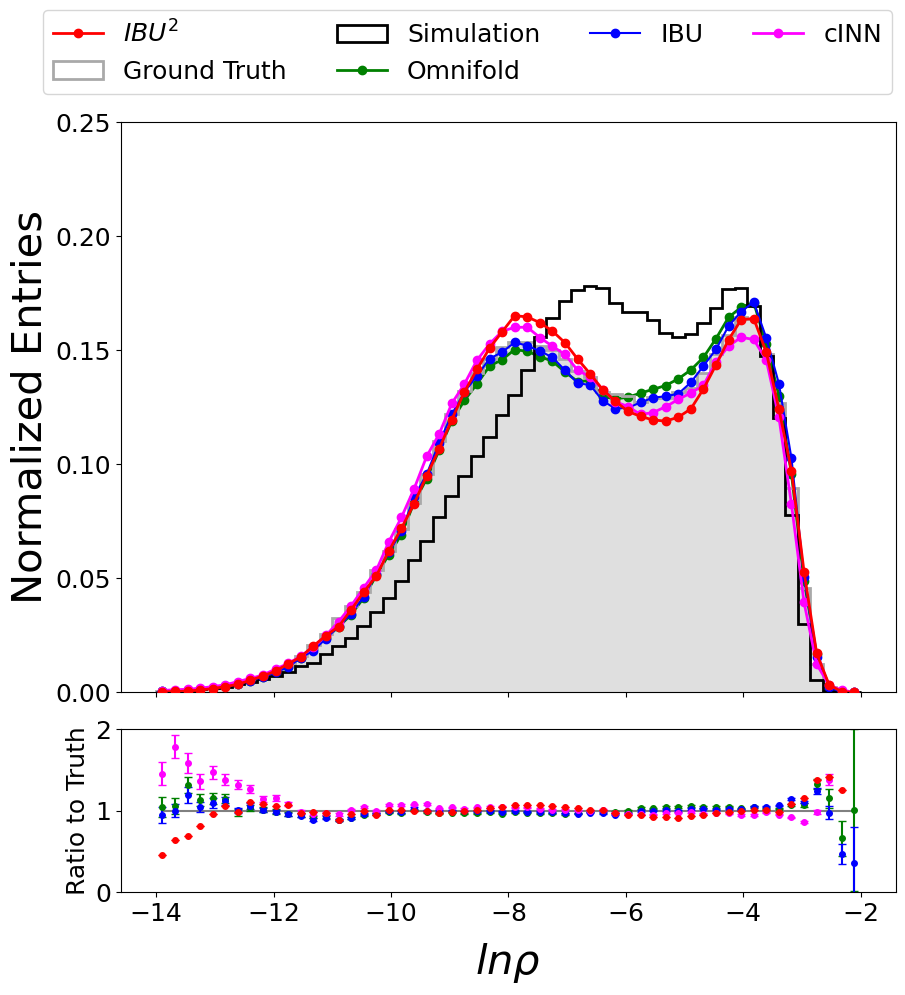

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import argparse
from dataloader.create_data import return_data, create_dictionary
from ibu import run_ibu
import arviz
from utils import load_MCMC
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Two Functions from SBUnfold https://github.com/ViniciusMikuni/SBUnfold/tree/main
def LoadJson(file_name,base_folder='JSON'):
    import json,yaml
    JSONPATH = os.path.join(base_folder,file_name)
    return yaml.safe_load(open(JSONPATH))

def ReversePreprocessing(data,fname,base_folder):
    data_dict = LoadJson(fname,base_folder)
    #data = (np.array(data_dict['max']) - data_dict['min']) * data + data_dict['min']
    data = data * data_dict['std'] + data_dict['mean']
    data[:,2] = np.round(data[:,2]) #particle multiplicity should be an integer
    return data


# mcmc = df[['Mass_pred', 'Mult_pred', 'Width_pred', 'tau21_pred', 'zg_pred',
#    'log_rho_pred']].to_numpy()
# truth = df[['Mass_truth', 'Mult_truth',
#        'Width_truth', 'tau21_truth', 'zg_truth', 'log_rho_truth']].to_numpy()

omnifold_ws = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\weights.npy")
of_data = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\omnifold_Pythia.npy")

of_data = ReversePreprocessing(of_data,'gen_features.json','JSON')
of_data = of_data[:,[0,2,1,5,4,3]]

cinn_data = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\inn_Herwig.npy")
cinn_data = ReversePreprocessing(cinn_data,'gen_features.json','JSON')
cinn_data = cinn_data[:,[0,2,1,5,4,3]]
print('Creating Data.')
N_t= 1000000
N_v = 600000
augment = False

data,scaler = return_data(N_t=N_t,N_v=N_v,constrain=True,augment=augment)

gen_features        = data['gen_features'][N_t:]
sim_features        = data['sim_features'][N_t:]
sim_herwig          = data['sim_herwig'][N_t:]
gen_herwig          = data['gen_herwig'][N_t:]

nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]

#mcmc,truth = load_MCMC(args.mcmc_path)
#mcmc = pred_gen
#truth = truth_gen
sigma = np.zeros_like(mcmc[:,0])
binning = dict(binning)
print(' ')
print('Running IBU.')
obs = create_dictionary(gen_features,sim_features,gen_herwig,sim_herwig)
obs = run_ibu(obs,itnum=3,binning=binning)

feature_names = np.array(["Jet Mass [GeV]","Jet Width", "$n_{constituents}$",r"$ln\rho$","$z_g$",r"$\tau_{21}$"])
feature_names = feature_names[[0,2,1,5,4,3]]


ylims = [
    ('Mass',(0,0.07)), # Mass
    ('Width',None), # Width
    ('Mult',(0,0.06)), # Multi
    ('log_rho',(0,0.25)), # lnp
    ('zg',None), # Zg
    ('tau21',(0,2.5)), # Tau21
]
ylims = dict(ylims)

cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]

for i in range(len(obs.keys())):
    key = cols[i]
    print('Plotting ',key)

    fig,ax = plt.subplots(2,figsize=(10,10),sharey=False,sharex=True,gridspec_kw={'height_ratios':(3.5,1),'hspace':0.1})
    ax[1].set_ylim(0,2)
    ax = ax.ravel()
    q = truth[:,i]#[key]
    omni = of_data[:,i]
    bins = binning[key]
    g = mcmc[:,i]#[key]
    cinn = cinn_data[:,i]
    herwig_reco = sim_herwig[:,i]
    #s = sigmas[:,i]

    omni_hist,b = np.histogram(omni,bins=bins,weights=omnifold_ws,density=True)
    digits = np.digitize(omni,b)
    errs = np.asarray([np.linalg.norm(omnifold_ws[digits==i]) for i in range(1, len(b))])
    omni_uncer = errs / (omnifold_ws.sum() *(b[1] - b[0]))


    cinn_hist,b = np.histogram(cinn,bins=bins,weights=np.ones_like(cinn),density=True)
    alea_cinn = np.histogram(cinn,bins=bins,weights=np.ones_like(cinn),density=False)[0]
    alea_cinn = np.sqrt(alea_cinn)/(alea_cinn.sum() * (b[1] - b[0]))

#     histograms = np.zeros((g.shape[1], len(bins) - 1))
#     alea_hists = np.zeros((g.shape[1], len(bins) - 1))

#     for j in range(g.shape[1]):
#         bootstrap_sample = g[:,j]
#         if j % 100 == 0:
#             print(j,"/",g.shape[1])
#         if key == 'Mult':
#             bootstramp_sample = bootstrap_sample.round()

#         histogram, _ = np.histogram(bootstrap_sample, bins=bins,density=True,range=[bins[0],bins[-1]])
#         alea_hist,_  = np.histogram(bootstrap_sample, bins=bins,density=False,range=[bins[0],bins[-1]])
#         histograms[j, :] = histogram
#         alea_hists[j,:] = alea_hist

    #hdi_results = arviz.hdi(histograms, hdi_prob=0.95)
    #hdi_lower = hdi_results[:,0].T
    #hdi_upper = hdi_results[:,1].T
    epi = 0#(hdi_upper - hdi_lower)/4.

    mean_histogram,_ = np.histogram(g,bins=bins,density=True)#np.mean(histograms, axis=0)
    mean_alea,_ = np.histogram(g,bins=bins,density=False)#np.mean(alea_hists,axis=0)
    #alea = np.sqrt(mean_alea)/(mean_alea.sum() * (bins[1] - bins[0]))

    epi = 0#sigma

    weights = np.ones_like(q)
    ref_hist,_ = np.histogram(q,bins=bins,weights=np.ones_like(q),density=True)

    ratio = mean_histogram / (ref_hist + 1e-50)
    idx = np.where(mean_histogram == ref_hist)
    ratio[idx] = 1.0

    quad = 0#np.sqrt(epi**2 + alea**2)
    ratio_error =  quad / (ref_hist + 1e-50)
    xaxis = [(bins[i] + bins[i+1])/2.0 for i in range(len(bins)-1)]

    bin_centers = (bins[:-1] + bins[1:]) / 2
    ibu_hist = obs[key]['ibu_phis'][3]
    ibu_ratio = ibu_hist / (ref_hist + 1e-50)
    idx = np.where(ibu_hist == ref_hist)
    ibu_ratio[idx] = 1.0
    ibu_unc_ratio = obs[key]['ibu_phi_unc']/(ref_hist + 1e-50)

    omni_ratio = omni_hist / (ref_hist + 1e-50)
    idx = np.where(omni_hist == ref_hist)
    omni_ratio[idx] = 1.0
    omni_ratio_err = omni_uncer / (ref_hist +1e-50)

    cinn_ratio = cinn_hist / (ref_hist + 1e-50)
    idx = np.where(cinn_hist == ref_hist)
    cinn_ratio[idx] = 1.0
    cinn_ratio_error = alea_cinn / (ref_hist + 1e-50)

    # Plots only our model
    #ax[0].fill_between(bin_centers, mean_histogram - 3*quad,mean_histogram + 3*quad, color='red', alpha=0.4, label=r'$\pm 3\sigma_{quad.}$')
    ax[0].plot(bin_centers,mean_histogram,color='red',label=r'$IBU^2$',linestyle='-',zorder=4,linewidth=2,marker='o')
    ax[1].errorbar(bin_centers,ratio,yerr=ratio_error,color='red',ls='none',capsize=3,marker='.',ms=8,label=r'$IBU^2$',zorder=4)

    ax[0].hist(q,bins=bins,color='grey',label='Ground Truth',histtype='step',density=True,linewidth=2,alpha=1.0,facecolor='grey',edgecolor='darkgrey')
    ax[0].hist(q,bins=bins,color='grey',alpha=0.25,density=True)
    ax[1].plot(bin_centers,np.ones_like(bins[:-1]),color='grey')
    ax[0].hist(herwig_reco,bins=bins,color='k',label='Simulation',histtype='step',density=True,linewidth=2)

    # Plots omnifold, cINN IBU
    ax[0].plot(bin_centers,omni_hist,color='green',label='Omnifold',linestyle='-',linewidth=2,zorder=1,marker='o')
    ax[1].errorbar(bin_centers,omni_ratio,yerr=omni_ratio_err,color='green',ls='none',capsize=3,marker='.',ms=8,label='Omnifold')

    ax[0].plot(obs[key]['midbins_mc'],obs[key]['ibu_phis'][3],color='blue',linestyle='-',label='IBU',marker='o')
    ax[1].errorbar(bin_centers,ibu_ratio,yerr=ibu_unc_ratio,color='blue',ls='none',capsize=3,marker='.',ms=8,label='IBU')

    ax[0].plot(bin_centers,cinn_hist,color='magenta',label='cINN',linestyle='-',linewidth=2,zorder=3,marker='o')
    ax[1].errorbar(bin_centers,cinn_ratio,yerr=cinn_ratio_error,color='magenta',ls='none',capsize=3,marker='.',ms=8,label='cINN')

    if ylims[key] is not None:
        ax[0].set_ylim(ylims[key])
    else:
        ax[0].set_ylim(bottom=0.0)

    ax[1].set_xlabel(feature_names[i],fontsize=30)
    ax[1].xaxis.set_label_coords(.5, -0.3)
    ax[0].set_ylabel('Normalized Entries',fontsize=30)
    ax[0].legend(loc=(-.1,1.05),fontsize=18,ncol=4)
    ax[1].set_ylabel('Ratio to Truth',fontsize=18)
    ax[1].xaxis.set_tick_params(labelsize=18)
    ax[1].yaxis.set_tick_params(labelsize=18)
    ax[0].yaxis.set_tick_params(labelsize=18)
    #plt.savefig(r"Inference\Plots\{}_Jan22.pdf".format(key))



In [5]:
print(np.mean(gen_features,axis=0))
print(np.std(gen_features,axis=0))

[20.51151672  0.123526   24.79842293 -7.24238154  0.23527388  0.73429609]
[9.68097812 0.09426895 9.75897896 2.16909888 0.11417768 0.21088903]


In [6]:
print(np.mean(sim_features,axis=0))
print(np.std(sim_features,axis=0))

[17.20905664  0.14202238 17.70690125 -6.86321936  0.24552679  0.67621814]
[9.58766174 0.09533006 7.72215227 2.02326158 0.11603605 0.20118436]


In [32]:
import scipy.stats as stats

stats.mstats.mquantiles(train_gen_features)

array([ 0.09103974,  0.43168536, 15.43676987])

In [33]:
train_gen_features.shape

(1000000, 6)

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_gen_features[:1000])

PCA(n_components=2)

In [36]:
b = pca.transform(train_gen_features[:1000])

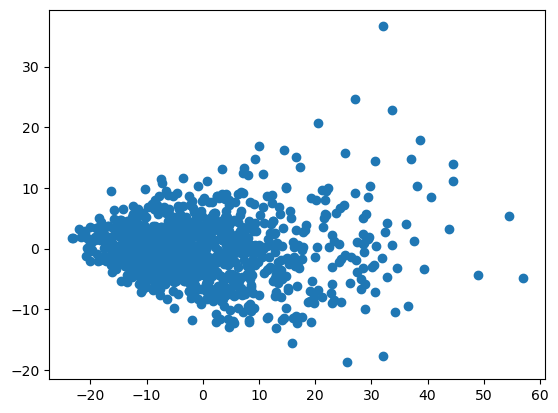

In [38]:
plt.scatter(b[:,0],b[:,1])

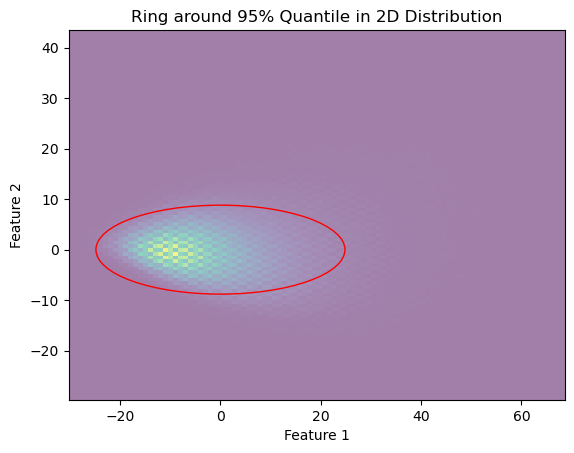

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_gen_features)

# Sample data (replace this with your own 2D dataset)
data = pca.transform(train_gen_features)

# Define tail thresholds (95% quantile)
upper_percentile = 95
upper_threshold = np.percentile(data, upper_percentile, axis=0)

# Visualize the 2D distribution
plt.hist2d(data[:, 0], data[:, 1], alpha=0.5,bins=100)

# Plot the ellipse around the 95% quantile
ellipse = Ellipse(xy=np.mean(data, axis=0), width=2 * (upper_threshold[0] - np.mean(data[:, 0])),
                  height=2 * (upper_threshold[1] - np.mean(data[:, 1])), edgecolor='red', facecolor='none')
plt.gca().add_patch(ellipse)

plt.title('Ring around 95% Quantile in 2D Distribution')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [46]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

# Assuming train_gen_features is your 6D dataset
data = train_gen_features[:10000]

# Step 1: Perform PCA on the original dataset
pca = PCA(n_components=2)
pca.fit(data)
data_2d = pca.transform(data)

# Step 2: Calculate quantiles in the projected 2D space
lower_quantile, upper_quantile = np.percentile(data_2d, [5, 95], axis=0)

# Step 3: Oversample the tailed regions
weights = np.ones(len(data))  # Initialize weights to 1
tail_mask = np.logical_or(data_2d[:, 0] < lower_quantile[0], data_2d[:, 1] > upper_quantile[1])
weights[tail_mask] = 2  # Assign higher weights to samples in tailed regions


In [152]:
np.sqrt(train_gen_features.dot(train_gen_features))

ValueError: shapes (1000000,6) and (1000000,6) not aligned: 6 (dim 1) != 1000000 (dim 0)

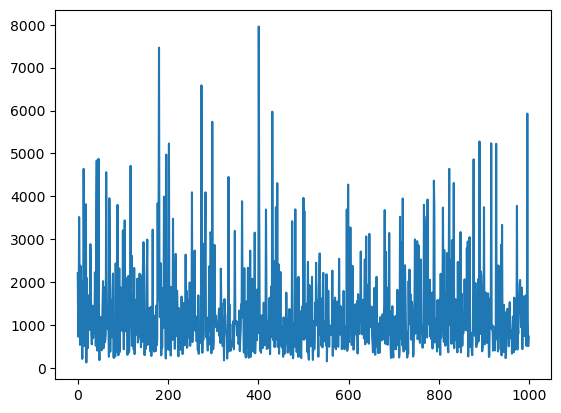

In [159]:
plt.plot(np.sum(train_gen_features * train_gen_features,1)[:1000])

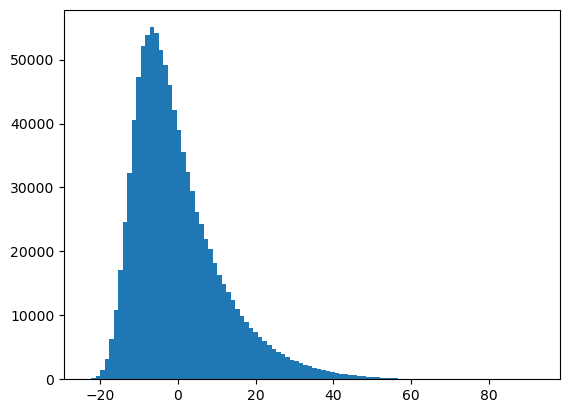

In [166]:
plt.hist(data_1d,bins=100)
plt.show()

In [174]:
tail_mask.flatten()

array([False, False, False, ..., False, False, False])

In [107]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from sklearn.manifold import TSNE

# Assuming train_gen_features is your 6D dataset
data = gen_features

# Step 1: Perform PCA on the original dataset
pca = PCA(n_components=1)
pca.fit(data)
data_1d = pca.transform(data)

# Step 2: Calculate quantiles in the projected 2D space
#sigma = np.std(data_1d)
#mu = np.mean(data_1d)
#upper_quantile = mu + 10*sigma
#lower_quantile = mu - 10*sigma
upper_quantile = np.percentile(data_1d,97.5)
lower_quantile = np.percentile(data_1d,2.5)

# Step 3: Identify samples in the tailed regions
tail_mask = np.logical_or(data_1d < lower_quantile, data_1d > upper_quantile).flatten()#data_2d[:,1] < lower_quantile[0], data_2d[:,1] > upper_quantile[1])

# Step 4: Calculate weights inversely proportional to the counts in tailed regions
tail_counts = np.sum(tail_mask)
weights = np.ones(len(data))  # Initialize weights to 1
weights[tail_mask] = 1.0  # Make weights inversely proportional to counts in tailed regions
weights[~tail_mask] = 0.
# Now, 'weights' can be used during sampling to oversample the tailed regions


In [211]:
np.mean(train_sim_features,axis=0)

array([17.20559393, 17.706677  ,  0.14202599,  0.67633648,  0.24549737,
       -6.86158443])

In [100]:
cols

array(['Mass', 'Mult', 'Width', 'tau21', 'zg', 'log_rho'], dtype='<U7')

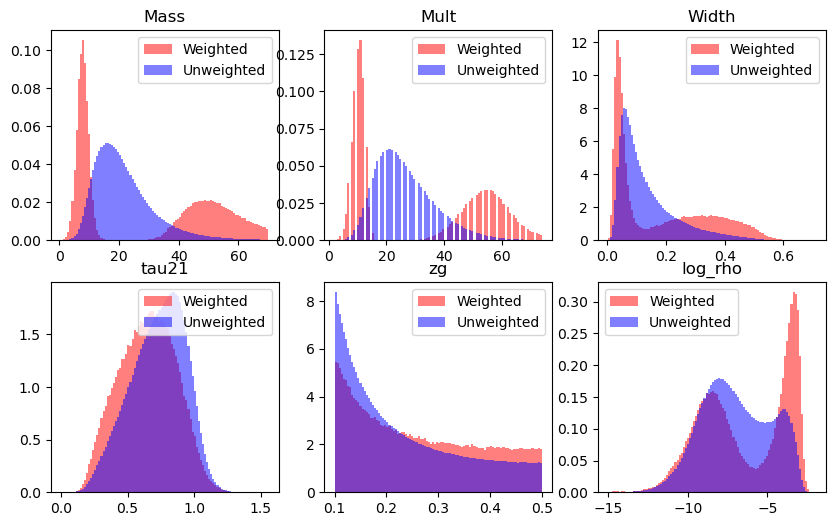

In [108]:
fig, ax = plt.subplots(2,3,figsize=(10,6))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].hist(gen_features[:,i],bins=100,weights=weights,density=True,alpha=0.5,label='Weighted',color='red')
    ax[i].hist(gen_features[:,i],bins=100,density=True,alpha=0.5,label='Unweighted',color='blue')
    #lt.xlim(-14,-12)
    ax[i].legend()
    ax[i].set_title(cols[i])
plt.show()

In [126]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

In [127]:
test = torch.utils.data.TensorDataset(torch.tensor(train_gen_features),torch.tensor(train_sim_features))
test = torch.utils.data.DataLoader(test,batch_size=100,sampler=sampler)
test_un = torch.utils.data.DataLoader(test,batch_size=100)

In [130]:
for i,data in enumerate(test):
    a = data[0].numpy()
    b = data[1].numpy()
    if i == 10:
        break

(array([ 4.,  8., 10., 16., 13., 12.,  6.,  6., 16.,  9.]),
 array([-12.08027234, -11.16999849, -10.25972464,  -9.34945079,
         -8.43917695,  -7.5289031 ,  -6.61862925,  -5.70835541,
         -4.79808156,  -3.88780771,  -2.97753387]),
 <BarContainer object of 10 artists>)

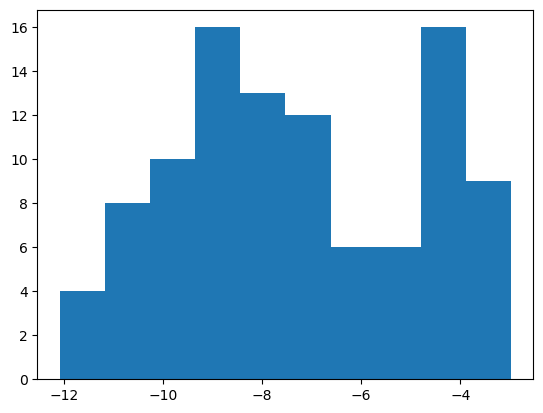

In [131]:
plt.hist(a[:,5])

In [1]:
import numpy as np
import os
import energyflow as ef
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pandas as pd
import collections

def create_dataset(sample_name="Pythia26",
               N_t=1000000,N_v=600000,
               cache_dir="/global/cfs/cdirs/m3929/I2SB/"):

    datasets = {sample_name: ef.zjets_delphes.load(sample_name, num_data=N_t+N_v,
                                                   cache_dir=cache_dir,exclude_keys=['particles'])}
    feature_names = ['widths','mults','sdms','zgs','tau2s']
    gen_features = [datasets[sample_name]['gen_jets'][:,3]]
    sim_features = [datasets[sample_name]['sim_jets'][:,3]]

    for feature in feature_names:
        gen_features.append(datasets[sample_name]['gen_'+feature])
        sim_features.append(datasets[sample_name]['sim_'+feature])

    gen_features = np.stack(gen_features,-1)
    sim_features = np.stack(sim_features,-1)
    #ln rho
    gen_features[:,3] = 2*np.ma.log(np.ma.divide(gen_features[:,3],datasets[sample_name]['gen_jets'][:,0]).filled(0)).filled(0)
    sim_features[:,3] = 2*np.ma.log(np.ma.divide(sim_features[:,3],datasets[sample_name]['sim_jets'][:,0]).filled(0)).filled(0)
    #tau2
    gen_features[:,5] = gen_features[:,5]/(10**-50 + gen_features[:,1])
    sim_features[:,5] = sim_features[:,5]/(10**-50 + sim_features[:,1])

#     # Preselection cuts - just basic and loose.

#     if 'Pythia' in sample_name:
#         cols = ["Mass","Width", "Mult","log_rho","zg","tau21"]
#         cols = cols + [name+"_sim" for name in cols]
#         print("Applying cuts on Gen. and Sim. for "+ sample_name)
#         temp = pd.DataFrame(np.concatenate([gen_features,sim_features],axis=1),columns = cols)
#         #temp = temp[(temp.zg > 0.1) & (temp.zg_sim > 0.1) & (temp.Mass < 70) & (temp.Mass_sim < 100) & (temp.log_rho > -15) & (temp.log_rho_sim > -20) & (temp.Mult < 75) & (temp.Mult_sim < 100) & (temp.Mass > 0)]
#         temp = temp[(temp.zg > 0.1) & (temp.zg_sim > 0.1) & (temp.Mass < 70) & (temp.Mass_sim < 70) & (temp.log_rho > -15) & (temp.log_rho_sim > -14) & (temp.Mult < 75) & (temp.Mult_sim < 60) & (temp.Mass > 0) & (temp.tau21_sim < 1.35) & (temp.Width_sim < 0.6)]
#         gen_features = temp[cols[:6]].to_numpy()
#         sim_features = temp[cols[6:]].to_numpy()

#         # Cut out negative masses from the generations.
#     if sample_name == 'Herwig':
#         print("Cutting negative masses from Herwig generations.")
#         cols = ["Mass","Width", "Mult","log_rho","zg","tau21"]
#         cols = cols + [name+"_sim" for name in cols]
#         # In reality these cuts dont matter being that we constrain Herwig. Sim to the domain of pythia anyways.
#         temp = pd.DataFrame(np.concatenate([gen_features,sim_features],axis=1),columns = cols)
#         temp = temp[temp.Mass > 0]
#         gen_features = temp[cols[:6]].to_numpy()
#         sim_features = temp[cols[6:]].to_numpy()

    return gen_features,sim_features

In [7]:
gen_features26,sim_features26 = create_dataset(sample_name="Pythia26",N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")
gen_features25,sim_features25 = create_dataset(sample_name="Pythia25",N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")
gen_features21,sim_features21 = create_dataset(sample_name="Pythia21",N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")
gen_herwig,sim_herwig = create_dataset(sample_name='Herwig',N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")

In [16]:
gen_features26 = pd.DataFrame(gen_features26,columns=["Mass","Width", "Mult","log_rho","zg","tau21"])
gen_features25 = pd.DataFrame(gen_features25,columns=["Mass","Width", "Mult","log_rho","zg","tau21"])
gen_features21 = pd.DataFrame(gen_features21,columns=["Mass","Width", "Mult","log_rho","zg","tau21"])

sim_features26 = pd.DataFrame(sim_features26,columns=["Mass","Width", "Mult","log_rho","zg","tau21"])
sim_features25 = pd.DataFrame(sim_features25,columns=["Mass","Width", "Mult","log_rho","zg","tau21"])
sim_features21 = pd.DataFrame(sim_features21,columns=["Mass","Width", "Mult","log_rho","zg","tau21"])

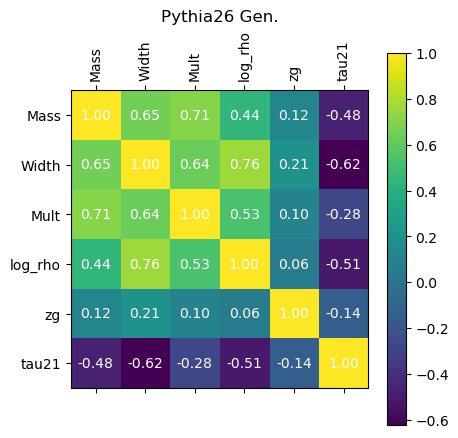

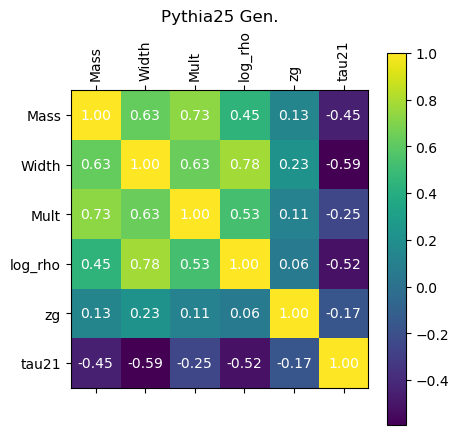

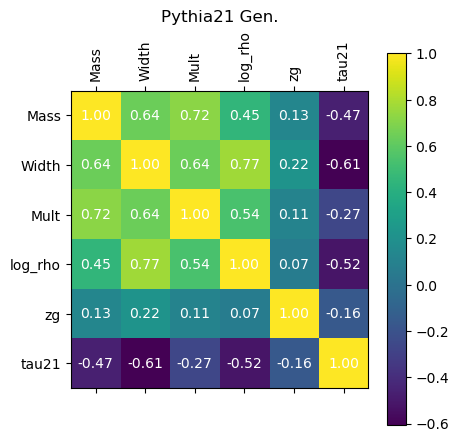

In [26]:
import matplotlib.pyplot as plt
plt.matshow(gen_features26.corr())
plt.xticks(range(len(gen_features26.columns)), gen_features26.columns, rotation='vertical')
plt.yticks(range(len(gen_features26.columns)), gen_features26.columns)
for i in range(len(gen_features26.columns)):
    for j in range(len(gen_features26.columns)):
        plt.text(j, i, f"{gen_features26.corr().iloc[i, j]:.2f}", ha='center', va='center', color='w')

plt.colorbar()
plt.title('Pythia26 Gen.')
plt.show()

plt.matshow(gen_features25.corr())
plt.xticks(range(len(gen_features25.columns)), gen_features25.columns, rotation='vertical')
plt.yticks(range(len(gen_features25.columns)), gen_features25.columns)
for i in range(len(gen_features25.columns)):
    for j in range(len(gen_features25.columns)):
        plt.text(j, i, f"{gen_features25.corr().iloc[i, j]:.2f}", ha='center', va='center', color='w')

plt.colorbar()
plt.title('Pythia25 Gen.')
plt.show()

plt.matshow(gen_features21.corr())
plt.xticks(range(len(gen_features21.columns)), gen_features21.columns, rotation='vertical')
plt.yticks(range(len(gen_features21.columns)), gen_features21.columns)
for i in range(len(gen_features21.columns)):
    for j in range(len(gen_features21.columns)):
        plt.text(j, i, f"{gen_features21.corr().iloc[i, j]:.2f}", ha='center', va='center', color='w')

plt.colorbar()
plt.title('Pythia21 Gen.')
plt.show()

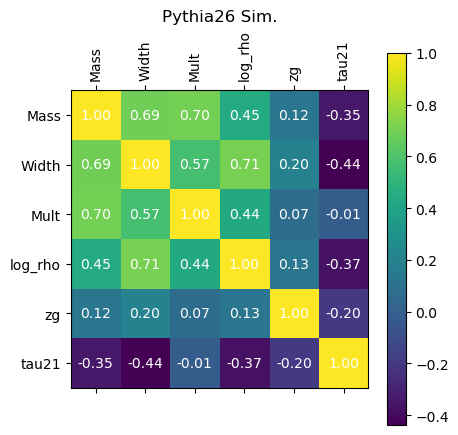

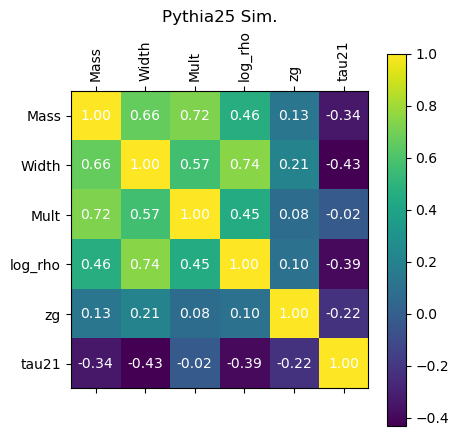

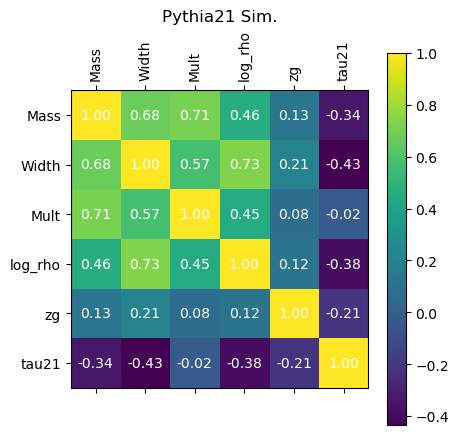

In [27]:
# Function to create a correlation matrix plot and display numbers
def plot_corr_matrix(df, title):
    plt.matshow(df.corr(), cmap='viridis')
    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
    plt.yticks(range(len(df.columns)), df.columns)
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            plt.text(j, i, f"{df.corr().iloc[i, j]:.2f}", ha='center', va='center', color='w')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Plot for sim_features26
plot_corr_matrix(sim_features26, 'Pythia26 Sim.')

# Plot for sim_features25
plot_corr_matrix(sim_features25, 'Pythia25 Sim.')

# Plot for sim_features21
plot_corr_matrix(sim_features21, 'Pythia21 Sim.')

array([[<AxesSubplot:title={'center':'Mass'}>,
        <AxesSubplot:title={'center':'Mult'}>],
       [<AxesSubplot:title={'center':'Width'}>,
        <AxesSubplot:title={'center':'tau21'}>],
       [<AxesSubplot:title={'center':'zg'}>,
        <AxesSubplot:title={'center':'log_rho'}>]], dtype=object)

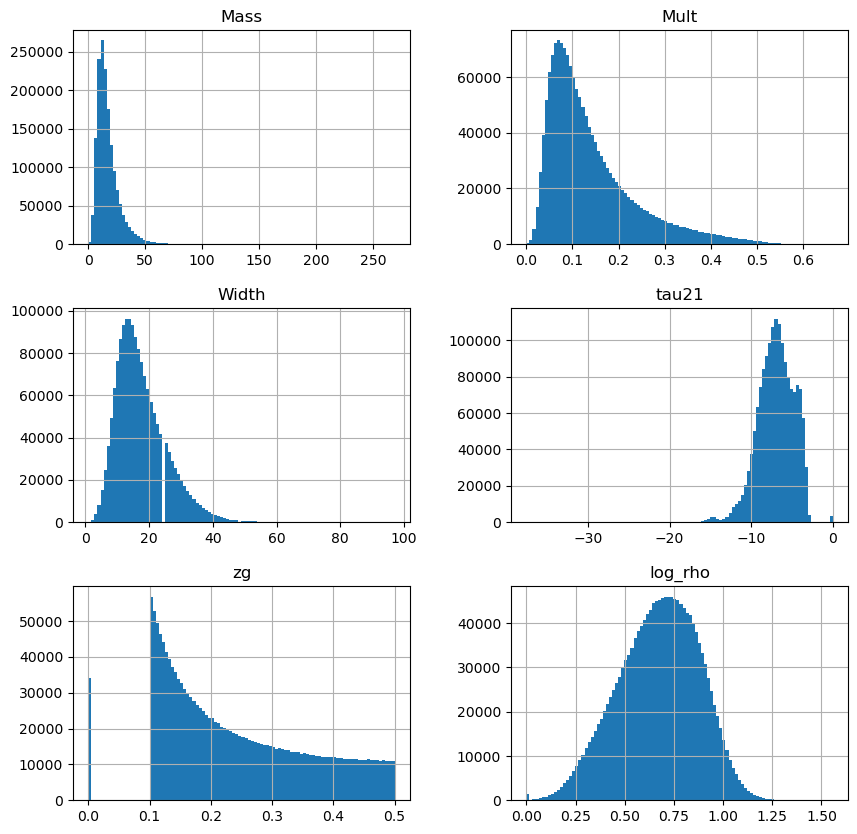

In [38]:
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
train_sim_features = pd.DataFrame(sim_features,columns=cols)
train_sim_features.hist(figsize=(10,10),bins=100)

In [29]:
obs = {'Mass':None, 'Mult':None, 'Width':None, 'tau21':None, 'zg':None, 'log_rho':None}
mcmc_dict = {'Mass':None, 'Mult':None, 'Width':None, 'tau21':None, 'zg':None, 'log_rho':None}
truth_dict = {'Mass':None, 'Mult':None, 'Width':None, 'tau21':None, 'zg':None, 'log_rho':None}
for i,key in enumerate(obs.keys()):
    mcmc_dict[key] = pred_gen[:,i]
    truth_dict[key] = truth_gen[:,i]

Mult
Width
tau21
zg
log_rho
Mass


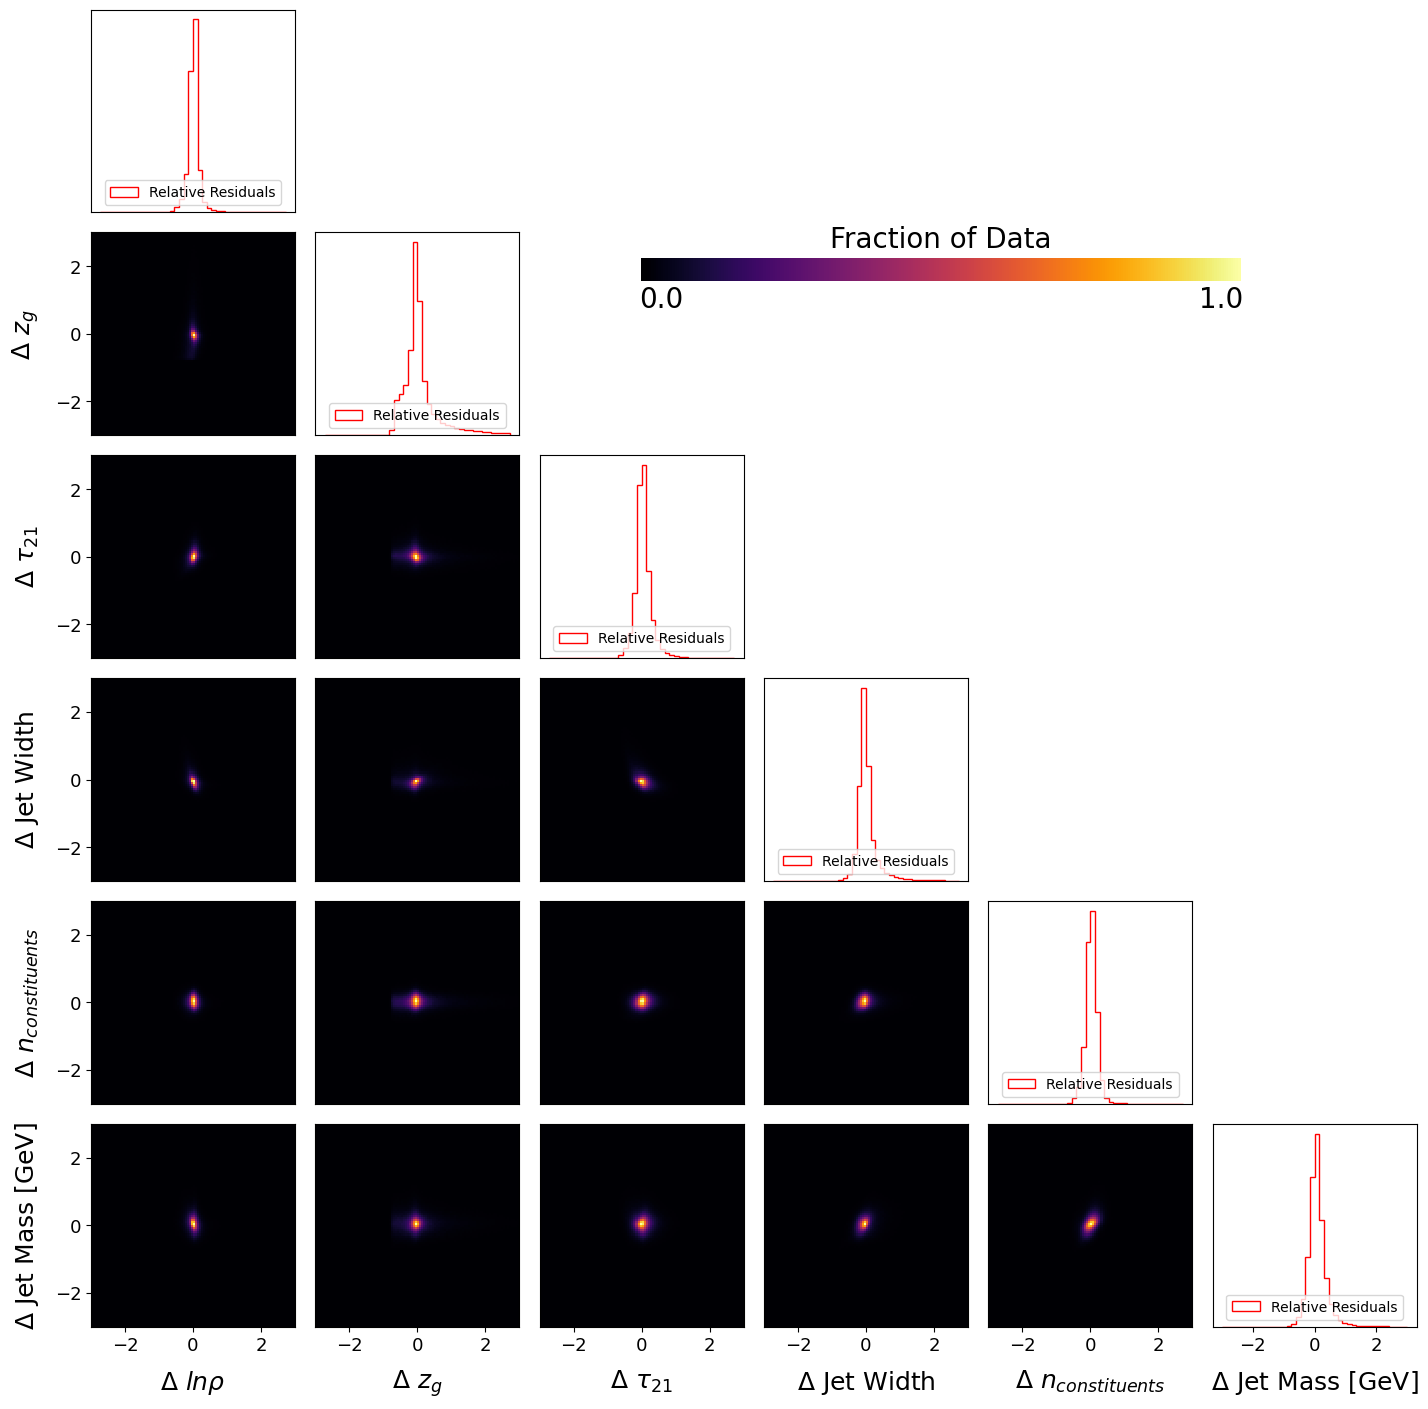

In [32]:

def create_cbar(fig):
    gradient= np.linspace(0, 1, 256).reshape(1, -1)
    gradient = np.concatenate([gradient for _ in range(10)])

    ax_cbar_reds = fig.add_axes([0.4, 0.65, 0.3, 0.2])
    ax_cbar_reds.imshow(gradient, cmap='inferno')
    ax_cbar_reds.axis('off')

    fig.text(0.41, 0.735, '0.0', ha='center', va='center', fontsize=20)
    fig.text(0.69, 0.735, '1.0', ha='center', va='center', fontsize=20)
    fig.text(0.55, 0.765, 'Fraction of Data', ha='center', va='center', fontsize=20)

def plot_corr_res(x, y,x2,y2, x_label, y_label, ax, bins, cmap,i,j):
    res_x = (x - x2) / (x2 + 1e-10)
    res_y = (y - y2) / (y2 + 1e-10)
    x_range = (-3, 3)
    y_range = (-3, 3)

    hist, x_edges, y_edges = np.histogram2d(res_x, res_y, bins=100, range=[x_range, y_range])
    freq = hist / np.sum(hist)
    ax.pcolormesh(x_edges,y_edges,freq.T,cmap='inferno')

    ticks = False

    if i == 0 and j in [5,4,3,2,1]:
        ax.set_ylabel(y_label, fontsize=18,labelpad=10)
        ax.tick_params(axis='y', which='both', labelsize=13)
        ticks = True
    if j == 5:
        ax.set_xlabel(x_label,fontsize=18,labelpad=10)
        ax.tick_params(axis='x', which='both', labelsize=13,rotation=0)
        ticks = True

    if i == 0 and j != 5:
        ax.set_xticks([])

    if i in [1,2,3,4] and j == 5:
        ax.set_yticks([])

    if not ticks:
        ax.set_xticks([])
        ax.set_yticks([])


def plot_histograms(x, y,ax,key):
    print(key)
    ax.hist((x-y)/(y+1e-10),bins=40,color='red',label='Relative Residuals',histtype='step',density=True,linewidth=1,range=[-3,3])
    if key == 'Mass':
        ax.tick_params(axis='x', which='both', labelsize=13)
        ax.set_xlabel(r"$\Delta$ Jet Mass [GeV]",fontsize=18,labelpad=10)
        ax.set_xticks([-2,0,2])
        ax.set_yticks([])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    ax.legend(loc='lower center')


def create_subplot(i, j, data1, data2, x_label, y_label, bins, cmap1, cmap2):
    ax = plt.subplot2grid((7, 7), (5-j, 5- i), colspan=1, rowspan=1)
    plot_corr_res(data1[0],data1[1],data2[0], data2[1], x_label, y_label, ax, bins, cmap1,5-i,5-j)
    if i == 5 and j == 4:
        ax_hist_x = plt.subplot2grid((7, 7), (0, 0), colspan=1, rowspan=1)
        plot_histograms(data1[0],data2[0],ax_hist_x,'log_rho')
    if i == 4 and j == 3:
        ax_hist_x = plt.subplot2grid((7, 7), (1, 1), colspan=1, rowspan=1)
        plot_histograms(data1[0],data2[0],ax_hist_x,'zg')
    if i == 3 and j == 2:
        ax_hist_x = plt.subplot2grid((7, 7), (2, 2), colspan=1, rowspan=1)
        plot_histograms(data1[0],data2[0],ax_hist_x,'tau21')
    if i == 2 and j == 1:
        ax_hist_x = plt.subplot2grid((7, 7), (3, 3), colspan=1, rowspan=1)
        plot_histograms(data1[0],data2[0],ax_hist_x,'Width')
    if i == 1 and j == 0:
        ax_hist_x = plt.subplot2grid((7, 7), (4, 4), colspan=1, rowspan=1)
        plot_histograms(data1[0],data2[0],ax_hist_x,'Mult')

nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]



binning = dict(binning)

feature_names = np.array([r"$\Delta$ Jet Mass [GeV]",r"$\Delta$ Jet Width", r"$\Delta$ $n_{constituents}$",r"$\Delta$ $ln\rho$",r"$\Delta$ $z_g$",r"$\Delta$ $\tau_{21}$"])
feature_names = feature_names[[0,2,1,5,4,3]]

cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]

obs = {'Mass':None, 'Mult':None, 'Width':None, 'tau21':None, 'zg':None, 'log_rho':None}

fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(6):
    out_key = list(mcmc_dict.keys())[i]
    out_bins = binning[out_key]
    for j in range(i + 1):
        in_key = list(mcmc_dict.keys())[j]
        if out_key == in_key:
            continue
        else:
            bins = [out_bins, binning[in_key]]
            create_subplot(i, j, [mcmc_dict[out_key],mcmc_dict[in_key]], [truth_dict[out_key],truth_dict[in_key]], feature_names[i], feature_names[j], bins, 'Reds', 'Greys')

# Append Final Histogram
data1 = mcmc_dict['Mass']
data2 = truth_dict['Mass']
bins = binning['Mass']
ax_hist_x = plt.subplot2grid((7, 7), (5, 5), colspan=1, rowspan=1)
plot_histograms(data1,data2,ax_hist_x,'Mass')
create_cbar(fig)


In [10]:
from utils import load_MCMC
import pandas as pd
import numpy as np

mcmc,truth = load_MCMC(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\metro_chains1k")

Loading MCMC.
125/126 [==================>.] - ETA: 1s

In [11]:
df = pd.read_csv(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\Inference.csv",sep=',',index_col=None)

preds = df[['Mass_pred', 'Mult_pred', 'Width_pred', 'tau21_pred', 'zg_pred',
       'log_rho_pred']]
#truth = df[['Mass_truth', 'Mult_truth',
#       'Width_truth', 'tau21_truth', 'zg_truth', 'log_rho_truth']]
sigmas = df[['Mass_sigma', 'Mult_sigma', 'Width_sigma',
       'tau21_sigma', 'zg_sigma', 'log_rho_sigma']]

In [12]:
sigmas

Mass_sigma  Mult_sigma  Width_sigma  tau21_sigma  zg_sigma  \
0         0.699090    0.773830     0.005439     0.013850  0.004458   
1         0.935900    0.861055     0.006735     0.016041  0.004628   
2         0.920640    0.721560     0.005248     0.011021  0.003648   
3         0.626799    0.469718     0.004096     0.010130  0.002768   
4         1.475000    1.133138     0.012881     0.022538  0.006450   
...            ...         ...          ...          ...       ...   
574827    0.809283    0.559933     0.004491     0.010740  0.003170   
574828    0.630674    0.374623     0.003324     0.008326  0.002217   
574829    0.922660    0.675991     0.005636     0.015195  0.003405   
574830    0.801730    0.739861     0.006389     0.015658  0.005202   
574831    0.496795    0.451193     0.003924     0.009580  0.002650   

        log_rho_sigma  
0            0.161226  
1            0.105398  
2            0.118769  
3            0.078994  
4            0.225938  
...               ...  
574827       0.095296  
574828       0.075901  
574829       0.086894  
574830       0.197675  
574831       0.086027  

[574832 rows x 6 columns]

In [15]:
mcmc.keys()

dict_keys(['Mass', 'Mult', 'Width', 'tau21', 'zg', 'log_rho'])

In [17]:
std_list = {'Mass':None, 'Mult':None, 'Width':None, 'tau21':None, 'zg':None, 'log_rho':None}
for key in mcmc.keys():
    print(key)
    std_temp = []
    for i in range(len(mcmc[key])):
        std_temp.append(mcmc[key][i].std())
        
    std_list[key] = std_temp

Mass
Mult
Width
tau21
zg
log_rho


In [22]:
sigmas

Mass_sigma  Mult_sigma  Width_sigma  tau21_sigma  zg_sigma  \
0         0.699090    0.773830     0.005439     0.013850  0.004458   
1         0.935900    0.861055     0.006735     0.016041  0.004628   
2         0.920640    0.721560     0.005248     0.011021  0.003648   
3         0.626799    0.469718     0.004096     0.010130  0.002768   
4         1.475000    1.133138     0.012881     0.022538  0.006450   
...            ...         ...          ...          ...       ...   
574827    0.809283    0.559933     0.004491     0.010740  0.003170   
574828    0.630674    0.374623     0.003324     0.008326  0.002217   
574829    0.922660    0.675991     0.005636     0.015195  0.003405   
574830    0.801730    0.739861     0.006389     0.015658  0.005202   
574831    0.496795    0.451193     0.003924     0.009580  0.002650   

        log_rho_sigma  
0            0.161226  
1            0.105398  
2            0.118769  
3            0.078994  
4            0.225938  
...               ...  
574827       0.095296  
574828       0.075901  
574829       0.086894  
574830       0.197675  
574831       0.086027  

[574832 rows x 6 columns]

In [30]:
std_list.keys()

dict_keys(['Mass', 'Mult', 'Width', 'tau21', 'zg', 'log_rho'])

Mass
Mult
Width
tau21
zg
log_rho


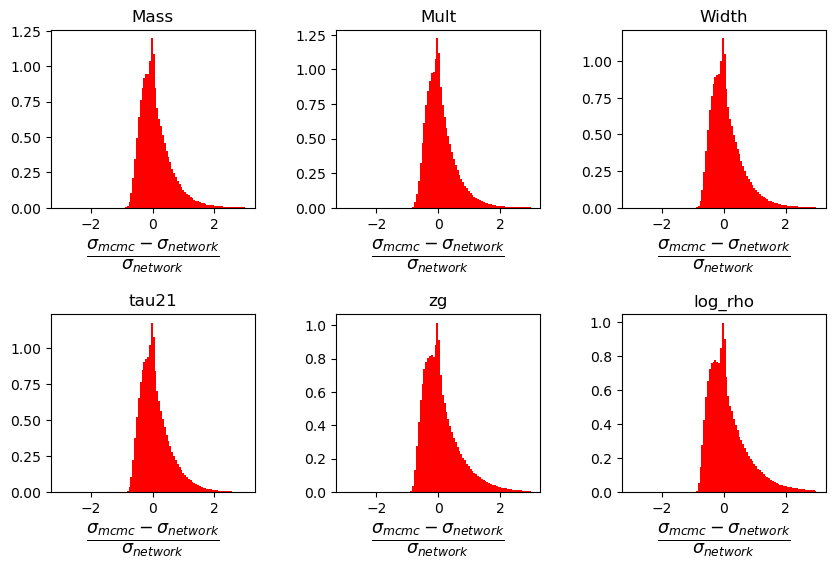

In [44]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(2,3,figsize=(10,6))
plt.subplots_adjust(wspace=0.4,hspace=0.6)
ax = ax.ravel()

for i,key in enumerate(std_list.keys()):
    network_sigma = sigmas[key+"_sigma"]
    mcmc_sigma = std_list[key]
    print(key)
    x = (mcmc_sigma - network_sigma)/(network_sigma + 1e-50)
    
    ax[i].hist(x,bins=100,range=[-3,3],density=True,color='red')
    ax[i].set_title(key)
    ax[i].set_xlabel(r"$\frac{\sigma_{mcmc} - \sigma_{network}}{\sigma_{network}}$",fontsize=18)
    

In [56]:
import numpy as np
a = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\vector_state\MCMC_batch0_78_Node0_completed.pkl",allow_pickle=True)

In [66]:
np.vstack(a['trace_1'])

array([[ 31.57964448,  21.41843883,   0.0835932 ,   0.46479933,
          0.1498491 , -10.8441329 ],
       [ 31.57964448,  21.41843883,   0.0835932 ,   0.46479933,
          0.1498491 , -10.8441329 ],
       [ 31.38294336,  22.48365683,   0.0439363 ,   0.42422934,
          0.17385353, -10.64171081],
       ...,
       [ 30.05678303,  21.12272814,   0.19737771,   0.61721155,
          0.24998299, -10.88023414],
       [ 30.05678303,  21.12272814,   0.19737771,   0.61721155,
          0.24998299, -10.88023414],
       [ 29.59178351,  21.88499079,   0.0498096 ,   0.50944791,
          0.16566548, -10.42210206]])

In [69]:
a['trace_1'][100:]

[array([ 28.37314788,  20.16043421,   0.0724432 ,   0.40369431,
          0.29431451, -10.8466213 ]),
 array([ 28.37314788,  20.16043421,   0.0724432 ,   0.40369431,
          0.29431451, -10.8466213 ]),
 array([ 28.37314788,  20.16043421,   0.0724432 ,   0.40369431,
          0.29431451, -10.8466213 ]),
 array([ 28.37314788,  20.16043421,   0.0724432 ,   0.40369431,
          0.29431451, -10.8466213 ]),
 array([ 28.37314788,  20.16043421,   0.0724432 ,   0.40369431,
          0.29431451, -10.8466213 ]),
 array([ 28.37314788,  20.16043421,   0.0724432 ,   0.40369431,
          0.29431451, -10.8466213 ]),
 array([ 28.37314788,  20.16043421,   0.0724432 ,   0.40369431,
          0.29431451, -10.8466213 ]),
 array([ 28.37314788,  20.16043421,   0.0724432 ,   0.40369431,
          0.29431451, -10.8466213 ]),
 array([ 28.37314788,  20.16043421,   0.0724432 ,   0.40369431,
          0.29431451, -10.8466213 ]),
 array([ 28.27052659,  20.95671367,   0.18392598,   0.43740339,
          0.259391

In [70]:
a['truth_1']

array([18.66612244, 18.        ,  0.05538661,  0.67830756,  0.21997205,
       -9.99185007])

In [19]:
import os
import pandas as pd
file_list = os.listdir(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\vector_state")
path_ = r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\vector_state"

list_of_data = []
list_of_truth = []
for file in file_list:
    dicte = np.load(os.path.join(path_,file),allow_pickle=True)
    for key in dicte.keys():
        if "trace" in key:
            list_of_data.append(dicte[key])
        elif "truth" in key:
            list_of_truth.append(dicte[key])
        else:
            print("Something is wrong, check.")
    break

In [34]:
np.vstack(list_of_data[0])[:,0].shape

(1000,)

In [40]:
list_of_truth[0]

array([35.6044693 , 31.        ,  0.28755293,  0.27777499,  0.27187   ,
       -4.01553207])

In [15]:
import os 
import numpy as np
import pkbar

def load_MCMC_vectors(chains_dir):
    chains = os.listdir(chains_dir)
    mass = []
    mult = []
    width = []
    log_rho = []
    zg = []
    tau = []
    mass_truth = []
    mult_truth = []
    width_truth = []
    log_rho_truth = []
    zg_truth = []
    tau_truth = []

    print('Loading MCMC.')
    kbar = pkbar.Kbar(target=len(chains), width=20, always_stateful=False)
    #{'Mass':None, 'Mult':None, 'Width':None, 'tau21':None, 'zg':None, 'log_rho':None}
    for i,chain in enumerate(chains):
        file_path = os.path.join(chains_dir,chain)
        a = np.load(file_path,allow_pickle=True)
        for key in a.keys():
            if key.startswith('trace_'):
                data = np.vstack(a[key])
                mass.append(data[:,0].astype('float32'))
                mult.append(data[:,1].astype('float32'))
                width.append(data[:,2].astype('float32'))
                tau.append(data[:,3].astype('float32'))
                zg.append(data[:,4].astype('float32'))
                log_rho.append(data[:,5].astype('float32'))
            elif key.startswith('truth_'):
                data = a[key]
                mass_truth.append(data[0].astype('float32'))
                mult_truth.append(data[1].astype('float32'))
                width_truth.append(data[2].astype('float32'))
                tau_truth.append(data[3].astype('float32'))
                zg_truth.append(data[4].astype('float32'))
                log_rho_truth.append(data[5].astype('float32'))

            else:
                print('Something is wrong')

        kbar.update(i)

    mass = np.array(mass)
    mult = np.array(mult)
    width = np.array(width)
    log_rho = np.array(log_rho)
    zg = np.array(zg)
    tau = np.array(tau)

    mass_truth = np.array(mass_truth)
    mult_truth = np.array(mult_truth)
    width_truth = np.array(width_truth)
    log_rho_truth = np.array(log_rho_truth)
    zg_truth = np.array(zg_truth)
    tau_truth = np.array(tau_truth)

    return {'Mass':mass,'Mult':mult,'Width':width,'tau21':tau,'zg':zg,'log_rho':log_rho},{'Mass':mass_truth,'Mult':mult_truth,'Width':width_truth,'tau21':tau_truth,'zg':zg_truth,'log_rho':log_rho_truth}


In [16]:
mcmc,truth = load_MCMC_vectors(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\vector_state")

Loading MCMC.
125/126 [==================>.] - ETA: 3s

In [18]:
mcmc['Mass']

array([[34.913425, 34.913425, 34.913425, ..., 36.268517, 36.268517,
        36.268517],
       [28.52235 , 28.613405, 28.613405, ..., 30.479742, 30.479742,
        30.479742],
       [13.628436, 13.628436, 13.628436, ..., 13.53142 , 13.53142 ,
        13.53142 ],
       ...,
       [18.532494, 19.076992, 19.076992, ..., 19.90132 , 19.562431,
        19.562431],
       [14.639675, 14.639675, 14.458831, ..., 14.838912, 14.838912,
        14.838912],
       [46.868538, 46.868538, 46.868538, ..., 50.13294 , 50.51036 ,
        50.174088]], dtype=float32)

In [31]:
mcmc.keys()

dict_keys(['Mass', 'Mult', 'Width', 'tau21', 'zg', 'log_rho'])

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

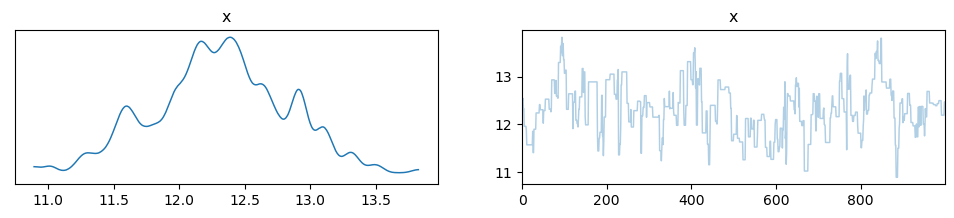

In [36]:
import arviz
arviz.plot_trace(arviz.convert_to_dataset(mcmc['Mass'][40]))

In [7]:
mcmc['Mass'].mean(1).shape

(565852,)

In [8]:
gen_herwig.shape

(575023, 6)

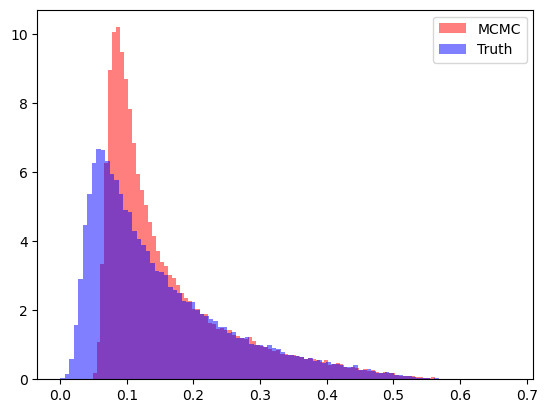

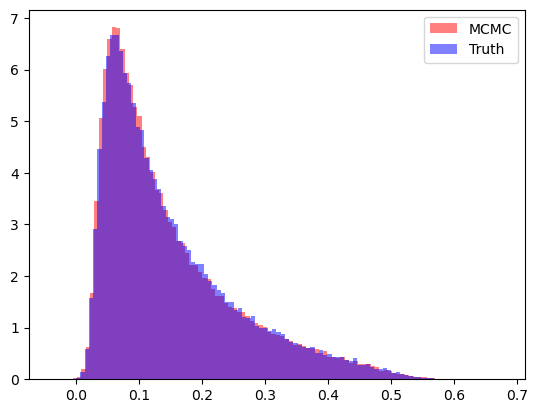

In [114]:
plt.hist(mcmc['Width'].mean(1),bins=100,alpha=0.5,color='red',label='MCMC',density=True)
plt.hist(truth['Width'],bins=100,alpha=0.5,color='blue',label='Truth',density=True)
plt.legend(loc='best')
plt.show()


plt.hist(df['Width_pred'][:len(mcmc['Width'].mean(1))],bins=100,alpha=0.5,color='red',label='MCMC',density=True)
plt.hist(df['Width_truth'][:len(mcmc['Width'].mean(1))],bins=100,alpha=0.5,color='blue',label='Truth',density=True)
plt.legend(loc='best')
plt.show()

In [48]:
idx = 1
print(mcmc['Width'][idx].mean())
print(truth['Width'][idx])

0.08954067
0.055386614


In [71]:
import pandas as pd

df = pd.read_csv(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\Inference.csv")

In [72]:
df

Mass_pred  Mult_pred  Width_pred  tau21_pred   zg_pred  log_rho_pred  \
0       35.642330  35.406986    0.286502    0.268849  0.275438     -4.002394   
1       28.821300  21.780298    0.070114    0.463649  0.167391    -10.756675   
2       14.174165  14.823996    0.031566    1.053888  0.294333     -9.857720   
3       27.280512  36.682350    0.082120    0.922352  0.173982     -8.552556   
4       14.962461   8.106608    0.173984    0.192307  0.123311     -4.602022   
...           ...        ...         ...         ...       ...           ...   
574827  21.088512  33.814526    0.120692    0.947740  0.178791     -9.052780   
574828  22.437240  18.067759    0.084406    0.836396  0.169959     -9.021965   
574829  17.854221  15.313891    0.068902    0.573364  0.201514    -10.860707   
574830  37.591846  49.962070    0.386724    0.634361  0.209442     -3.666285   
574831  38.295673  39.556484    0.135089    0.783635  0.108876     -6.453990   

        Mass_sigma  Mult_sigma  Width_sigma  tau21_sigma  zg_sigma  \
0         0.699090    0.773830     0.005439     0.013850  0.004458   
1         0.935900    0.861055     0.006735     0.016041  0.004628   
2         0.920640    0.721560     0.005248     0.011021  0.003648   
3         0.626799    0.469718     0.004096     0.010130  0.002768   
4         1.475000    1.133138     0.012881     0.022538  0.006450   
...            ...         ...          ...          ...       ...   
574827    0.809283    0.559933     0.004491     0.010740  0.003170   
574828    0.630674    0.374623     0.003324     0.008326  0.002217   
574829    0.922660    0.675991     0.005636     0.015195  0.003405   
574830    0.801730    0.739861     0.006389     0.015658  0.005202   
574831    0.496795    0.451193     0.003924     0.009580  0.002650   

        log_rho_sigma  Mass_truth  Mult_truth  Width_truth  tau21_truth  \
0            0.161226   35.604469        31.0     0.287553     0.277775   
1            0.105398   18.666122        18.0     0.055387     0.678308   
2            0.118769   14.545370        20.0     0.045579     0.982641   
3            0.078994   27.836571        42.0     0.122853     0.900382   
4            0.225938   15.214744        18.0     0.235622     0.660216   
...               ...         ...         ...          ...          ...   
574827       0.095296   24.297321        32.0     0.148574     0.695028   
574828       0.075901   39.147621        41.0     0.103523     1.127514   
574829       0.086894   14.224988        11.0     0.079572     0.523964   
574830       0.197675   36.502022        51.0     0.381227     0.664374   
574831       0.086027   29.438219        33.0     0.124851     0.763953   

        zg_truth  log_rho_truth  
0       0.271870      -4.015532  
1       0.219972      -9.991850  
2       0.290605      -8.888219  
3       0.153920      -5.927355  
4       0.138650      -4.719399  
...          ...            ...  
574827  0.217577      -8.426348  
574828  0.491543      -9.130478  
574829  0.215879     -10.470945  
574830  0.273875      -3.709669  
574831  0.130883      -5.796250  

[574832 rows x 18 columns]

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 5.000e+00, 1.000e+01, 1.200e+01, 8.000e+00,
        1.200e+01, 4.300e+01, 8.000e+01, 1.640e+02, 3.530e+02, 6.140e+02,
        9.550e+02, 1.318e+03, 1.160e+03, 8.370e+02, 6.190e+02, 4.940e+02,
        3.810e+02, 3.250e+02, 2.990e+02, 2.480e+02, 1.980e+02, 1.830e+02,
        1.480e+02, 1.520e+02, 1.180e+02, 1.190e+02, 9.800e+01, 9.700e+01,
        7.900e+01, 6.600e+01, 6.700e+01, 5.700e+01, 5.500e+01, 4.400e+01,
        4.800e+01, 3.600e+01, 3.700e+01, 2.500e+01, 2.600e+01, 2.100e+01,
        2.100e+01, 2.100e+01, 2.700e+0

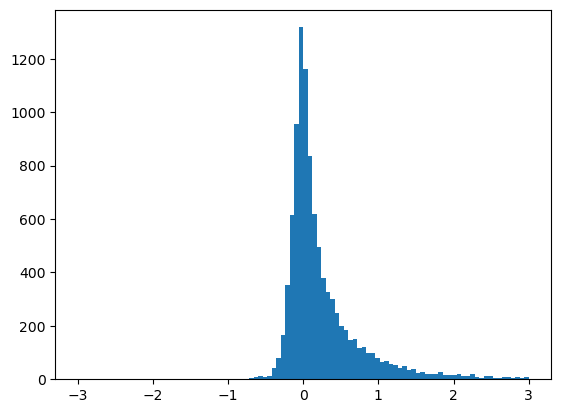

In [83]:
plt.hist((mcmc['Width'].mean(1) - truth['Width'])/ (truth['Width']),bins=100,range=[-3,3])

In [142]:
import numpy as np
from scipy.stats import uniform

def joint_likelihood(x, mu, cov_matrix):
    exponent = -0.5 * (x - mu).T @ np.linalg.inv(cov_matrix) @ (x - mu)
    normalization = 1 / np.sqrt((2 * np.pi)**len(mu) * np.linalg.det(cov_matrix))
    likelihood = np.exp(exponent) * normalization
    return likelihood

def joint_prior(x_values, lower_bounds, upper_bounds):
    if all(lower <= x <= upper for x, lower, upper in zip(x_values, lower_bounds, upper_bounds)):
        probability = 1.0
        for x, lower, upper in zip(x_values, lower_bounds, upper_bounds):
            probability *= uniform.pdf(x, loc=lower, scale=upper-lower)
        return probability
    else:
        return 0.0

def proposal_distribution(mean, cov_matrix):
    sample = np.random.multivariate_normal(mean, cov_matrix)
    return sample

def metropolis_hastings(initial_sample,sigma,num_samples,prior_lower,prior_upper):
    samples = []
    mu = initial_sample
    sigma = sigma
    current_sample = initial_sample
    while len(samples) < num_samples:
        proposal = proposal_distribution(current_sample,sigma)
        numerator = joint_likelihood(proposal,mu,sigma) * joint_prior(proposal,prior_lower,prior_upper)
        denominator = joint_likelihood(current_sample,mu,sigma) * joint_prior(current_sample,prior_lower,prior_upper)

        if (joint_prior(proposal,prior_lower,prior_upper) == 0.0) & (joint_prior(current_sample,prior_lower,prior_upper) != 0.0):
            samples.append(current_sample)

        elif (joint_prior(proposal,prior_lower,prior_upper) == 0.0) & (joint_prior(current_sample,prior_lower,prior_upper) == 0.0):
            continue

        else:
            delta_log = np.log(numerator+1e-50) - np.log(denominator+1e-50)
            acceptance_ratio = min(1,np.exp(delta_log))
            if np.random.rand() < acceptance_ratio:
                samples.append(proposal)
                current_sample = proposal
            else:
                samples.append(current_sample)

    return samples



def run_MCMC(mu, sigma,prior_lower, prior_upper, batch_start, batch_end,node,truth):
    traces = {}
    burn_in = 3000
    np.random.seed(752022)
    print(prior_lower,prior_upper)
    num_samples = 1000
    for i in range(len(mu)):
        print(mu[i].shape)
        true_mean = mu[i]
        true_std = sigma[i]
        true = truth[i]
        mcmc = metropolis_hastings(initial_sample = true_mean,sigma=true_std,num_samples=burn_in + num_samples,prior_lower=prior_lower,prior_upper=prior_upper)

        traces[f'trace_{i}'] = mcmc[burn_in:]
        traces[f'truth_{i}'] = true
        print('Done')
        break

    return traces

In [125]:
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
mu = df[[col+"_pred" for col in cols]].to_numpy()
sigma = df[[col+"_sigma" for col in cols]].to_numpy()
truth = df[[col+"_truth" for col in cols]].to_numpy()

In [53]:
mu = df['Events']
sigma = df['Covariance']
truth = df['Truth']

In [143]:
prior_lowers = [0.,0.,0.,0.,0.1,-20]
prior_uppers = [90.,80.,1.0,1.8,0.5,-1.]

samples = run_MCMC(mu[0:10],sigma[0:10],prior_lowers,prior_uppers,0,0,0,truth[0:10])

[0.0, 0.0, 0.0, 0.0, 0.1, -20] [90.0, 80.0, 1.0, 1.8, 0.5, -1.0]
(6,)
Done


In [100]:
np.vstack(samples['trace_0']).shape

(10000, 6)

In [ ]:
plt.hist(np.vstack(samples['trace_0'])[:,])

In [86]:
mcmc.keys()

dict_keys(['Mass', 'Mult', 'Width', 'tau21', 'zg', 'log_rho'])

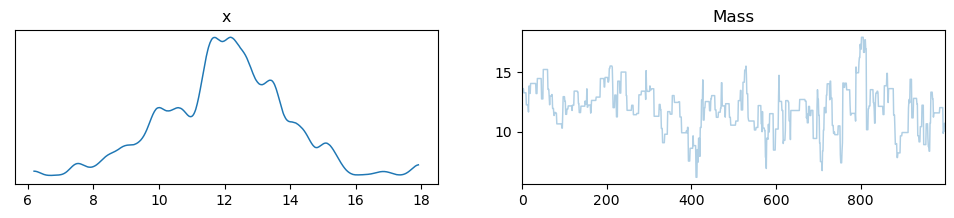

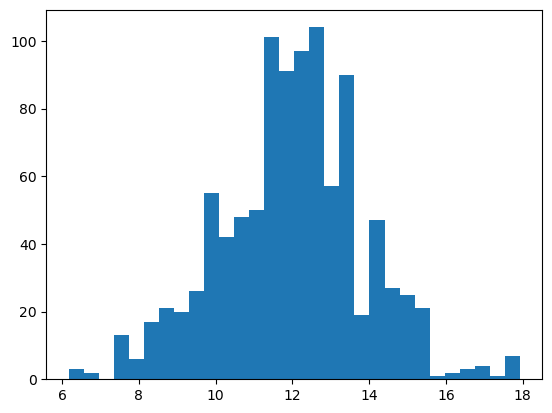

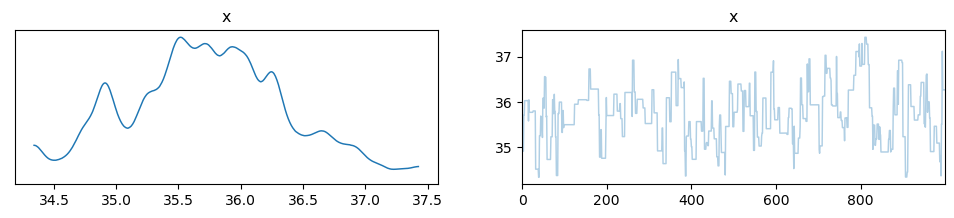

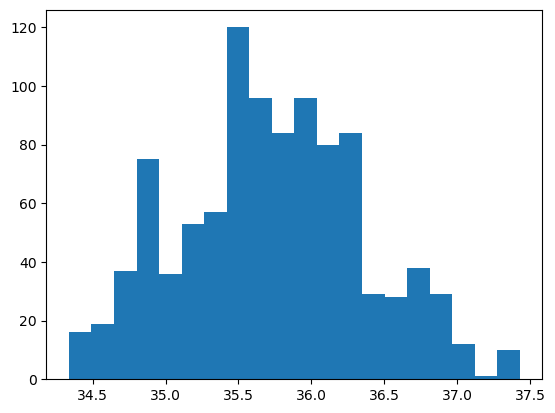

In [124]:
idx = 0
key = list(mcmc.keys())[idx]
arviz.plot_trace(arviz.convert_to_dataset(np.vstack(samples['trace_0'])[:,idx]))

# Get the current Axes
axes = plt.gca()

# Set the title
axes.set_title(cols[idx])

# Show the plot

plt.show()
plt.hist(np.vstack(samples['trace_0'])[:,idx],bins=30)
plt.show()


arviz.plot_trace(arviz.convert_to_dataset(mcmc[key][0]))
plt.show()

plt.hist(mcmc[key][0],bins=20)
plt.show()

<AxesSubplot:title={'center':'x\n0'}>

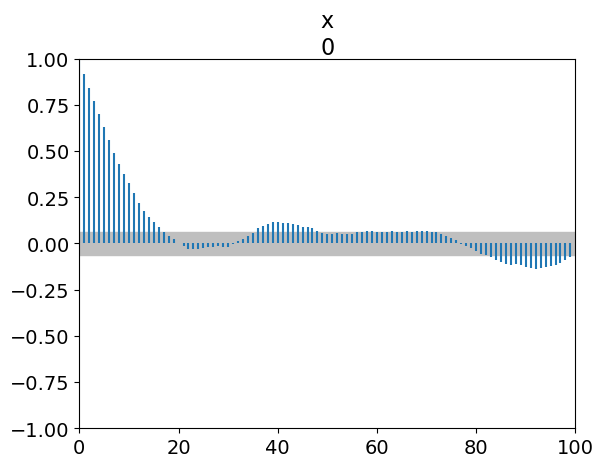

In [144]:
arviz.plot_autocorr(arviz.convert_to_dataset(np.vstack(samples['trace_0'])[:,idx]))

<AxesSubplot:title={'center':'x\n0'}>

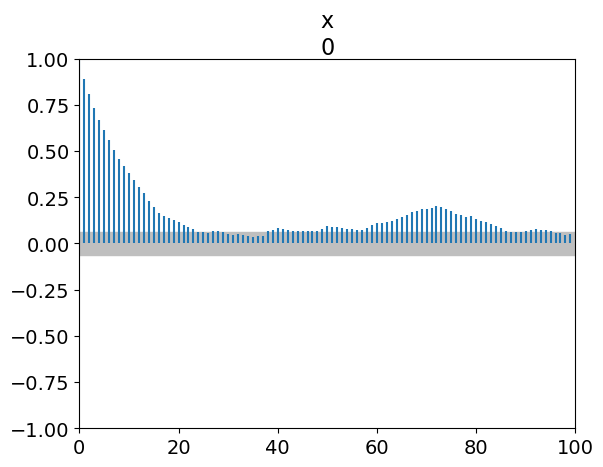

In [140]:
arviz.plot_autocorr(arviz.convert_to_dataset(mcmc[key][400]))

In [18]:
import pandas as pd

df = pd.read_csv(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\Inference.csv")

In [20]:
df['Mult_sigma']

0         0.773830
1         0.861055
2         0.721560
3         0.469718
4         1.133138
            ...   
574827    0.559933
574828    0.374623
574829    0.675991
574830    0.739861
574831    0.451193
Name: Mult_sigma, Length: 574832, dtype: float64

In [7]:
import numpy as np

a = np.random.normal(size=(50,6,6))


(50, 6, 6)

In [9]:
import pickle

# Specify the file path
file_path = r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\Inference_Covariance.pkl"

# Load the dictionary from the file
with open(file_path, 'rb') as file:
    obs = pickle.load(file)

In [11]:
obs['Events'].shape

(574832, 6)

In [25]:
obs['Covariance'][1]

array([[ 8.75999369e-01,  7.93335797e-02,  1.45839751e-03,
         4.20248070e-04,  4.89658719e-04, -6.15388968e-03],
       [ 7.93335797e-02,  7.41490665e-01, -8.31570414e-04,
        -6.89114135e-04,  1.64684091e-03,  2.23283992e-02],
       [ 1.45839751e-03, -8.31570414e-04,  4.53586754e-05,
        -4.54506664e-05, -2.74093609e-06, -7.50748695e-05],
       [ 4.20248070e-04, -6.89114135e-04, -4.54506664e-05,
         2.57336710e-04, -1.60360205e-05,  4.98054178e-04],
       [ 4.89658719e-04,  1.64684091e-03, -2.74093609e-06,
        -1.60360205e-05,  2.14249205e-05, -6.54529234e-05],
       [-6.15388968e-03,  2.23283992e-02, -7.50748695e-05,
         4.98054178e-04, -6.54529234e-05,  1.11097637e-02]])

In [24]:
obs['Covariance'][1].diagonal()

array([8.75999369e-01, 7.41490665e-01, 4.53586754e-05, 2.57336710e-04,
       2.14249205e-05, 1.11097637e-02])

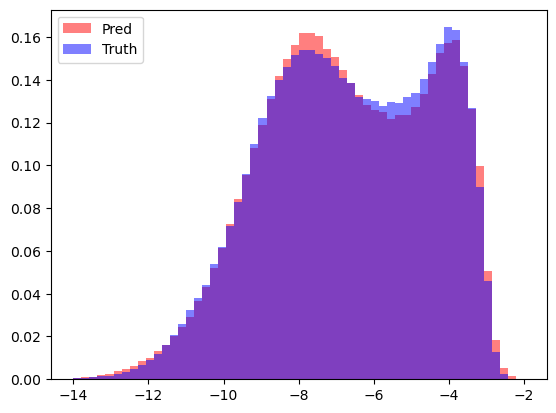

In [22]:
import matplotlib.pyplot as plt
import numpy as np

nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]
cols = ["Mass","Width", "Mult","log_rho","zg","tau21"]
cols = list(np.array(cols)[[0,2,1,5,4,3]])
binning = dict(binning)
idx = 5
bins = binning[cols[idx]]

plt.hist(obs['Events'][:,idx],bins=bins,alpha=0.5,color='red',label='Pred',density=True)
plt.hist(obs['Truth'][:,idx],bins=bins,alpha=0.5,color='blue',label='Truth',density=True)
plt.legend()
plt.show()

In [130]:
import energyflow as ef
from sklearn.decomposition import PCA

def augment_tails(gen_features):
    data = gen_features
    pca = PCA(n_components=1)
    pca.fit(data)
    data_1d = pca.transform(data)
    upper_quantile = np.percentile(data_1d,97.5)
    lower_quantile = np.percentile(data_1d,2.5)
    tail_mask = np.logical_or(data_1d < lower_quantile, data_1d > upper_quantile).flatten()#data_2d[:,1] < lower_quantile[0], data_2d[:,1] > upper_quantile[1])
    return tail_mask

def create_dataset(sample_name="Pythia26",
               N_t=1000000,N_v=600000,
               cache_dir="/global/cfs/cdirs/m3929/I2SB/"):

    datasets = {sample_name: ef.zjets_delphes.load(sample_name, num_data=N_t+N_v,
                                                   cache_dir=cache_dir,exclude_keys=['particles'])}
    feature_names = ['widths','mults','sdms','zgs','tau2s']
    gen_features = [datasets[sample_name]['gen_jets'][:,3]]
    sim_features = [datasets[sample_name]['sim_jets'][:,3]]

    for feature in feature_names:
        gen_features.append(datasets[sample_name]['gen_'+feature])
        sim_features.append(datasets[sample_name]['sim_'+feature])

    gen_features = np.stack(gen_features,-1)
    sim_features = np.stack(sim_features,-1)
    #ln rho
    gen_features[:,3] = 2*np.ma.log(np.ma.divide(gen_features[:,3],datasets[sample_name]['gen_jets'][:,0]).filled(0)).filled(0)
    sim_features[:,3] = 2*np.ma.log(np.ma.divide(sim_features[:,3],datasets[sample_name]['sim_jets'][:,0]).filled(0)).filled(0)
    #tau2
    gen_features[:,5] = gen_features[:,5]/(10**-50 + gen_features[:,1])
    sim_features[:,5] = sim_features[:,5]/(10**-50 + sim_features[:,1])

    # Preselection cuts - just basic and loose.

    if 'Pythia' in sample_name:
        cols = ["Mass","Width", "Mult","log_rho","zg","tau21"]
        cols = cols + [name+"_sim" for name in cols]
        print("Applying cuts on Gen. and Sim. for "+ sample_name)
        temp = pd.DataFrame(np.concatenate([gen_features,sim_features],axis=1),columns = cols)
        temp = temp[(temp.zg > 0.1) & (temp.zg_sim > 0.1) & (temp.Mass < 70) & (temp.Mass_sim < 100) & (temp.log_rho > -15) & (temp.log_rho_sim > -20) & (temp.Mult < 75) & (temp.Mult_sim < 100) & (temp.Mass > 0)]
        #temp = temp[(temp.zg > 0.1) & (temp.zg_sim > 0.1) & (temp.Mass < 70) & (temp.Mass_sim < 70) & (temp.log_rho > -15) & (temp.log_rho_sim > -14) & (temp.Mult < 75) & (temp.Mult_sim < 60) & (temp.Mass > 0) & (temp.tau21_sim < 1.35) & (temp.Width_sim < 0.6)]
        gen_features = temp[cols[:6]].to_numpy()
        sim_features = temp[cols[6:]].to_numpy()

        # Cut out negative masses from the generations.
    if sample_name == 'Herwig':
        print("Cutting negative masses from Herwig generations.")
        cols = ["Mass","Width", "Mult","log_rho","zg","tau21"]
        cols = cols + [name+"_sim" for name in cols]
        # In reality these cuts dont matter being that we constrain Herwig. Sim to the domain of pythia anyways.
        temp = pd.DataFrame(np.concatenate([gen_features,sim_features],axis=1),columns = cols)
        temp = temp[temp.Mass > 0]
        gen_features = temp[cols[:6]].to_numpy()
        sim_features = temp[cols[6:]].to_numpy()

    return gen_features,sim_features

def return_data(N_t=1000000,N_v=600000,constrain=True,augment=False):
    gen_features,sim_features = create_dataset(sample_name="Pythia26",N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")
    gen_herwig,sim_herwig = create_dataset(sample_name='Herwig',N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")

    if augment:
        pythia25_gen, pythia25_sim = create_dataset(sample_name="Pythia25",N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")
        pythia21_gen, pythia21_sim = create_dataset(sample_name="Pythia21",N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")
        temp_gen_features = np.concatenate([pythia25_gen,pythia21_gen],axis=0)
        temp_sim_features = np.concatenate([pythia25_sim,pythia21_sim],axis=0)
        tail_mask = augment_tails(temp_gen_features)
        print(np.sum(tail_mask))
        gen_features = np.concatenate([gen_features,temp_gen_features[tail_mask]],axis=0)
        sim_features = np.concatenate([sim_features,temp_sim_features[tail_mask]],axis=0)
        total_features = np.concatenate([gen_features,sim_features],axis=1)
        np.random.shuffle(total_features)
        gen_features = total_features[:,:6]
        sim_features = total_features[:,6:]

    scaler = MinMaxScaler((-1.,1.))
    if constrain:
            # Constrain herwig simulation -> drop generated pair (i.e., constrain gen)
            print("Constraining Herwig simulation to domain of Pythia.")
            sim_h = pd.DataFrame(sim_herwig,columns=["Mass","Width", "Mult","log_rho","zg","tau21"])
            sim_p = pd.DataFrame(sim_features,columns=["Mass","Width", "Mult","log_rho","zg","tau21"])
            gen_h = pd.DataFrame(gen_herwig,columns=[col+"_truth" for col in sim_h.columns])
            maxes = sim_p.max()
            mins = sim_p.min()
            combined = pd.concat([sim_h,gen_h],axis=1)

            for col in sim_p.columns:
                u = maxes[col]
                l = mins[col]
                combined = combined[(combined[col] <= u) & (combined[col] >= l)]

            sim_herwig = combined[sim_h.columns].to_numpy()
            gen_herwig = combined[gen_h.columns].to_numpy()


    gen_features = gen_features[:,[0,2,1,5,4,3]]
    sim_features = sim_features[:,[0,2,1,5,4,3]]
    gen_herwig = gen_herwig[:,[0,2,1,5,4,3]]
    sim_herwig = sim_herwig[:,[0,2,1,5,4,3]]

    # Scale inclusively over all KNOWN data
    scaler.fit(np.concatenate([gen_features,sim_features,sim_herwig],axis=0))

    scaled_sim_features = scaler.transform(sim_features)
    scaled_gen_features = scaler.transform(gen_features)
    scaled_sim_herwig = scaler.transform(sim_herwig)

    data = dict()

    data['gen_features'] = gen_features
    data['sim_features'] = sim_features
    data['gen_herwig'] = gen_herwig
    data['sim_herwig'] = sim_herwig
    data['scaled_gen_features'] = scaled_gen_features
    data['scaled_sim_features'] = scaled_sim_features
    data['scaled_sim_herwig'] = scaled_sim_herwig

    return data,scaler

In [132]:
augment

False

In [133]:
data,scaler = return_data(N_t=N_t,N_v=N_v,constrain=True,augment=False)

sim_herwig          = data['sim_herwig'][N_t:]
gen_herwig          = data['gen_herwig'][N_t:]
scaled_sim_herwig   = data['scaled_sim_herwig'][N_t:]

if augment:
    N_t = int(3*N_t)
    N_v = int(3*N_v)

gen_features_2        = data['gen_features']
sim_features_2        = data['sim_features']

train_gen_features = gen_features[:N_t]
train_sim_features = sim_features[:N_t]

val_gen_features = gen_features[N_t:]
val_sim_features = sim_features[N_t:]

scaled_gen_features = data['scaled_gen_features']
scaled_sim_features = data['scaled_sim_features']

train_gen = scaled_gen_features[:N_t]
train_sim = scaled_sim_features[:N_t]

val_gen = scaled_gen_features[N_t:]
val_sim = scaled_sim_features[N_t:]

Applying cuts on Gen. and Sim. for Pythia26
Cutting negative masses from Herwig generations.
Constraining Herwig simulation to domain of Pythia.


In [129]:
val_gen_features.shape

(709183, 6)

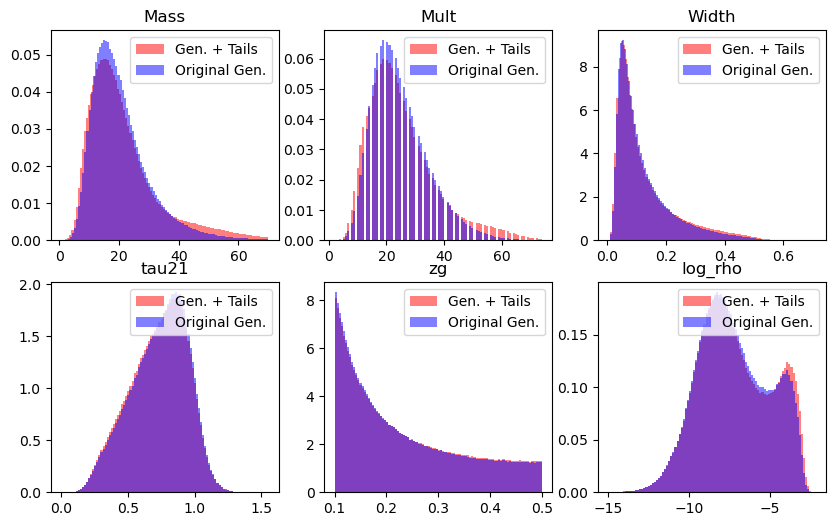

In [134]:
fig, ax = plt.subplots(2,3,figsize=(10,6))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].hist(gen_features[:,i],bins=100,density=True,alpha=0.5,label='Gen. + Tails',color='red')
    ax[i].hist(gen_features_2[:,i],bins=100,density=True,alpha=0.5,label='Original Gen.',color='blue')
    #lt.xlim(-14,-12)
    ax[i].legend()
    ax[i].set_title(cols[i])
plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from sklearn.manifold import TSNE

def augment_tails(gen_features,sim_features)
    data = gen_features
    pca = PCA(n_components=1)
    pca.fit(data)
    data_1d = pca.transform(data)
    upper_quantile = np.percentile(data_1d,97.5)
    lower_quantile = np.percentile(data_1d,2.5)
    tail_mask = np.logical_or(data_1d < lower_quantile, data_1d > upper_quantile).flatten()#data_2d[:,1] < lower_quantile[0], data_2d[:,1] > upper_quantile[1])
    return tail_mask



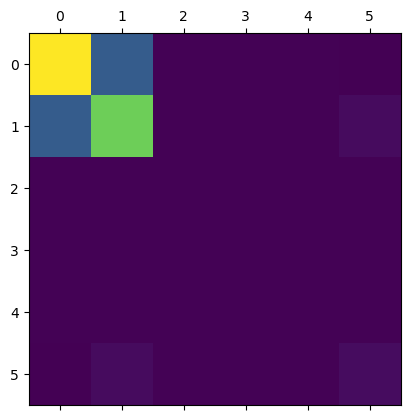

In [30]:
plt.matshow(obs['Covariance'].mean(0))

In [31]:
obs['Covariance'].mean(0)

array([[ 6.67580725e-01,  1.91138615e-01,  7.13879018e-04,
         4.17843964e-04,  2.69493582e-04, -4.05903412e-03],
       [ 1.91138615e-01,  5.18383022e-01,  1.89659050e-04,
        -2.53211773e-05,  3.11250070e-04,  1.53349510e-02],
       [ 7.13879018e-04,  1.89659050e-04,  3.95664229e-05,
        -1.88459795e-05, -9.33548006e-07, -8.62411527e-05],
       [ 4.17843964e-04, -2.53211773e-05, -1.88459795e-05,
         1.78952272e-04,  1.50414681e-06, -9.92706125e-06],
       [ 2.69493582e-04,  3.11250070e-04, -9.33548006e-07,
         1.50414681e-06,  1.62060099e-05, -1.78621174e-05],
       [-4.05903412e-03,  1.53349510e-02, -8.62411527e-05,
        -9.92706125e-06, -1.78621174e-05,  1.87034740e-02]])

In [39]:
range(obs['Covariance'].mean(0).shape[1])

range(0, 6)

<Figure size 5000x5000 with 0 Axes>

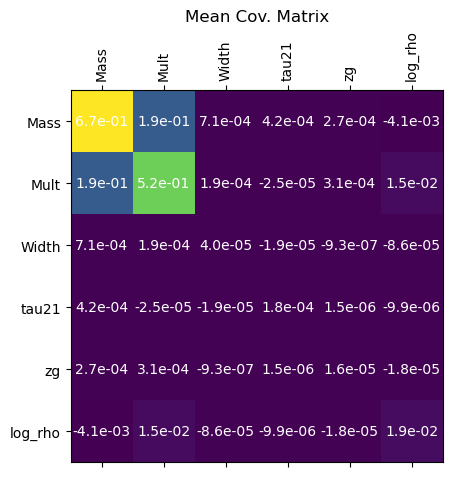

In [61]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

df = obs['Covariance'].mean(0)
title = 'Mean Cov. Matrix'

fig = plt.figure(figsize=(50, 50))
plt.gcf().set_size_inches((50, 50))

plt.matshow(df, cmap='viridis')

columns = np.array(["Mass", "Width", "Mult", "log_rho", "zg", "tau21"])[[0, 2, 1, 5, 4, 3]]
plt.xticks(range(df.shape[0]), columns, rotation='vertical')
plt.yticks(range(df.shape[1]), columns)

for i in range(len(columns)):
    for j in range(len(columns)):
        plt.text(j, i, f"{df[i, j]:.1e}", ha='center', va='center', color='w')  # Use scientific notation

#cbar = plt.colorbar(format=ScalarFormatter())  # Set scientific notation format for colorbar

plt.title(title)
plt.show()
    

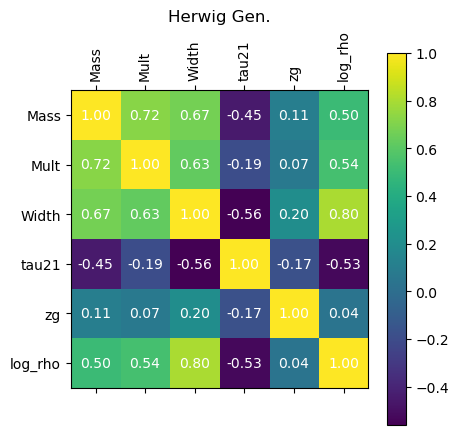

In [63]:
# Function to create a correlation matrix plot and display numbers
def plot_corr_matrix(df, title):
    plt.matshow(df.corr(), cmap='viridis')
    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
    plt.yticks(range(len(df.columns)), df.columns)
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            plt.text(j, i, f"{df.corr().iloc[i, j]:.2f}", ha='center', va='center', color='w')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Plot for sim_features26
plot_corr_matrix(pd.DataFrame(obs['Truth'],columns=columns), 'Herwig Gen.')

In [37]:
mcmc_single,truth_single = load_MCMC(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\metro_chains1k")

Loading MCMC.
125/126 [==================>.] - ETA: 1s

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

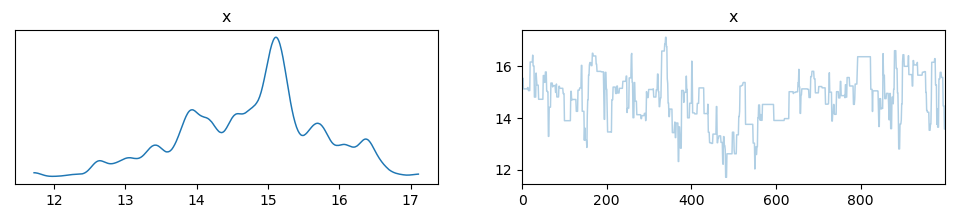

In [46]:
import arviz
arviz.plot_trace(arviz.convert_to_dataset(mcmc['Mass'][60]))

In [65]:
fig, ax = plt.subplots(2,3,figsize=(10,10))
ax = ax.rav

574832

 
Running IBU.
Plotting  Mass
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Single MCMC [ 0.15375692 -0.09676744 -0.10343622  0.01191229  0.04341989  0.1510502
  0.18702678  0.21645977  0.20318086  0.17143653  0.13687459  0.10196295
  0.07377155  0.03016805  0.01282687  0.00847901 -0.02020242 -0.03585916
 -0.03105829 -0.04455092 -0.04572768 -0.06678222 -0.06135925 -0.08685078
 -0.08110472 -0.0790967  -0.09019622 -0.1021037  -0.11126027 -0.13944921
 -0.1326134  -0.11270268 -0.13826541 -0.09594098 -0.10549914 -0.0861217
 -0.12713034 -0.1322788  -0.11051236 -0.14925102 -0.15494936 -0.078225
 -0.06384147 -0.14046857 -0.14176747 -0.10153003 -0.11539948 -0.18789302
 -0.10290784 -0.09489209 -0.05900751 -0.13719698 -0.07715497 -0.11406823
 -0.12949043 -0.11333428]
Mult MCMC [ 0.15609249 -0.08532628 -0.097802    0.01346108  0.0

C:\Users\James-PC\miniconda3\envs\ptorch\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


ValueError: 'single' is not a valid value for color

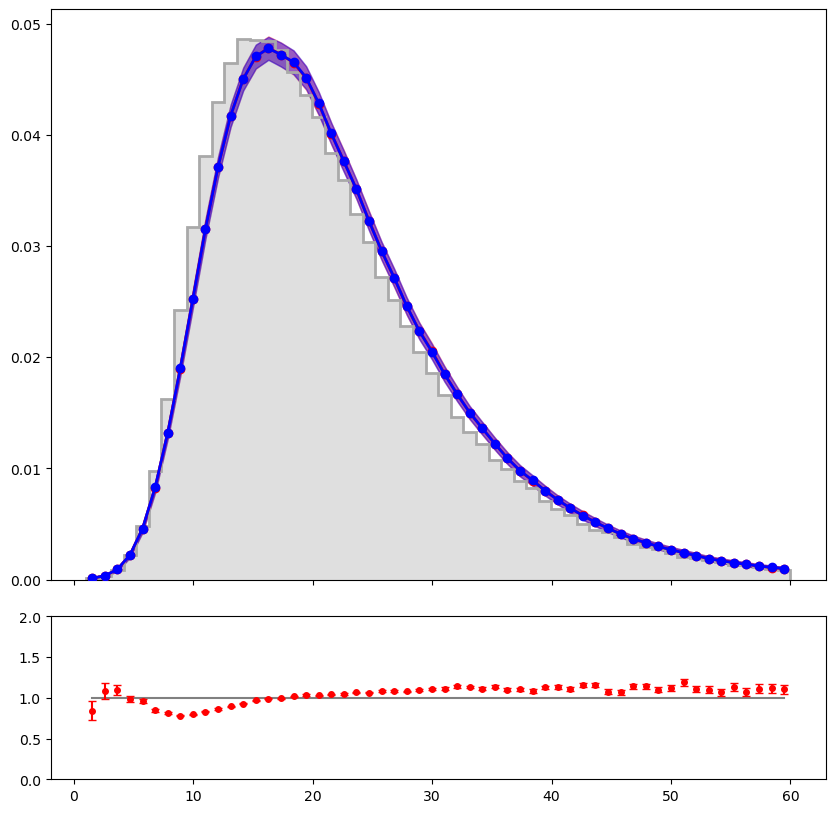

In [68]:
nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]

binning = dict(binning)
print(' ')
print('Running IBU.')

feature_names = np.array(["Jet Mass [GeV]","Jet Width", "$n_{constituents}$",r"$ln\rho$","$z_g$",r"$\tau_{21}$"])
feature_names = feature_names[[0,2,1,5,4,3]]


ylims = [
    ('Mass',(0,0.07)), # Mass
    ('Width',None), # Width
    ('Mult',(0,0.06)), # Multi
    ('log_rho',(0,0.25)), # lnp
    ('zg',None), # Zg
    ('tau21',(0,2.5)), # Tau21
]
ylims = dict(ylims)

cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]

for i in range(len(obs.keys())):
    key = cols[i]
    print('Plotting ',key)

    fig,ax = plt.subplots(2,figsize=(10,10),sharey=False,sharex=True,gridspec_kw={'height_ratios':(3.5,1),'hspace':0.1})
    ax[1].set_ylim(0,2)
    ax = ax.ravel()
    q = truth[key]
    bins = binning[key]
    g = mcmc[key]
    


    histograms = np.zeros((g.shape[1], len(bins) - 1))
    alea_hists = np.zeros((g.shape[1], len(bins) - 1))

    for j in range(g.shape[1]):
        bootstrap_sample = g[:,j]
        if j % 100 == 0:
            print(j,"/",1000)
        if key == 'Mult':
            bootstramp_sample = bootstrap_sample.round()

        histogram, _ = np.histogram(bootstrap_sample, bins=bins,density=True)
        alea_hist,_  = np.histogram(bootstrap_sample, bins=bins,density=False)
        histograms[j, :] = histogram
        alea_hists[j,:] = alea_hist

    hdi_results = arviz.hdi(histograms, hdi_prob=0.95)
    hdi_lower = hdi_results[:,0].T
    hdi_upper = hdi_results[:,1].T
    epi = (hdi_upper - hdi_lower)/4.

    mean_histogram = np.mean(histograms, axis=0)
    mean_alea = np.mean(alea_hists,axis=0)
    alea = np.sqrt(mean_alea)/(mean_alea.sum() * (bins[1] - bins[0]))

    weights = np.ones_like(q)
    ref_hist,_ = np.histogram(q,bins=bins,weights=np.ones_like(q),density=True)

    ratio = mean_histogram / (ref_hist + 1e-50)
    idx = np.where(mean_histogram == ref_hist)
    ratio[idx] = 1.0

    quad = np.sqrt(epi**2 + alea**2)
    ratio_error =  quad / (ref_hist + 1e-50)
    
    ################# Single ################
    g_single = mcmc_single[key][:len(g)]
    
    histograms_single = np.zeros((g_single.shape[1], len(bins) - 1))
    alea_hists_single = np.zeros((g_single.shape[1], len(bins) - 1))

    for j in range(g_single.shape[1]):
        bootstrap_sample = g_single[:,j]
        if j % 100 == 0:
            print(j,"/",1000)
        if key == 'Mult':
            bootstramp_sample = bootstrap_sample.round()

        histogram, _ = np.histogram(bootstrap_sample, bins=bins,density=True)
        alea_hist,_  = np.histogram(bootstrap_sample, bins=bins,density=False)
        histograms_single[j, :] = histogram
        alea_hists_single[j,:] = alea_hist

    hdi_results_single = arviz.hdi(histograms, hdi_prob=0.95)
    hdi_lower_single = hdi_results_single[:,0].T
    hdi_upper_single = hdi_results_single[:,1].T
    epi_single = (hdi_upper_single - hdi_lower_single)/4.

    mean_histogram_single = np.mean(histograms_single, axis=0)
    mean_alea_single = np.mean(alea_hists_single,axis=0)
    alea_single = np.sqrt(mean_alea_single)/(mean_alea_single.sum() * (bins[1] - bins[0]))

    ratio_single = mean_histogram_single / (ref_hist + 1e-50)
    idx = np.where(mean_histogram_single == ref_hist)
    ratio_single[idx] = 1.0

    quad_single = np.sqrt(epi_single**2 + alea_single**2)
    ratio_error_single =  quad_single / (ref_hist + 1e-50)
    
    
    single_ratio_value = 1.0 - ratio_single
    mult_ratio_value = 1.0 - ratio
    
    print("Single MCMC",single_ratio_value)
    print("Mult MCMC",mult_ratio_value)
    
    
    xaxis = [(bins[i] + bins[i+1])/2.0 for i in range(len(bins)-1)]

    bin_centers = (bins[:-1] + bins[1:]) / 2
   

    # Plots only our model
    ax[0].fill_between(bin_centers, mean_histogram - 3*quad,mean_histogram + 3*quad, color='red', alpha=0.4, label=r'$\pm 3\sigma_{quad.}$')
    ax[0].plot(bin_centers,mean_histogram,color='red',label=r'6D MCMC',linestyle='-',zorder=4,linewidth=2,marker='o')
    ax[1].errorbar(bin_centers,ratio,yerr=ratio_error,color='red',ls='none',capsize=3,marker='.',ms=8,label=r'6D MCMC',zorder=4)

    ax[0].hist(q,bins=bins,color='grey',label='Ground Truth',histtype='step',density=True,linewidth=2,alpha=1.0,facecolor='grey',edgecolor='darkgrey')
    ax[0].hist(q,bins=bins,color='grey',alpha=0.25,density=True)
    ax[1].plot(bin_centers,np.ones_like(bins[:-1]),color='grey')
    ax[0].hist(herwig_reco,bins=bins,color='k',label='Simulation',histtype='step',density=True,linewidth=2)
    
    ax[0].fill_between(bin_centers, mean_histogram_single - 3*quad_single,mean_histogram_single + 3*quad_single, color='blue', alpha=0.4, label=r'$\pm 3\sigma_{quad.}$')
    ax[0].plot(bin_centers,mean_histogram_single,color='blue',label=r'1D MCMC',linestyle='-',zorder=4,linewidth=2,marker='o')
    ax[1].errorbar(bin_centers,ratio_single,yerr=ratio_error_single,color='single',ls='none',capsize=3,marker='.',ms=8,label=r'1D MCMC',zorder=4)


    

    if ylims[key] is not None:
        ax[0].set_ylim(ylims[key])
    else:
        ax[0].set_ylim(bottom=0.0)

    ax[1].set_xlabel(feature_names[i],fontsize=30)
    ax[1].xaxis.set_label_coords(.5, -0.3)
    ax[0].set_ylabel('Normalized Entries',fontsize=30)
    ax[0].legend(loc=(-.1,1.05),fontsize=18,ncol=4)
    ax[1].set_ylabel('Ratio to Truth',fontsize=18)
    ax[1].xaxis.set_tick_params(labelsize=18)
    ax[1].yaxis.set_tick_params(labelsize=18)
    ax[0].yaxis.set_tick_params(labelsize=18)
    #plt.savefig(r"Inference\Plots\{}_Jan22.pdf".format(key))
    break


In [96]:
mcmc['Mass'][:,0]

array([34.913425, 28.52235 , 13.628436, ..., 18.532494, 14.639675,
       46.868538], dtype=float32)

In [97]:
nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]

binning = dict(binning)
print(' ')
print('Running IBU.')

feature_names = np.array(["Jet Mass [GeV]","Jet Width", "$n_{constituents}$",r"$ln\rho$","$z_g$",r"$\tau_{21}$"])
feature_names = feature_names[[0,2,1,5,4,3]]


ylims = [
    ('Mass',(0,0.07)), # Mass
    ('Width',None), # Width
    ('Mult',(0,0.06)), # Multi
    ('log_rho',(0,0.25)), # lnp
    ('zg',None), # Zg
    ('tau21',(0,2.5)), # Tau21
]
ylims = dict(ylims)

cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
single_ratios = {}
mult_ratios = {}

for i in range(len(cols)):
    key = cols[i]
    print('Plotting ',key)
    q = truth[key]
    bins = binning[key]
    g = mcmc[key]
    g_single = mcmc_single[key][:len(g)]
    
    ref_hist,_ = np.histogram(q,bins=bins,density=True)
    
    mr = []
    sr = []
    for j in range(g.shape[1]):
        bootstrap_sample = g[:,j]
        other_sample = g_single[:,j]
        if j % 100 == 0:
            print(j,"/",1000)
        if key == 'Mult':
            bootstramp_sample = bootstrap_sample.round()
            other_sample = other_sample.round()

        histogram_mult, _ = np.histogram(bootstrap_sample, bins=bins,density=True)
        histogram_single,_ = np.histogram(other_sample,bins=bins,density=True)
        
        mult_ratio = histogram_mult / (ref_hist + 1e-50)
        idx = np.where(histogram_mult == ref_hist)
        mult_ratio[idx] = 1.0
        mr.append(mult_ratio)
        
        ratio_single = histogram_single / (ref_hist + 1e-50)
        idx = np.where(histogram_single == ref_hist)
        ratio_single[idx] = 1.0
        sr.append(ratio_single)
    print("Single MCMC",np.mean(sr))
    print("Mult MCMC",np.mean(mr))
    single_ratios[key] = sr
    mult_ratios[key] = mr

    



 
Running IBU.
Plotting  Mass
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Single MCMC 1.0478944455359298
Mult MCMC 1.0477546975003436
Plotting  Mult
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Single MCMC 0.996621384425334
Mult MCMC 1.0107076095235548
Plotting  Width
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Single MCMC 1.0410612794963028
Mult MCMC 1.04206611744339
Plotting  tau21
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Single MCMC 1.0387724835384313
Mult MCMC 1.0399898746292755
Plotting  zg
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Single MCMC 0.9844212049995779
Mult MCMC 0.9846084840367108
Plotting  log_rho
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
50

In [117]:
#fig,ax = plt.subplots(2,3,figsize=(15,8))
#ax = ax.ravel()

for i,key in enumerate(mult_ratios.keys()):
    bins = binning[key]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    s_ingle = np.array(single_ratios[key])
    m_ult = np.array(mult_ratios[key])
    average_mult = np.mean(m_ult[np.where((m_ult < 2.0) & (m_ult > 0.0))])
    std_mult = np.std(m_ult[np.where((m_ult < 2.0) & (m_ult > 0.0))])
    average_single = np.mean(s_ingle[np.where((s_ingle < 2.0) & (s_ingle > 0.0))])
    std_sing = np.std(s_ingle[np.where((s_ingle < 2.0) & (s_ingle > 0.0))])
    print(key)
    print('<6D> - ',average_mult)
    print('<1D> - ',average_single)
    print(r'<6D> - <1D> / sqrt(sigma{6D}**2 + sigma_{1D}**2) = ',(average_mult - average_single)/np.sqrt(std_mult**2 + std_sing**2))
    print('sigma(6D) - ',std_mult)
    print('sigma(1D) - ',std_sing)
    print(" ")
    #ax[i].plot(bin_centers,np.ones_like(bin_centers),color='k')
    #ax[i].scatter(bin_centers,s_ingle,color='red',label='1D MCMC')
    #ax[i].scatter(bin_centers,m_ult,color='blue',label='6D MCMC')
    #ax[i].set_title(key)
    #ax[i].set_ylim(0.,2)
    #ax[i].legend(loc='best')

Mass
<6D> -  1.0477546975003436
<1D> -  1.0478944455359298
<6D> - <1D> / sqrt(sigma{6D}**2 + sigma_{1D}**2) =  -0.0009466964254803992
sigma(6D) -  0.10429442341126659
sigma(1D) -  0.10446679565739561
 
Mult
<6D> -  1.0107076095235548
<1D> -  0.996621384425334
<6D> - <1D> / sqrt(sigma{6D}**2 + sigma_{1D}**2) =  0.10969094046820123
sigma(6D) -  0.11156476123141632
sigma(1D) -  0.06359506284236241
 
Width
<6D> -  1.0140490943404108
<1D> -  1.0126257414105921
<6D> - <1D> / sqrt(sigma{6D}**2 + sigma_{1D}**2) =  0.013661117302487941
sigma(6D) -  0.0741180012507682
sigma(1D) -  0.0732263275409042
 
tau21
<6D> -  1.019684040028887
<1D> -  1.0198349659512844
<6D> - <1D> / sqrt(sigma{6D}**2 + sigma_{1D}**2) =  -0.0009190397951314536
sigma(6D) -  0.115712476545167
sigma(1D) -  0.1165300931469905
 
zg
<6D> -  0.9846084840367108
<1D> -  0.9844212049995779
<6D> - <1D> / sqrt(sigma{6D}**2 + sigma_{1D}**2) =  0.003516708494637138
sigma(6D) -  0.03747495845311484
sigma(1D) -  0.037836799062286826
 
log

In [1]:
import numpy as np

augmented = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\Inference_Augmented.pkl",allow_pickle=True)
normal = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\Inference_Covariance.pkl",allow_pickle=True)

In [2]:
nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]

binning = dict(binning)

feature_names = np.array(["Jet Mass [GeV]","Jet Width", "$n_{constituents}$",r"$ln\rho$","$z_g$",r"$\tau_{21}$"])
feature_names = feature_names[[0,2,1,5,4,3]]


ylims = [
    ('Mass',(0,0.07)), # Mass
    ('Width',None), # Width
    ('Mult',(0,0.06)), # Multi
    ('log_rho',(0,0.25)), # lnp
    ('zg',None), # Zg
    ('tau21',(0,2.5)), # Tau21
]
ylims = dict(ylims)

cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
single_ratios = {}
augmented_ratios = {}

for i in range(len(cols)):
    key = cols[i]
    print('Plotting ',key)
    q = augmented['Truth'][:,i]
    a = augmented['Events'][:,i]
    n = normal['Events'][:,i]
    
    bins = binning[key]
    
    ref_hist,_ = np.histogram(q,bins=bins,density=True)
    histogram_aug,_ = np.histogram(a,bins=bins,density=True)
    aug_ratio = histogram_aug / (ref_hist + 1e-50)
    idx = np.where(histogram_aug == ref_hist)
    aug_ratio[idx] = 1.0
    augmented_ratios[key] = aug_ratio

    histogram_single,_ = np.histogram(n,bins=bins,density=True)
    ratio_single = histogram_single / (ref_hist + 1e-50)
    idx = np.where(histogram_single == ref_hist)
    ratio_single[idx] = 1.0
    single_ratios[key] = ratio_single
    print("Augmented ",key,":",aug_ratio)
    print("Normal ",key,":",ratio_single)


Plotting  Mass
Augmented  Mass : [0.71595295 1.03181454 1.05034003 0.904651   0.83034557 0.7678865
 0.77776167 0.76077393 0.76548735 0.81346357 0.84938737 0.88591759
 0.92474722 0.96290027 0.99819344 1.00166564 1.02200107 1.05594311
 1.04613394 1.06990985 1.06314254 1.08685675 1.07965602 1.1004352
 1.08239261 1.08963509 1.10288062 1.10350502 1.10502472 1.12869076
 1.12731534 1.11075988 1.1100586  1.08599107 1.11525559 1.07979201
 1.10704434 1.13266189 1.12576079 1.14445046 1.14780306 1.08198346
 1.10042472 1.12350873 1.14811315 1.14533281 1.09962996 1.19700801
 1.21977004 1.09010398 1.04602448 1.13203188 1.11252557 1.09184089
 1.09581335 1.1241014 ]
Normal  Mass : [0.43177385 0.7424404  0.7538473  0.85223655 0.90820892 0.81661521
 0.7967091  0.78497713 0.7925594  0.83959897 0.86936249 0.90679276
 0.92780192 0.9747699  0.99603581 0.99350913 1.02624849 1.03221379
 1.04107867 1.03634165 1.04534068 1.07154325 1.05645317 1.09215455
 1.07699613 1.08058432 1.07772258 1.11507919 1.0998548  1.1

In [27]:
for key in augmented_ratios.keys():
    aug_ratio = augmented_ratios[key]
    norm_ratio = single_ratios[key]
    print(key)
    average_aug = np.mean(aug_ratio[np.where((aug_ratio > 0.0) & (aug_ratio < 2.0))])
    average_norm = np.mean(norm_ratio[np.where((norm_ratio > 0.0) & (norm_ratio < 2.0))])
    std_aug = np.std(aug_ratio[np.where((aug_ratio > 0.0) & (aug_ratio < 2.0))])
    std_norm = np.std(norm_ratio[np.where((norm_ratio > 0.0) & (norm_ratio < 2.0))])
    print('<Augmented> - ',average_aug)
    print('<Standard> - ',average_norm)
    print(r'<Standard> - <Augmented> / sqrt(sigma{Aug.}**2 + sigma_{Stand.}**2) = ',(average_norm - average_aug)/np.sqrt(std_aug**2 + std_norm**2))
    print('sigma(Augmented) - ',std_aug)
    print('sigma(Standard) - ',std_norm)
    print(" ")

Mass
<Augmented> -  1.0405821680979843
<Standard> -  1.0228150510033367
<Standard> - <Augmented> / sqrt(sigma{Aug.}**2 + sigma_{Stand.}**2) =  -0.09544914876163331
sigma(Augmented) -  0.12144499675544389
sigma(Standard) -  0.141067506369482
 
Mult
<Augmented> -  0.9831989118989054
<Standard> -  1.0017319504601123
<Standard> - <Augmented> / sqrt(sigma{Aug.}**2 + sigma_{Stand.}**2) =  0.11613980425581227
sigma(Augmented) -  0.12291114125083483
sigma(Standard) -  0.10176989972148909
 
Width
<Augmented> -  1.0162672413214233
<Standard> -  1.0002610035661141
<Standard> - <Augmented> / sqrt(sigma{Aug.}**2 + sigma_{Stand.}**2) =  -0.1703607565202374
sigma(Augmented) -  0.07769900306410539
sigma(Standard) -  0.05282422825260526
 
tau21
<Augmented> -  1.0203248131885894
<Standard> -  1.0247464114677667
<Standard> - <Augmented> / sqrt(sigma{Aug.}**2 + sigma_{Stand.}**2) =  0.021521566109845795
sigma(Augmented) -  0.15700704733486862
sigma(Standard) -  0.1325079122620165
 
zg
<Augmented> -  0.975

In [21]:
cols

array(['Mass', 'Mult', 'Width', 'tau21', 'zg', 'log_rho'], dtype='<U7')

 
Running IBU.
Plotting  Mass
Plotting  Mult
Plotting  Width
Plotting  tau21
Plotting  zg
Plotting  log_rho


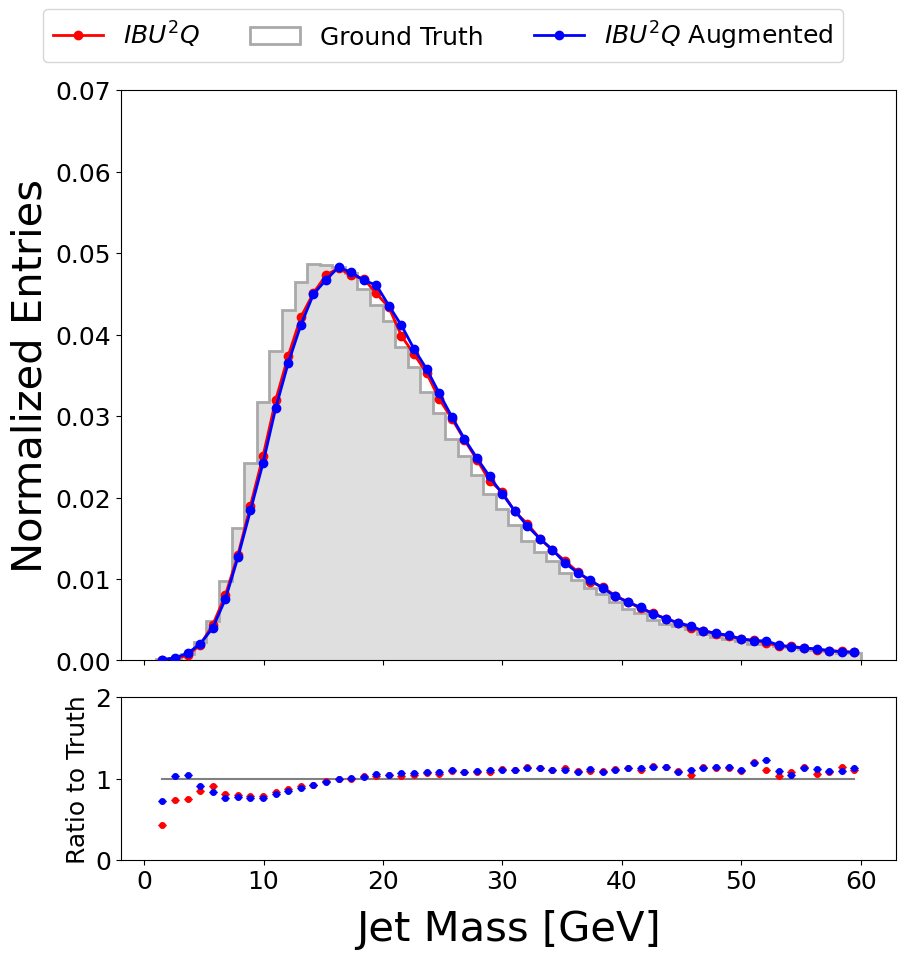

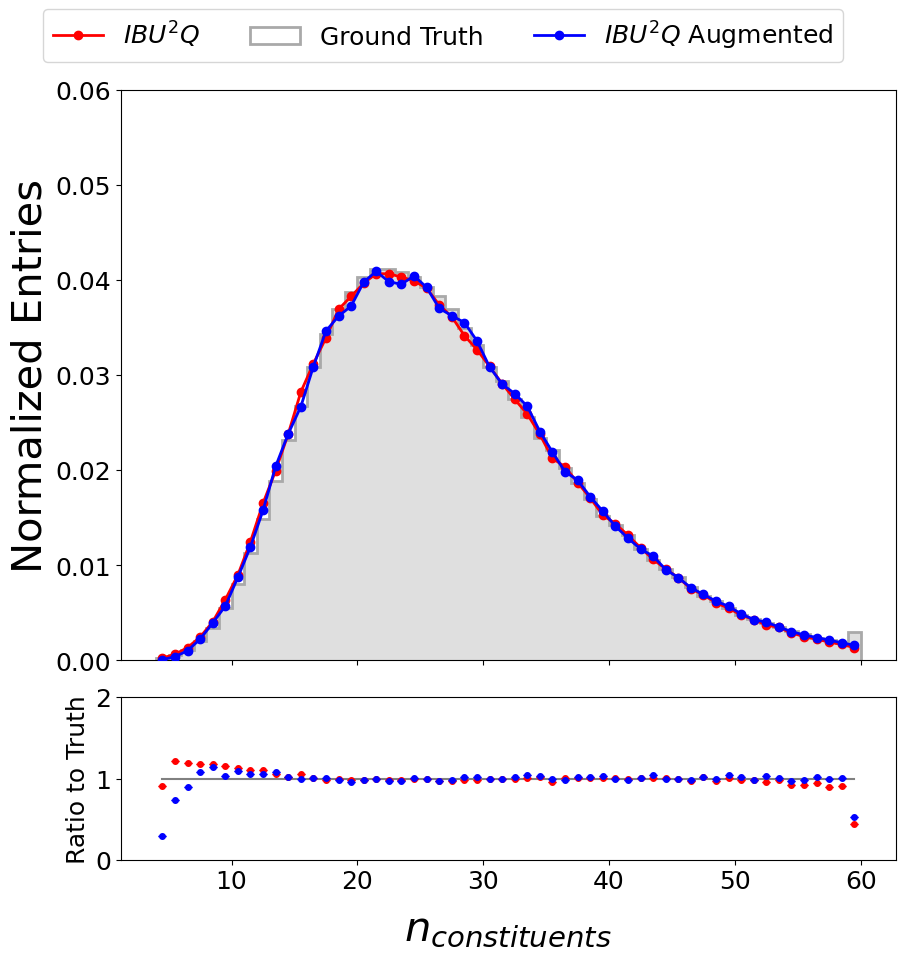

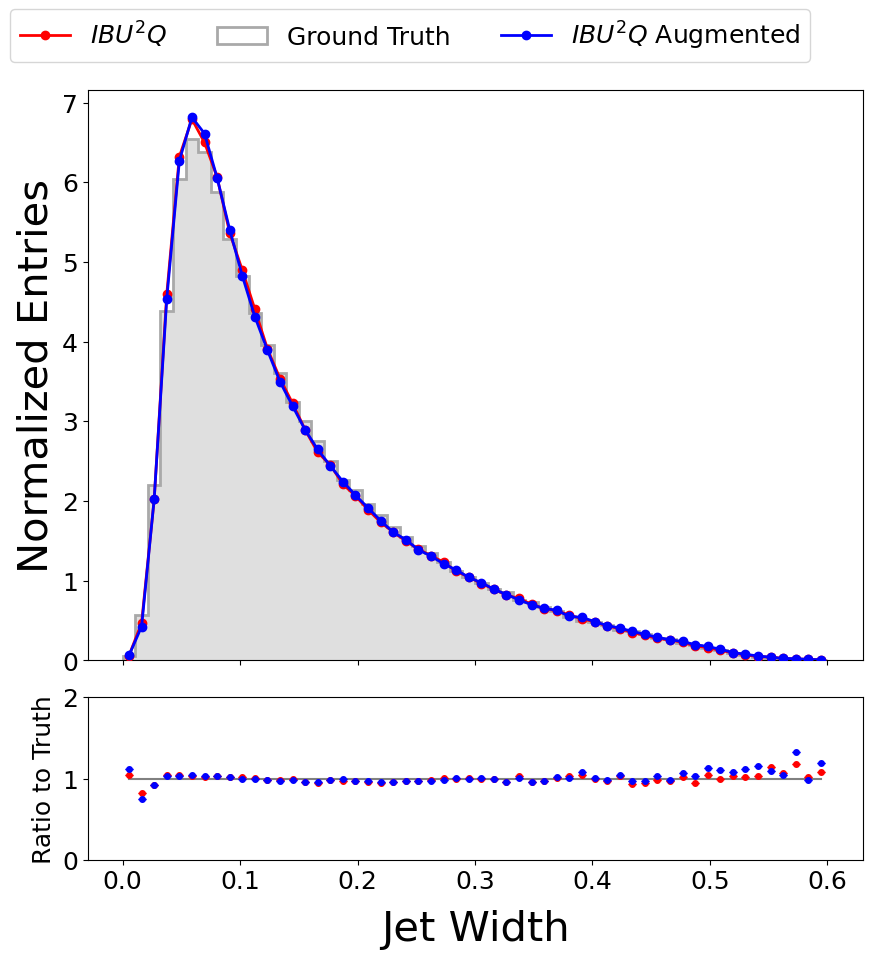

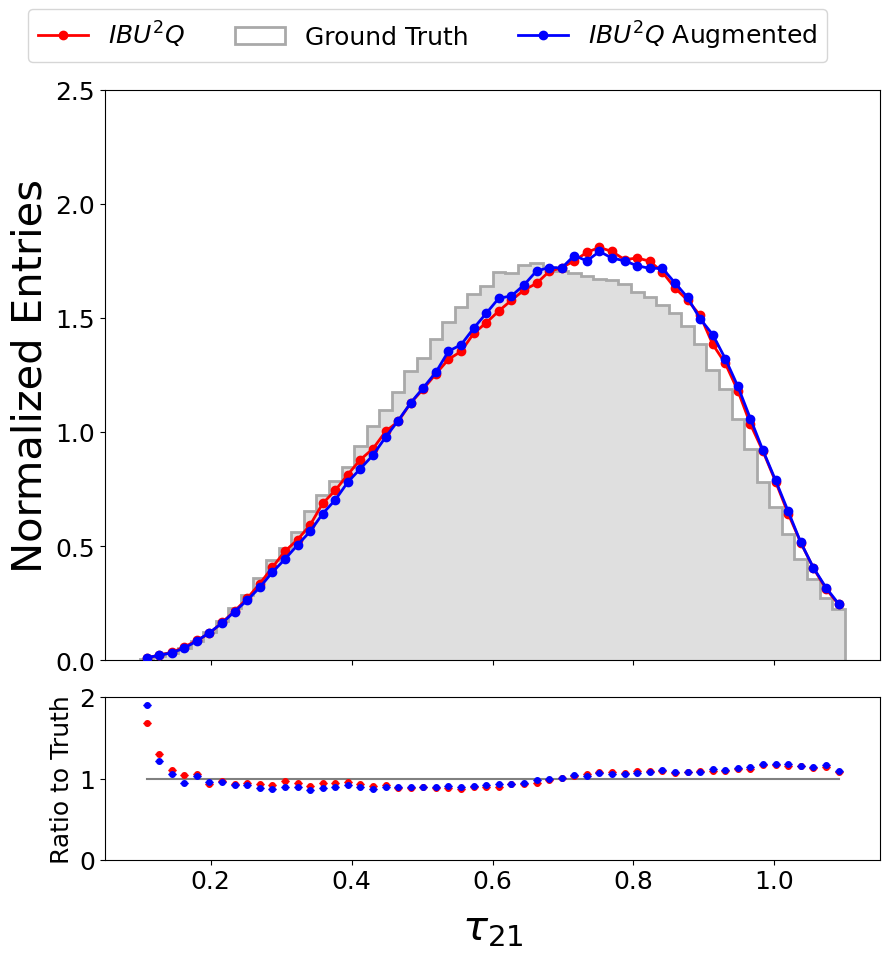

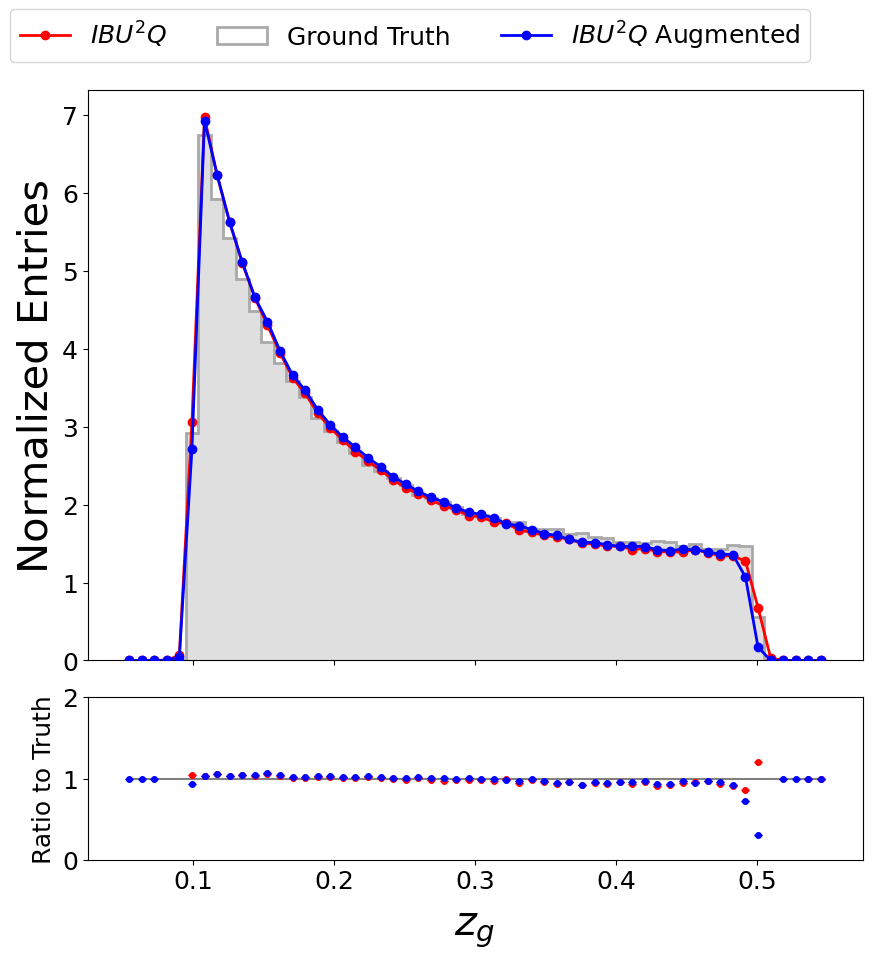

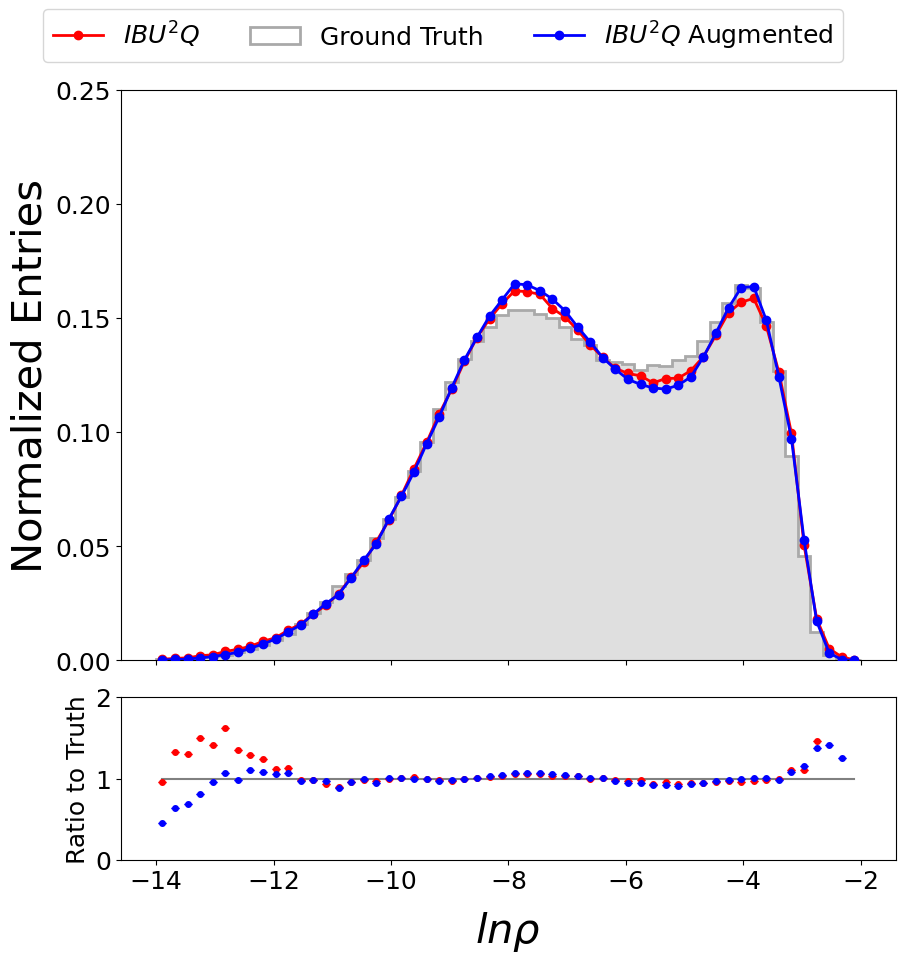

In [23]:
import matplotlib.pyplot as plt

nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]

binning = dict(binning)
print(' ')
print('Running IBU.')

feature_names = np.array(["Jet Mass [GeV]","Jet Width", "$n_{constituents}$",r"$ln\rho$","$z_g$",r"$\tau_{21}$"])
feature_names = feature_names[[0,2,1,5,4,3]]


ylims = [
    ('Mass',(0,0.07)), # Mass
    ('Width',None), # Width
    ('Mult',(0,0.06)), # Multi
    ('log_rho',(0,0.25)), # lnp
    ('zg',None), # Zg
    ('tau21',(0,2.5)), # Tau21
]
ylims = dict(ylims)

cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]

for i in range(len(cols)):
    key = cols[i]
    print('Plotting ',key)
    bins = binning[key]
    fig,ax = plt.subplots(2,figsize=(10,10),sharey=False,sharex=True,gridspec_kw={'height_ratios':(3.5,1),'hspace':0.1})
    ax[1].set_ylim(0,2)
    ax = ax.ravel()
    q = normal['Truth'][:,i]
    a = augmented['Events'][:,i]
    n = normal['Events'][:,i]
    


    weights = np.ones_like(q)
    ref_hist,_ = np.histogram(q,bins=bins,weights=np.ones_like(q),density=True)

    mean_histogram,_ = np.histogram(n,bins=bins,density=True)
    ratio = mean_histogram / (ref_hist + 1e-50)
    idx = np.where(mean_histogram == ref_hist)
    ratio[idx] = 1.0
    
    aug_hist,_ = np.histogram(a,bins=bins,density=True)
    aug_ratio = aug_hist / (ref_hist + 1e-50)
    idx = np.where(aug_hist == ref_hist)
    aug_ratio[idx] = 1.0
    
    
    xaxis = [(bins[i] + bins[i+1])/2.0 for i in range(len(bins)-1)]

    bin_centers = (bins[:-1] + bins[1:]) / 2
   

    # Plots only our model
    #ax[0].fill_between(bin_centers, mean_histogram - 3*quad,mean_histogram + 3*quad, color='red', alpha=0.4, label=r'$\pm 3\sigma_{quad.}$')
    ax[0].plot(bin_centers,mean_histogram,color='red',label=r'$IBU^2 Q$',linestyle='-',zorder=4,linewidth=2,marker='o')
    ax[1].errorbar(bin_centers,ratio,yerr=0,color='red',ls='none',capsize=3,marker='.',ms=8,label=r'$IBU^2 Q$',zorder=4)

    ax[0].hist(q,bins=bins,color='grey',label='Ground Truth',histtype='step',density=True,linewidth=2,alpha=1.0,facecolor='grey',edgecolor='darkgrey')
    ax[0].hist(q,bins=bins,color='grey',alpha=0.25,density=True)
    ax[1].plot(bin_centers,np.ones_like(bins[:-1]),color='grey')
    #ax[0].hist(herwig_reco,bins=bins,color='k',label='Simulation',histtype='step',density=True,linewidth=2)
    
    #ax[0].fill_between(bin_centers, mean_histogram_single - 3*quad_single,mean_histogram_single + 3*quad_single, color='blue', alpha=0.4, label=r'$\pm 3\sigma_{quad.}$')
    ax[0].plot(bin_centers,aug_hist,color='blue',label=r'$IBU^2 Q$ Augmented',linestyle='-',zorder=4,linewidth=2,marker='o')
    ax[1].errorbar(bin_centers,aug_ratio,yerr=0,color='blue',ls='none',capsize=3,marker='.',ms=8,label=r'$IBU^2 Q$ Augmented',zorder=4)


    

    if ylims[key] is not None:
        ax[0].set_ylim(ylims[key])
    else:
        ax[0].set_ylim(bottom=0.0)

    ax[1].set_xlabel(feature_names[i],fontsize=30)
    ax[1].xaxis.set_label_coords(.5, -0.3)
    ax[0].set_ylabel('Normalized Entries',fontsize=30)
    ax[0].legend(loc=(-.1,1.05),fontsize=18,ncol=4)
    ax[1].set_ylabel('Ratio to Truth',fontsize=18)
    ax[1].xaxis.set_tick_params(labelsize=18)
    ax[1].yaxis.set_tick_params(labelsize=18)
    ax[0].yaxis.set_tick_params(labelsize=18)
    #plt.savefig(r"Inference\Plots\{}_Jan22.pdf".format(key))

In [1]:
from utils import load_MCMC

mcmc,truth = load_MCMC(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\vector_state")

Loading MCMC.
125/126 [==================>.] - ETA: 3s

In [2]:
def GetEMD(ref,array,weights_arr,binning,nboot = 100,ibu2 = False):
    ds = []
    hists = []
    if ibu2:
        for i in range(nboot):
            array_boot = array[:,i]
            w_boot = np.ones_like(array_boot)
            ds.append(st.wasserstein_distance(ref,array_boot,v_weights=w_boot))
            hists.append(np.histogram(array_boot,weights=w_boot,bins=binning,density=True)[0])
    else:
        for _ in range(nboot):
            #ref_boot = np.random.choice(ref,ref.shape[0])
            arr_idx = np.random.choice(range(array.shape[0]),array.shape[0])
            array_boot = array[arr_idx]
            w_boot = weights_arr[arr_idx]
            ds.append(st.wasserstein_distance(ref,array_boot,v_weights=w_boot))
            hists.append(np.histogram(array_boot,weights=w_boot,bins=binning,density=True)[0])

    unc = np.std(hists,0)
    return np.mean(ds), np.std(ds),unc

In [6]:
import numpy as np
import os
### 4 Functions from SBUnfold https://github.com/ViniciusMikuni/SBUnfold/tree/main
def LoadJson(file_name,base_folder='JSON'):
    import json,yaml
    JSONPATH = os.path.join(base_folder,file_name)
    return yaml.safe_load(open(JSONPATH))

### https://github.com/ViniciusMikuni/SBUnfold/tree/main
def ReversePreprocessing(data,fname,base_folder):
    data_dict = LoadJson(fname,base_folder)
    #data = (np.array(data_dict['max']) - data_dict['min']) * data + data_dict['min']
    data = data * data_dict['std'] + data_dict['mean']
    data[:,2] = np.round(data[:,2]) #particle multiplicity should be an integer
    return data

omnifold_ws = np.load(r"Inference\weights.npy")
of_data = np.load(r"Inference\omnifold_Pythia.npy")

of_data = ReversePreprocessing(of_data,'gen_features.json','JSON')
of_data = of_data[:,[0,2,1,5,4,3]]

cinn_data = np.load(r"Inference\inn_Herwig.npy")
cinn_data = ReversePreprocessing(cinn_data,'gen_features.json','JSON')
cinn_data = cinn_data[:,[0,2,1,5,4,3]]

In [31]:
a = np.load(r"Inference/Inference_Covariance.pkl",allow_pickle=True)

In [55]:
g = mcmc['Mass']
q = truth['Mass']
import scipy.stats as st
import numpy as np

nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]
    
binning = dict(binning)
# bins = binning['Mass']
# emd_ibu2q,err,_ = GetEMD(q,g,np.ones_like(q),bins,ibu2 = True)

In [27]:
import scipy.stats as st
q = truth['zg']
g = mcmc['zg'].mean(1)
st.wasserstein_distance(q,g,v_weights=np.ones_like(g))

0.004438406726526847

In [33]:
evs = a['Events']
ts = a['Truth']

In [39]:
len(q)

574832

In [40]:
len(ts)

574832

In [41]:
len(cinn_data)

574832

In [68]:
evs.min()

-15.795825

In [92]:
ts.min()

-37.328863362021465

In [90]:
idx = 2
q = ts[:,idx]

print("ibu2")
i = st.wasserstein_distance(q,evs[:,idx])
print(i)
print('cINN')
i = st.wasserstein_distance(q,cinn_data[:,idx])
print(i)
print('Omni')
i = st.wasserstein_distance(q,of_data[:,idx],v_weights=omnifold_ws)
print(i)

ibu2
0.0014590837487361394
cINN
0.0039763787809153585
Omni
0.0019070733146658333


In [100]:
e

array([0.27328846, 0.4647232 , 1.0515926 , ..., 0.61925966, 0.7863626 ,
       0.43208826], dtype=float32)

In [101]:
q

array([ -4.01553207,  -9.99185007,  -8.88821941, ..., -10.47094526,
        -3.70966869,  -5.79624954])

In [103]:
binning.keys()

dict_keys(['Mass', 'Width', 'Mult', 'log_rho', 'zg', 'tau21'])

In [109]:
def get_triangle_distance(x,y,binning):
    dist = 0
    w = binning[1:] - binning[:-1]
    for ib in range(len(x)):
        dist+=0.5*w[ib]*(x[ib] - y[ib])**2/(x[ib] + y[ib]) if x[ib] + y[ib] >0 else 0.0
    return dist*1e3

idx = 3
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
key = cols[idx]
bins = binning[key]
print(key)
q = ts[:,idx]
e = mcmc[key].mean(1)#evs[:,idx]

if key == 'Mult':
    e = e.round()
    
ref_hist = np.histogram(q,bins=bins,density=True)[0]
ibu_hist = np.histogram(e,bins=bins,density=True)[0]
cinn_hist = np.histogram(cinn_data[:,idx],bins=bins,density=True)[0]
omni_hist = np.histogram(of_data[:,idx],bins=bins,weights=omnifold_ws,density=True)[0]
print("ibu2")
i = get_triangle_distance(ibu_hist,ref_hist,bins)
print(i)
print('cINN')
i = get_triangle_distance(cinn_hist,ref_hist,bins)
print(i)
print('Omni')
i = get_triangle_distance(omni_hist,ref_hist,bins)
print(i)

tau21
ibu2
2.026151418155424
cINN
3.0189584707867563
Omni
0.7210584902632287


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Function to create a correlation matrix plot and display numbers
def plot_corr_matrix(df, title):
    plt.matshow(df.corr(), cmap='viridis')
    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
    plt.yticks(range(len(df.columns)), df.columns)
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            plt.text(j, i, f"{df.corr().iloc[i, j]:.2f}", ha='center', va='center', color='w')
    plt.colorbar()
    plt.title(title,fontsize=25)
    plt.show()
    
def plot_diff(df_true,df_pred, title):
    norm_cor = abs(df_true.corr() - df_pred.corr())/df_true.corr()
    plt.matshow(norm_cor, cmap='viridis')
    plt.xticks(range(len(df_true.columns)), df_true.columns, rotation='vertical')
    plt.yticks(range(len(df_true.columns)), df_true.columns)
    for i in range(len(df_true.columns)):
        for j in range(len(df_true.columns)):
            plt.text(j, i, f"{norm_cor.iloc[i, j]:.2f}", ha='center', va='center', color='w')
    plt.colorbar()
    plt.title(title,fontsize=25)
    plt.show()
    

# # Plot for sim_features26
# plot_corr_matrix(sim_features26, 'Pythia26 Sim.')

# # Plot for sim_features25
# plot_corr_matrix(sim_features25, 'Pythia25 Sim.')

# # Plot for sim_features21
# plot_corr_matrix(sim_features21, 'Pythia21 Sim.')

In [4]:
a = np.load(r"Inference\Inference_Covariance_Pythia.pkl",allow_pickle=True)

In [7]:
a['Truth'] = scaler.inverse_transform(a['Truth'])

In [11]:
import pickle
with open("Inference\Inference_Covariance_Pythia_unscaled.pkl","wb") as file:
    pickle.dump(a,file)

In [9]:
feature_names = np.array(["Jet Mass [GeV]","Jet Width", "$n_{constituents}$",r"$ln\rho$","$z_g$",r"$\tau_{21}$"])
feature_names = feature_names[[0,2,1,5,4,3]]

pythia_pred = pd.DataFrame(a['Events'],columns=feature_names)
pythia_true = pd.DataFrame(a['Truth'],columns=feature_names)

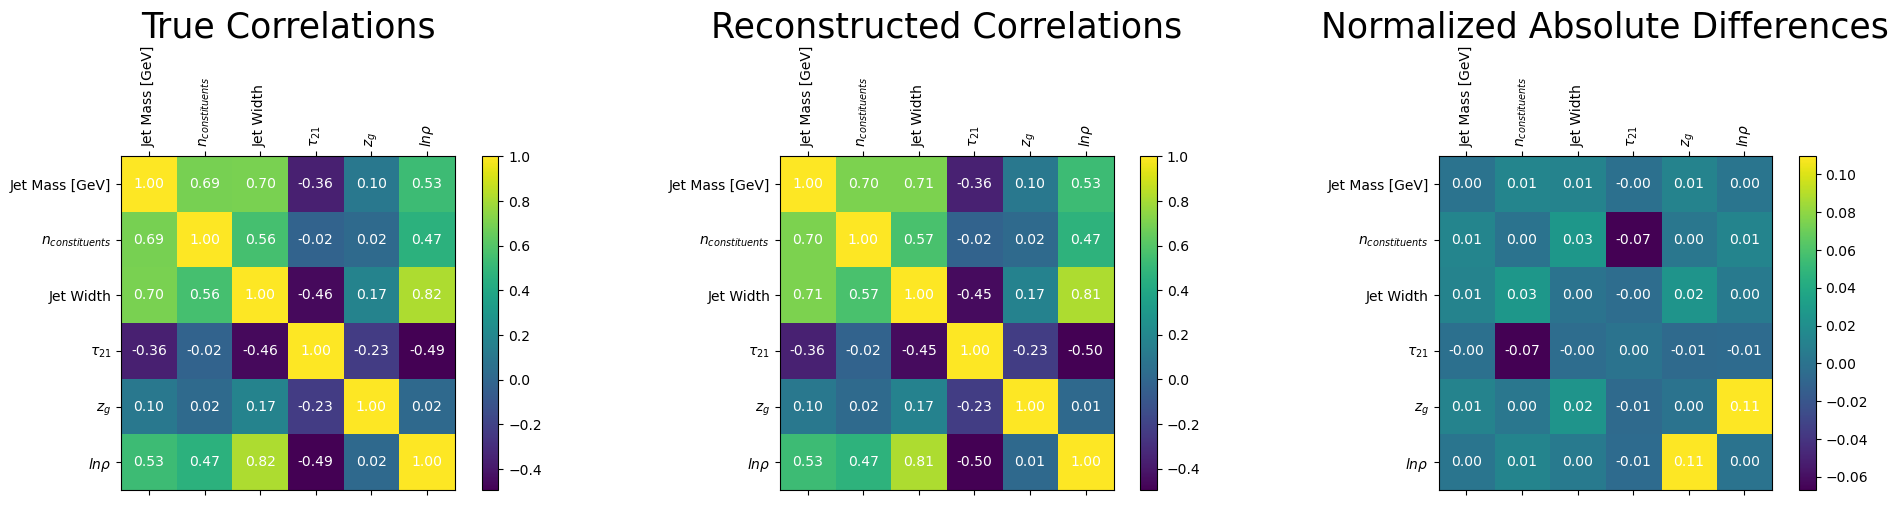

In [33]:

def plot_corr_matrix(ax, df, title):
    im = ax.matshow(df.corr(), cmap='viridis')
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation='vertical')
    ax.set_yticks(range(len(df.columns)))
    ax.set_yticklabels(df.columns)
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            ax.text(j, i, f"{df.corr().iloc[i, j]:.2f}", ha='center', va='center', color='w')
    ax.set_title(title, fontsize=25)
    return im

def plot_diff(ax, df_true, df_pred, title):
    norm_cor = abs(df_true.corr() - df_pred.corr()) / df_true.corr()
    im = ax.matshow(norm_cor, cmap='viridis')
    ax.set_xticks(range(len(df_true.columns)))
    ax.set_xticklabels(df_true.columns, rotation='vertical')
    ax.set_yticks(range(len(df_true.columns)))
    ax.set_yticklabels(df_true.columns)
    for i in range(len(df_true.columns)):
        for j in range(len(df_true.columns)):
            ax.text(j, i, f"{norm_cor.iloc[i, j]:.2f}", ha='center', va='center', color='w')
    ax.set_title(title, fontsize=25)
    return im

# Create a figure and axes for the subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot the first function
im1 = plot_corr_matrix(axs[0], pythia_true, 'True Correlations')

# Plot the second function
im2 = plot_corr_matrix(axs[1], pythia_pred, 'Reconstructed Correlations')

# Plot the third function
im3 = plot_diff(axs[2], pythia_true, pythia_pred, 'Normalized Absolute Differences')

# Add colorbars
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])
fig.colorbar(im3, ax=axs[2])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
import energyflow as ef
import numpy as np

cache_dir="/global/cfs/cdirs/m3929/I2SB/"
pythia26 =  ef.zjets_delphes.load("Pythia26",
                                                   cache_dir=cache_dir,exclude_keys=['particles'])

In [7]:
pythia26.keys()

dict_keys(['gen_mults', 'gen_tau2s', 'gen_zgs', 'gen_ang2s', 'gen_lhas', 'gen_Zs', 'gen_widths', 'gen_jets', 'gen_sdms', 'sim_mults', 'sim_tau2s', 'sim_zgs', 'sim_ang2s', 'sim_lhas', 'sim_widths', 'sim_jets', 'sim_sdms'])

In [10]:
a = pythia26['sim_jets'][:,:3]/ np.array([100,1,1])

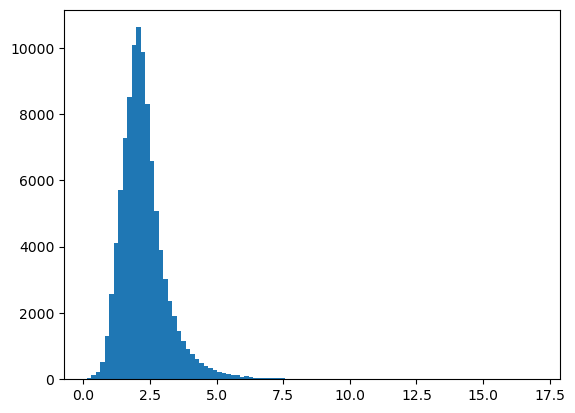

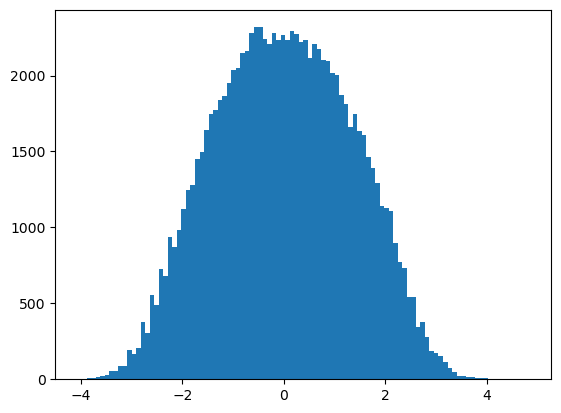

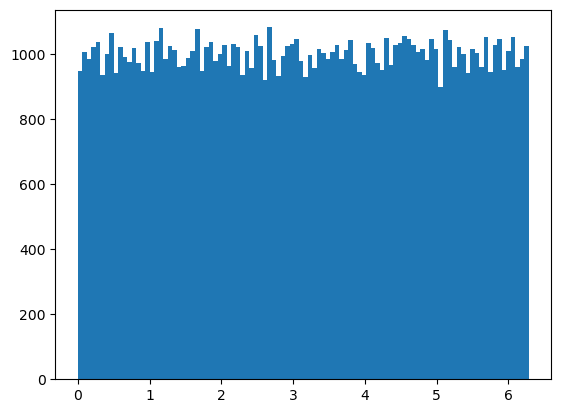

In [13]:
import matplotlib.pyplot as plt

plt.hist(a[:,0],bins=100)
plt.show()

plt.hist(a[:,1],bins=100)
plt.show()

plt.hist(a[:,2],bins=100)
plt.show()

In [3]:
import numpy as np
inf_data = np.load(r"Inference/Inference_Covariance.pkl",allow_pickle=True)

In [14]:
import pandas as pd
import numpy as np
import os
import energyflow as ef
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pandas as pd
import collections

def create_dataset(sample_name="Pythia26",
               N_t=1000000,N_v=600000,
               cache_dir="/global/cfs/cdirs/m3929/I2SB/"):

    datasets = {sample_name: ef.zjets_delphes.load(sample_name, num_data=N_t+N_v,
                                                   cache_dir=cache_dir,exclude_keys=['particles'])}
    feature_names = ['widths','mults','sdms','zgs','tau2s']
    gen_features = [datasets[sample_name]['gen_jets'][:,3]]
    sim_features = [datasets[sample_name]['sim_jets'][:,3]]
    gen_PT = np.c_[datasets[sample_name]['gen_jets'][:,0]]
    print(gen_PT.shape)

    for feature in feature_names:
        gen_features.append(datasets[sample_name]['gen_'+feature])
        sim_features.append(datasets[sample_name]['sim_'+feature])

    gen_features = np.stack(gen_features,-1)
    sim_features = np.stack(sim_features,-1)
    #ln rho
    gen_features[:,3] = 2*np.ma.log(np.ma.divide(gen_features[:,3],datasets[sample_name]['gen_jets'][:,0]).filled(0)).filled(0)
    sim_features[:,3] = 2*np.ma.log(np.ma.divide(sim_features[:,3],datasets[sample_name]['sim_jets'][:,0]).filled(0)).filled(0)
    #tau2
    gen_features[:,5] = gen_features[:,5]/(10**-50 + gen_features[:,1])
    sim_features[:,5] = sim_features[:,5]/(10**-50 + sim_features[:,1])

    # Preselection cuts - just basic and loose.

    if 'Pythia' in sample_name:
        cols = ["Mass","Width", "Mult","log_rho","zg","tau21"]
        cols = cols + [name+"_sim" for name in cols] + ["gen_pT"]
        print("Applying cuts on Gen. and Sim. for "+ sample_name)
        temp = pd.DataFrame(np.concatenate([gen_features,sim_features,gen_PT],axis=1),columns = cols)
        temp = temp[(temp.zg > 0.1) & (temp.zg_sim > 0.1) & (temp.Mass < 70) & (temp.Mass_sim < 100) & (temp.log_rho > -15) & (temp.log_rho_sim > -20) & (temp.Mult < 75) & (temp.Mult_sim < 100) & (temp.Mass > 0)]
        gen_features = temp[cols[:6]].to_numpy()
        sim_features = temp[cols[6:-1]].to_numpy()
        gen_PT = temp[cols[-1]].to_numpy()

        # Cut out negative masses from the generations.
    if sample_name == 'Herwig':
        print("Cutting negative masses from Herwig generations.")
        cols = ["Mass","Width", "Mult","log_rho","zg","tau21"]
        cols = cols + [name+"_sim" for name in cols] + ["gen_pT"]
        temp = pd.DataFrame(np.concatenate([gen_features,sim_features,gen_PT],axis=1),columns = cols)
        temp = temp[temp.Mass > 0]
        gen_features = temp[cols[:6]].to_numpy()
        sim_features = temp[cols[6:-1]].to_numpy()
        gen_PT = temp[cols[-1]].to_numpy()
        
    return gen_features,sim_features,gen_PT

def return_data(N_t=1000000,N_v=600000,constrain=True):
    gen_features,sim_features,pythia_pt = create_dataset(sample_name="Pythia26",N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")
    gen_herwig,sim_herwig,herwig_pt = create_dataset(sample_name='Herwig',N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")

    scaler = MinMaxScaler((-1.,1.))
    if constrain:
            # Constrain herwig simulation -> drop generated pair (i.e., constrain gen)
            print("Constraining Herwig simulation to domain of Pythia.")
            sim_h = pd.DataFrame(sim_herwig,columns=["Mass","Width", "Mult","log_rho","zg","tau21"])
            sim_p = pd.DataFrame(sim_features,columns=["Mass","Width", "Mult","log_rho","zg","tau21"])
            gen_h = pd.DataFrame(gen_herwig,columns=[col+"_truth" for col in sim_h.columns])
            h_pT = pd.DataFrame(herwig_pt,columns=['pT'])
            maxes = sim_p.max()
            mins = sim_p.min()
            combined = pd.concat([sim_h,gen_h,h_pT],axis=1)

            for col in sim_p.columns:
                u = maxes[col]
                l = mins[col]
                combined = combined[(combined[col] <= u) & (combined[col] >= l)]

            sim_herwig = combined[sim_h.columns].to_numpy()
            gen_herwig = combined[gen_h.columns].to_numpy()
            herwig_pt = combined['pT'].to_numpy()


    gen_features = gen_features[:,[0,2,1,5,4,3]]
    sim_features = sim_features[:,[0,2,1,5,4,3]]
    gen_herwig = gen_herwig[:,[0,2,1,5,4,3]]
    sim_herwig = sim_herwig[:,[0,2,1,5,4,3]]

    # Scale inclusively over all KNOWN data
    scaler.fit(np.concatenate([gen_features,sim_features,sim_herwig],axis=0))

    scaled_sim_features = scaler.transform(sim_features)
    scaled_gen_features = scaler.transform(gen_features)
    scaled_sim_herwig = scaler.transform(sim_herwig)

    data = dict()

    data['gen_features'] = gen_features
    data['sim_features'] = sim_features
    data['gen_herwig'] = gen_herwig
    data['sim_herwig'] = sim_herwig
    data['scaled_gen_features'] = scaled_gen_features
    data['scaled_sim_features'] = scaled_sim_features
    data['scaled_sim_herwig'] = scaled_sim_herwig
    data['herwig_pT'] = herwig_pt

    return data,scaler

data,scaler = return_data(N_t=1000000,N_v=600000,constrain=True)

#gen_features,sim_features,gen_PT = create_dataset(sample_name="Herwig",N_t=1000000,N_v=600000,cache_dir="/global/cfs/cdirs/m3929/I2SB/")

(1600000, 1)
Applying cuts on Gen. and Sim. for Pythia26
(1600000, 1)
Cutting negative masses from Herwig generations.
Constraining Herwig simulation to domain of Pythia.


In [15]:
N_t= config['dataset']['N_t']
N_v = config['dataset']['N_v']



train_gen_features = gen_features[:N_t]
train_sim_features = sim_features[:N_t]

val_gen_features = gen_features[N_t:]
val_sim_features = sim_features[N_t:]

train_gen_pt = gen_PT[:N_t]
val_gen_pt = gen_PT[N_t:]
print(val_gen_pt.shape)

(599966,)


In [16]:
sim_herwig          = data['sim_herwig'][N_t:]
gen_herwig          = data['gen_herwig'][N_t:]
herwig_pT = data['herwig_pT'][N_t:]
print(herwig_pT.shape)

(574832,)


In [11]:
len(inf_data['Events'])

574832

In [45]:
su_ = 0.0
for idx in range(len(val_sim_features)):
    su_ += np.sum(val_sim_features[idx,[0,2,1,5,4,3]] - inf_data['Truth'][idx])
    
print(su_)

-7.883921922420545e-11


array([  6.39575481,   9.        ,   0.05083099,   0.94504486,
         0.46512796, -11.08351093])

In [46]:
cols = ["Mass","Width", "Mult","log_rho","zg","tau21"]

cols[-1]

'tau21'

In [29]:
inf_data['Events'][1000] 

array([12.089832  , 15.433544  ,  0.16057122,  0.66031533,  0.36016196,
       -6.0599084 ], dtype=float32)

In [28]:
inf_data['Truth'][1000]

array([ 8.96984386, 14.        ,  0.11435293,  0.7637256 ,  0.43475034,
       -6.99623762])

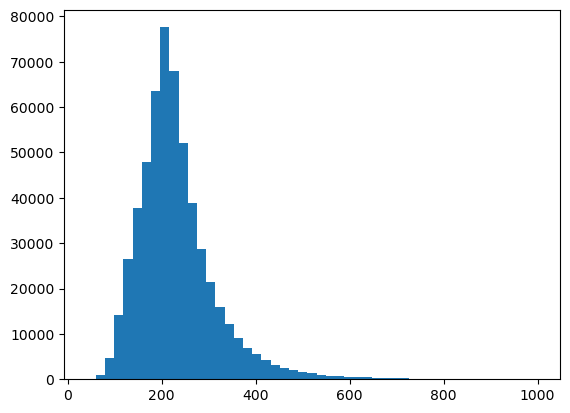

In [54]:
import matplotlib.pyplot as plt

plt.hist(val_gen_pt,bins=np.linspace(40,1000,50))
plt.show()

In [17]:
import matplotlib.pyplot as plt

NameError: name 'herwig_pT' is not defined

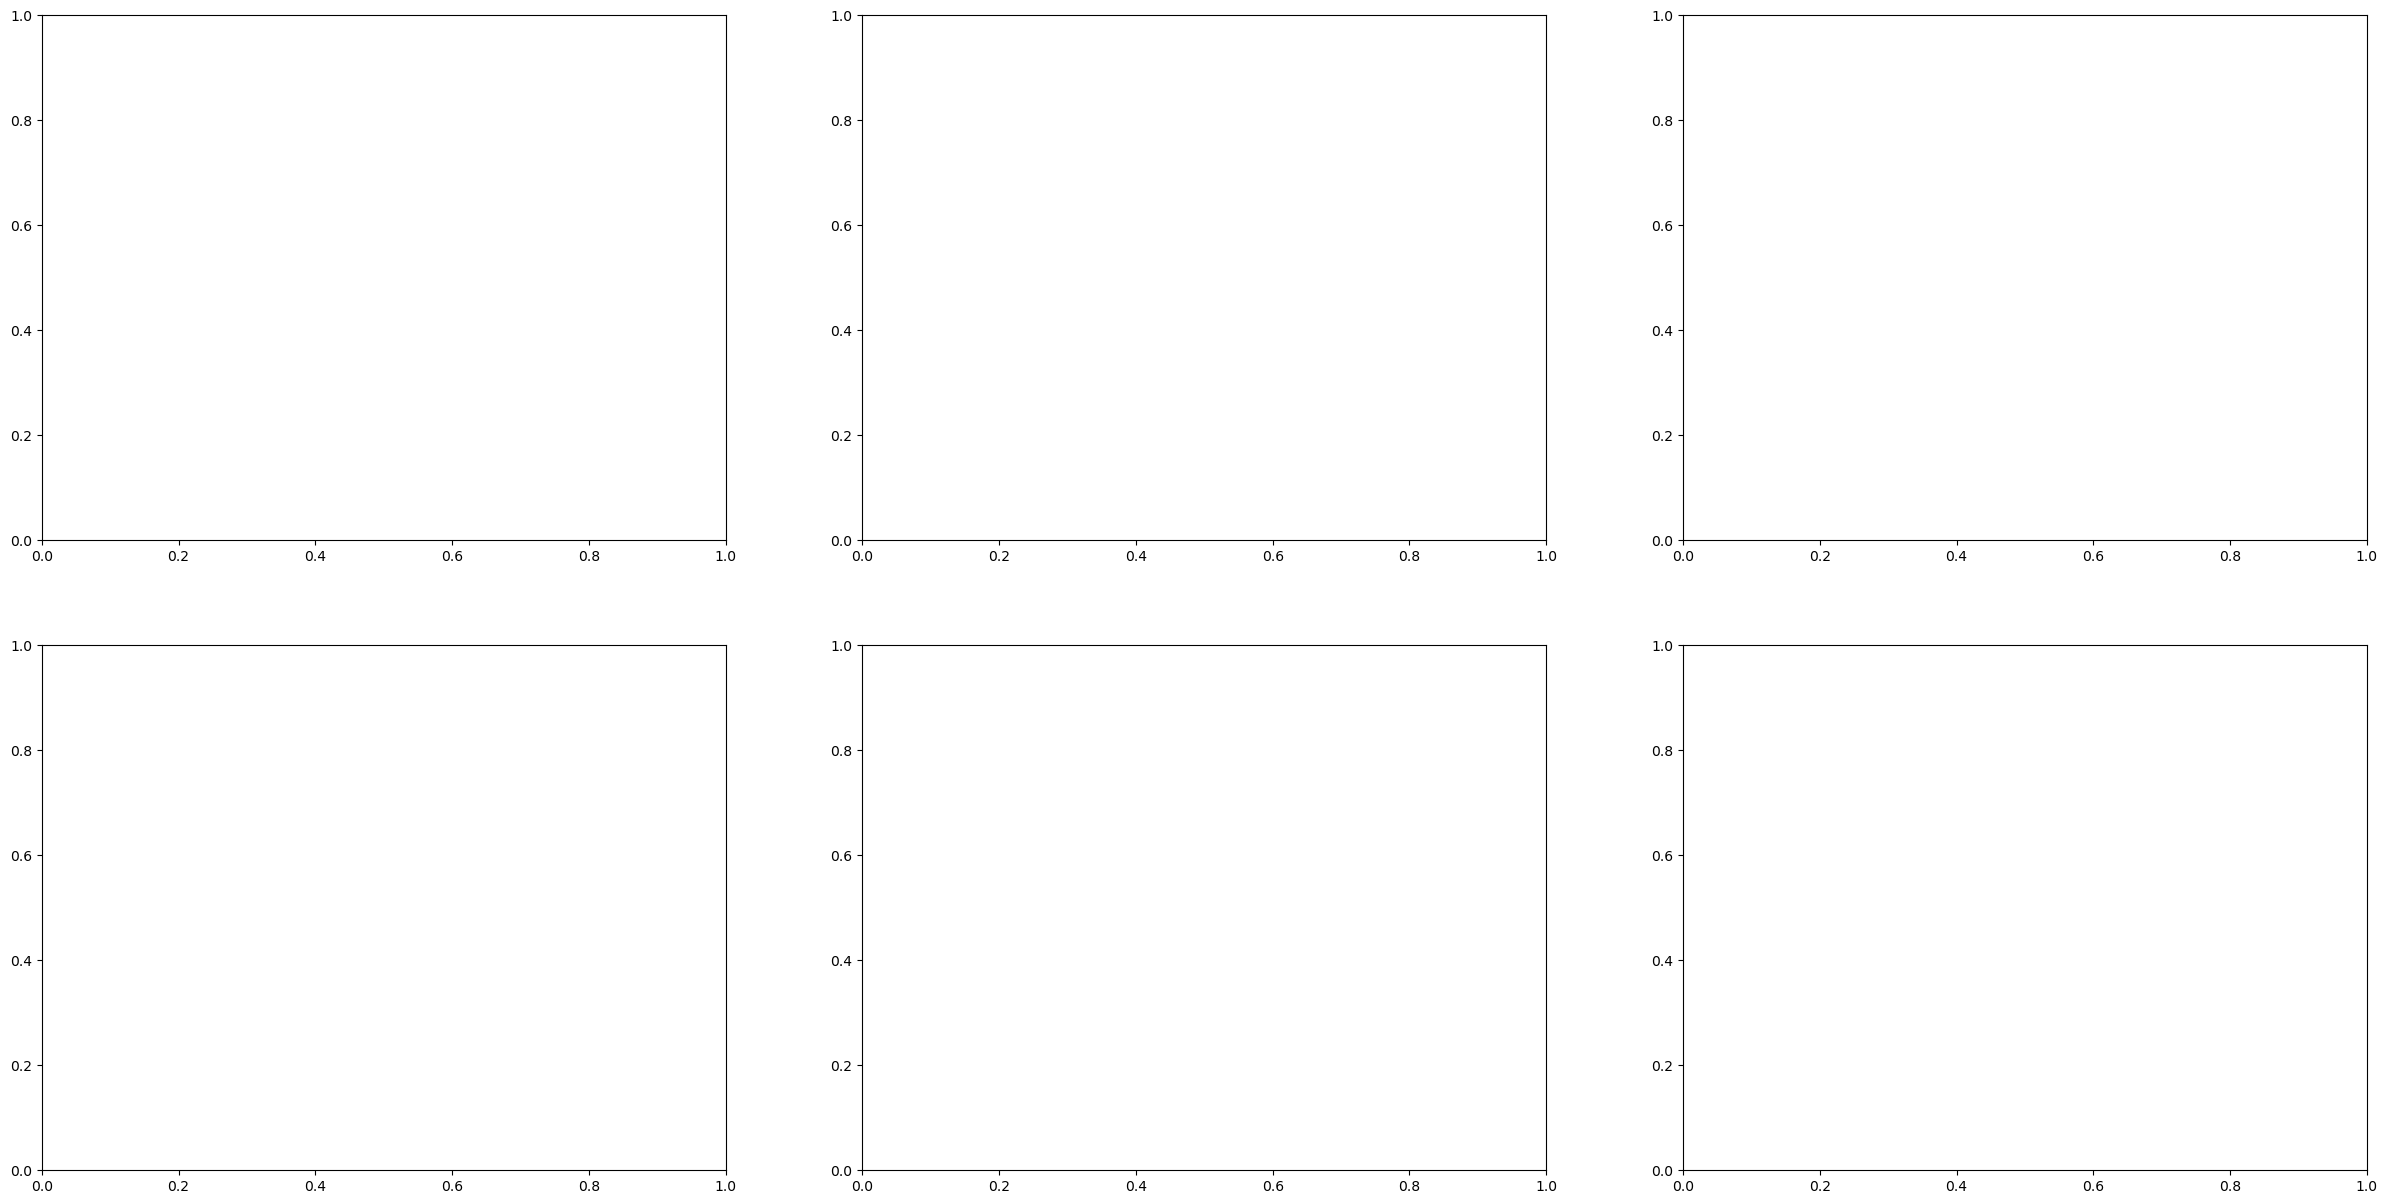

In [18]:
from matplotlib.colors import LogNorm

fig,ax = plt.subplots(2,3,figsize=(30,15))
ax = ax.ravel()
feature_names = np.array([r"$\Delta$ Jet Mass [GeV]",r"$\Delta$ Jet Width", r"$\Delta$ $n_{constituents}$",r"$\Delta$ $ln\rho$",r"$\Delta$ $z_g$",r"$\Delta$ $\tau_{21}$"])
feature_names = feature_names[[0,2,1,5,4,3]]
bins_pt = np.linspace(40,1200,50)
bins_res = np.arange(-6,6,0.12)
for i in range(len(feature_names)):
    #pred = inf_data['Events'][:,i]
    #true = inf_data['Truth'][:,i]
    pred = pred_gen[:,i]
    true = truth_gen[:,i]
    if 'n_{constituents}' in feature_names[i]:
        print('Discrete')
        pred = pred.round()
    pT = herwig_pT#val_gen_pt
    res = (true - pred)/(true + 1e-10)
    
    idx = np.where(abs(res) < 0.25)[0]
    
    print(feature_names[i])
    print(len(idx)/len(res))
    #print(np.mean(res))
    hist = ax[i].hist2d(pT, res, bins=[bins_pt, bins_res], norm=LogNorm())
    ax[i].tick_params(labelsize=24)
    cbar = fig.colorbar(hist[3], ax=ax[i])
    cbar.set_label('Density',fontsize=32)
    if i > 2:
        ax[i].set_xlabel(r"${p_T}$  [GeV/C]",fontsize=38,labelpad=20)
    ax[i].set_ylabel(feature_names[i],fontsize=38)
    cbar.ax.tick_params(labelsize=20)

plt.subplots_adjust(wspace=0.3)
#plt.savefig("Inference/Plots/Residuals_pT.pdf")

$\Delta$ Jet Mass [GeV]
0.1955945389261558
Discrete
$\Delta$ $n_{constituents}$
0.24699738358337742
$\Delta$ Jet Width
0.2192605839619228
$\Delta$ $\tau_{21}$
0.23177032593870905
$\Delta$ $z_g$
0.10976772343919615
$\Delta$ $ln\rho$
0.3086432209758677


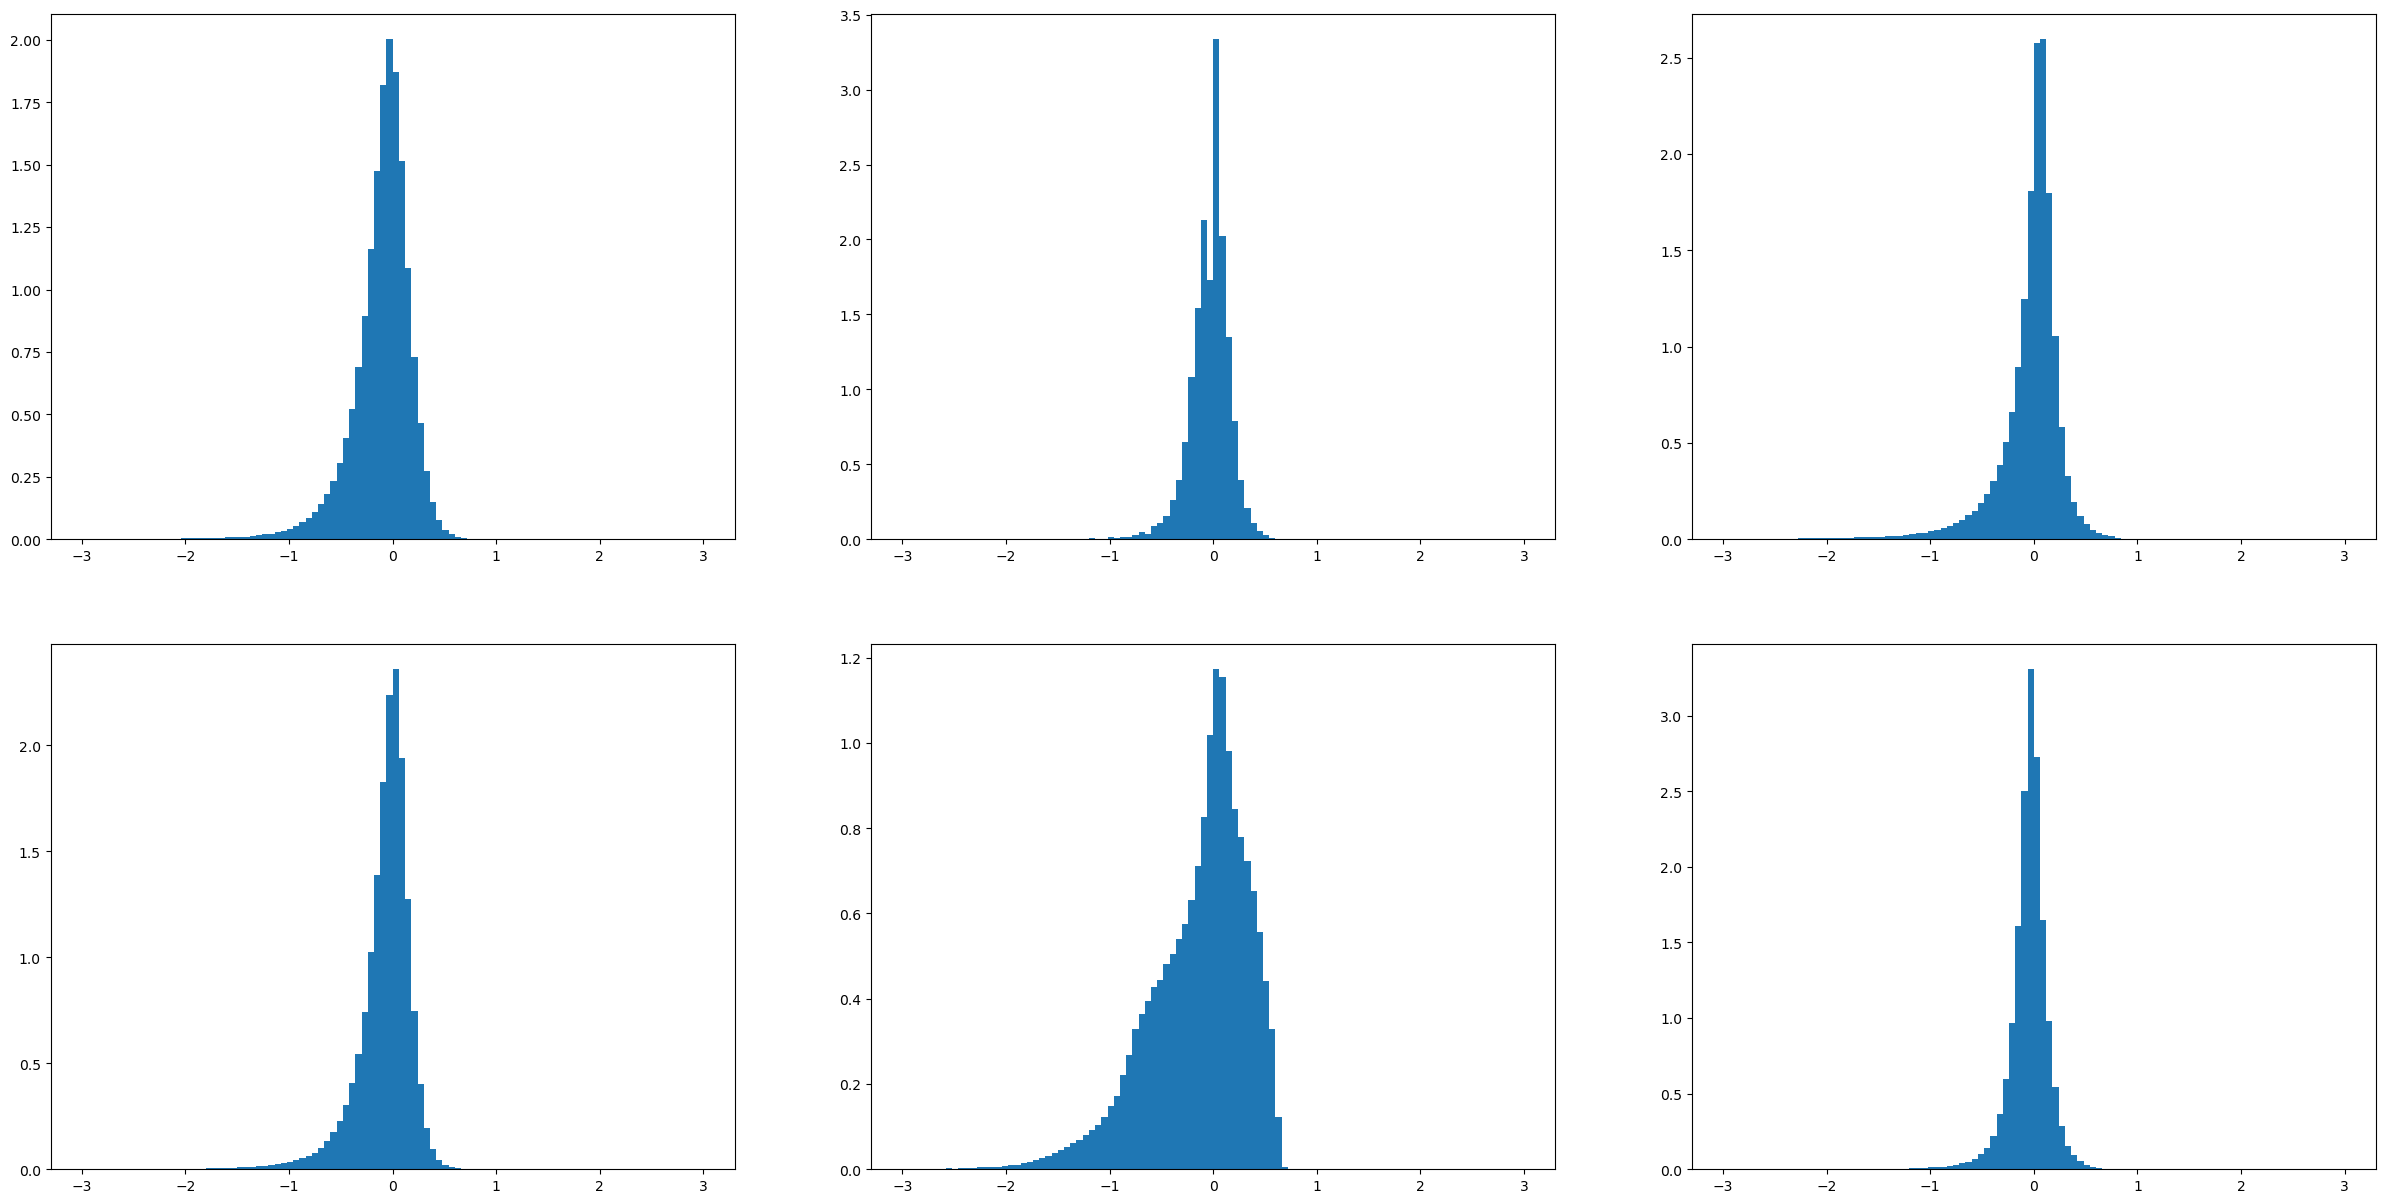

In [18]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

fig,ax = plt.subplots(2,3,figsize=(30,15))
ax = ax.ravel()
feature_names = np.array([r"$\Delta$ Jet Mass [GeV]",r"$\Delta$ Jet Width", r"$\Delta$ $n_{constituents}$",r"$\Delta$ $ln\rho$",r"$\Delta$ $z_g$",r"$\Delta$ $\tau_{21}$"])
feature_names = feature_names[[0,2,1,5,4,3]]
bins_pt = np.linspace(40,1200,50)
bins_res = np.arange(-6,6,0.12)
for i in range(len(feature_names)):
    #pred = inf_data['Events'][:,i]
    #true = inf_data['Truth'][:,i]
    pred = pred_gen[:,i]
    true = truth_gen[:,i]
    if 'n_{constituents}' in feature_names[i]:
        print('Discrete')
        pred = pred.round()
    #pT = herwig_pT#val_gen_pt
    res = (true - pred)/(true + 1e-50)
    ax[i].hist(res,bins=100,density=True,range=[-3,3])
    idx = np.where(abs(res) < 0.05)[0]
    
    print(feature_names[i])
    print(len(idx)/len(res))
#plt.savefig("Inference/Plots/Residuals_pT.pdf")

In [19]:
import numpy as np
from sklearn.manifold import TSNE

inference_data = np.load(r"C:\Users\James-PC\James\EIC\IBU2Q-main\IBU2Q-main\Inference\Inference_Covariance_pythia_unscaled.pkl",allow_pickle=True)


In [130]:
inference_data['Truth'][k]

array([16.44439697, 23.        ,  0.12726148,  0.75853249,  0.38306204,
       -6.97201817])

In [11]:
inference_data['Events'][0].reshape(1,-1)

array([[11.764521  , 12.59519   ,  0.08215506,  0.9511537 ,  0.3325373 ,
        -8.98352   ]], dtype=float32)

In [29]:
tsne.transform(inference_data['Events'][0].reshape(1,-1))

array([[15.680091  ,  4.78821528]])

In [25]:
kbar = pkbar.Kbar(target=len(val_loader),width=20, always_stateful=False)
# This performs sampling for the OT-Flow
samples = 100
mus_reco = []
sigmas = []
truth_reco = []
truth_gen = []
mus_gen = []

net.eval()
start = time.time()
for i,data in enumerate(val_loader):
    reco = data[0]
    gen = data[1]
    truth_reco.append(scaler.inverse_transform(data[0].numpy()))
    truth_gen.append(scaler.inverse_transform(data[1].numpy()))
    
    temp = []
    for j in range(len(reco)):
        temp.append(np.expand_dims(gen[j],0).repeat(samples,0))

    gen = torch.tensor(np.concatenate(temp)).to('cuda').float()

    with torch.no_grad():
        targets,log_det = net.forward(gen,rev=False)

    targets = scaler.inverse_transform(targets.detach().cpu().numpy())
    targets = targets.reshape(-1,samples,reco.shape[1])
    final_mu = np.mean(targets,axis=1)
    mus_reco.append(final_mu)
    final_mu = scaler.transform(final_mu)
    temp = []
    for j in range(len(reco)):
        temp.append(np.expand_dims(final_mu[j],0).repeat(samples,0))
    
    temp = torch.tensor(np.concatenate(temp)).to('cuda').float()
    
    with torch.no_grad():
        targets,_ = net.forward(temp,rev=True)
    
    temp = scaler.inverse_transform(targets.detach().cpu().numpy())
    targets = temp.reshape(-1,samples,reco.shape[1])
    gen_mu = np.mean(targets,axis=1)
    mus_gen.append(gen_mu)
    #sigmas.append([np.cov(targets[i],rowvar=False) for i in range(len(targets))])

#     if i == 50:
#         break
    kbar.update(i)

print(" ")
print(len(mus))
end = time.time()
elapsed_time = end - start
print('Elapsed Time: ',elapsed_time)

mus_reco = np.concatenate(mus_reco)
mus_gen = np.concatenate(mus_gen)
print('Time / event: ',elapsed_time / len(mus))
truth_reco = np.concatenate(truth_reco)
truth_gen = np.concatenate(truth_gen)
# truth = np.concatenate(truth)
# uncertainty = np.concatenate(sigmas)

539/541 [==================>.] - ETA: 1s 
553009
Elapsed Time:  284.96832752227783
Time / event:  0.0005153050448044749


In [32]:
kbar = pkbar.Kbar(target=len(val_loader),width=20, always_stateful=False)
# This performs sampling for the OT-Flow
samples = 100
mus_reco = []
sigmas = []
truth_reco = []
truth_gen = []
mus_gen = []

net.eval()
start = time.time()
for i,data in enumerate(val_loader):
    reco = data[0]
    gen = data[1]
    truth_reco.append(scaler.inverse_transform(data[0].numpy()))
    truth_gen.append(scaler.inverse_transform(data[1].numpy()))
    
    temp = []
    for j in range(len(reco)):
        temp.append(np.expand_dims(reco[j],0).repeat(samples,0))

    temp = torch.tensor(np.concatenate(temp)).to('cuda').float()

    with torch.no_grad():
        targets,log_det = net.forward(temp,rev=True)

    targets = scaler.inverse_transform(targets.detach().cpu().numpy())
    targets = targets.reshape(-1,samples,reco.shape[1])
    final_mu = np.mean(targets,axis=1)
    mus_gen.append(final_mu)
    final_mu = scaler.transform(final_mu)
    temp = []
    for j in range(len(reco)):
        temp.append(np.expand_dims(final_mu[j],0).repeat(samples,0))
    
    temp = torch.tensor(np.concatenate(temp)).to('cuda').float()
    
    with torch.no_grad():
        targets,_ = net.forward(temp,rev=False)
    
    temp = scaler.inverse_transform(targets.detach().cpu().numpy())
    targets = temp.reshape(-1,samples,reco.shape[1])
    mu_reco = np.mean(targets,axis=1)
    mus_reco.append(mu_reco)
    #sigmas.append([np.cov(targets[i],rowvar=False) for i in range(len(targets))])

#     if i == 50:
#         break
    kbar.update(i)

print(" ")
print(len(mus))
end = time.time()
elapsed_time = end - start
print('Elapsed Time: ',elapsed_time)

mus_reco = np.concatenate(mus_reco)
mus_gen = np.concatenate(mus_gen)
print('Time / event: ',elapsed_time / len(mus))
truth_reco = np.concatenate(truth_reco)
truth_gen = np.concatenate(truth_gen)
# truth = np.concatenate(truth)
# uncertainty = np.concatenate(sigmas)

539/541 [==================>.] - ETA: 1s 
553009
Elapsed Time:  284.43079566955566
Time / event:  0.000514333031957085


In [49]:
a = (mus_gen - truth_gen) / (truth_gen + 1e-50)

In [44]:
inference_data['Events']

NameError: name 'inference_data' is not defined

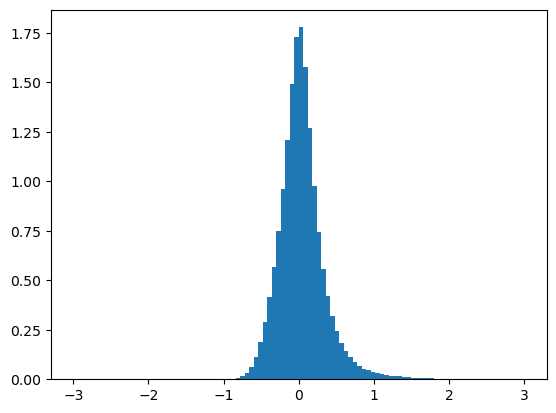

In [53]:
import matplotlib.pyplot as plt
plt.hist(a[:,0],bins=100,range=[-3,3],density=True)
plt.show()

In [36]:
a = (mus_reco - truth_reco) / (truth_reco + 1e-50)

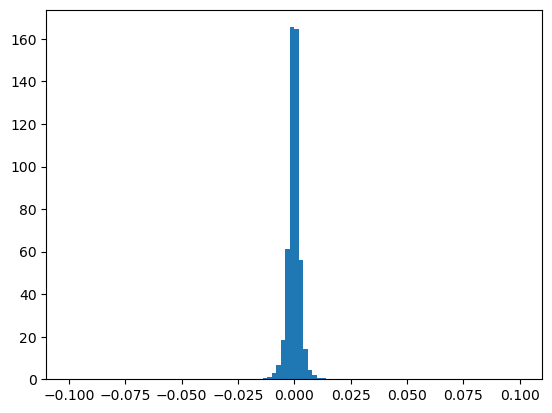

In [42]:
import matplotlib.pyplot as plt
plt.hist(a[:,5],bins=100,range=[-0.1,0.1],density=True)
plt.show()

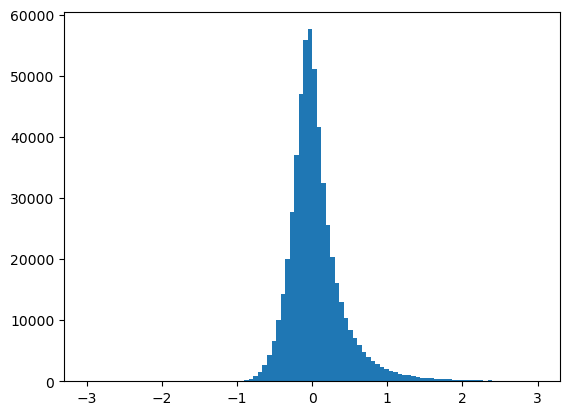

In [48]:
a = (inference_data['Events'][:,0] - inference_data['Truth'][:,0])/ (inference_data['Truth'][:,0] + 1e-50)
plt.hist(a,bins=100,range=(-3,3))
plt.show()

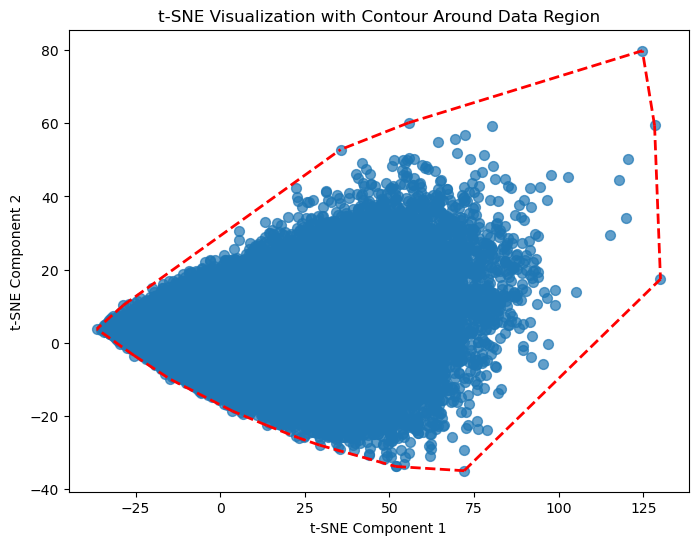

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
# Load your data or use a sample dataset like Iris for demonstration
#data = load_iris()
X = inference_data['Truth']
#y = data.target

# Perform t-SNE
#tsne = TSNE(n_components=2, random_state=42)
tsne = PCA(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot t-SNE embeddings
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], cmap='viridis', s=50, alpha=0.7)

# Find convex hull around the data points
hull = ConvexHull(X_tsne)

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(X_tsne[simplex, 0], X_tsne[simplex, 1], 'r--', lw=2)

plt.title('t-SNE Visualization with Contour Around Data Region')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
#plt.colorbar(label='Classes')
plt.show()


In [165]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming 'data1' and 'data2' are your two datasets as NumPy arrays
# Each row represents a vector
loss_fn = nn.SmoothL1Loss(reduction='mean')
similar_points = []
indices = []
losses = []
k = 1000
for i in range(1,len(inference_data['Truth'])):
    ratio = (inference_data['Events'][i] - inference_data['Truth'][k]) / (inference_data['Events'][k])
    if (np.sum(abs(ratio)) / 6.0 < 0.05) & (i != k):
        indices.append(i)
        #losses.append(loss_fn(torch.tensor(inference_data['Events'][k]),torch.tensor(inference_data['Truth'][i])))
        #print(gen_features[i])


print(len(indices))

49


In [168]:
inference_data['Events'][k]

array([18.887295  , 21.123726  ,  0.0404387 ,  0.7973516 ,  0.12305051,
       -8.288457  ], dtype=float32)

In [166]:
inference_data['Truth'][k]

array([16.03955269, 23.        ,  0.04802893,  0.83371462,  0.13566902,
       -8.9832756 ])

In [167]:
inference_data['Events'][indices]

array([[16.023788  , 22.940174  ,  0.04792783,  0.82889706,  0.11725888,
        -9.300572  ],
       [16.515747  , 24.076561  ,  0.04818766,  0.87148577,  0.12091969,
        -8.755908  ],
       [15.665568  , 20.078646  ,  0.04729766,  0.8865834 ,  0.134986  ,
        -9.046457  ],
       [16.192387  , 21.389322  ,  0.04529547,  0.81053513,  0.13245024,
        -8.699761  ],
       [16.25947   , 24.150858  ,  0.04670181,  0.8709174 ,  0.11978988,
        -8.890597  ],
       [16.286295  , 21.360193  ,  0.04800441,  0.7846835 ,  0.13018435,
        -8.667149  ],
       [15.749008  , 21.774353  ,  0.04986837,  0.8271657 ,  0.14061809,
        -9.849999  ],
       [17.586199  , 21.402342  ,  0.04724777,  0.86230177,  0.13583675,
        -8.944268  ],
       [15.886803  , 22.86112   ,  0.04500608,  0.8687778 ,  0.14714843,
        -9.2372875 ],
       [15.4232645 , 22.602839  ,  0.04973475,  0.8574768 ,  0.13892974,
        -8.7209835 ],
       [19.267027  , 22.830103  ,  0.04913804,  0.

In [72]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming 'data1' and 'data2' are your two datasets as NumPy arrays
# Each row represents a vector
similar_points = []
indices = []
k = 10000
for i in range(len(sim_features)):
    ratio = (sim_features[i] - sim_features[k]) / (sim_features[k] + 1e-50)
    if (np.sum(abs(ratio)) / 6.0 < 0.025) & (i != k):
        indices.append(i)
        #print(gen_features[i])


print(len(indices))

4


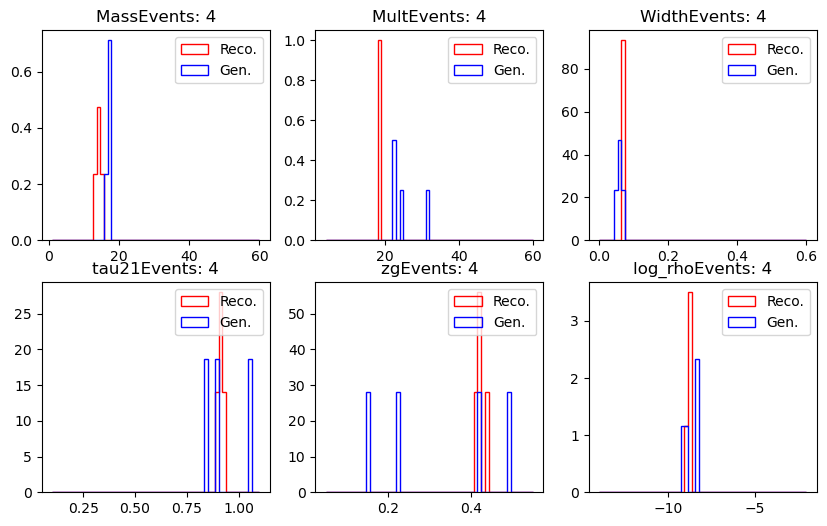

In [75]:
import matplotlib.pyplot as plt
nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]
fig,ax = plt.subplots(2,3,figsize=(10,6))
ax = ax.ravel()

for idx in range(6):
    binning = dict(binning)
    cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
    key = cols[idx]
    bins = binning[key]
    ax[idx].hist(sim_features[indices,idx],bins=bins,histtype='step',color='red',density=True,label='Reco.')
    ax[idx].hist(gen_features[indices,idx],bins=bins,histtype='step',color='blue',density=True,label='Gen.')
    ax[idx].set_title(key + "Events: {0}".format(len(indices)))
    ax[idx].legend()

plt.show()

In [76]:
gen_features[indices]

array([[17.70126152, 24.        ,  0.06526669,  0.84412438,  0.49363512,
        -8.31355858],
       [17.07183647, 31.        ,  0.06381868,  1.1158233 ,  0.14854994,
        -8.9573212 ],
       [16.75831795, 22.        ,  0.05101078,  1.06156326,  0.22190765,
        -9.22985559],
       [16.95745659, 22.        ,  0.06147232,  0.8918751 ,  0.41940246,
        -8.35451703]])

In [77]:
sim_features[indices]

array([[14.74796391, 18.        ,  0.07361269,  0.93458621,  0.43620779,
        -8.83652789],
       [14.11310959, 18.        ,  0.06870867,  0.90724341,  0.41320797,
        -9.02499405],
       [13.25241375, 18.        ,  0.070033  ,  0.90775217,  0.4164312 ,
        -8.69503167],
       [14.37699223, 18.        ,  0.06546399,  0.8978679 ,  0.41769506,
        -8.72244789]])

0.055403863118526755
0.15753906405274076


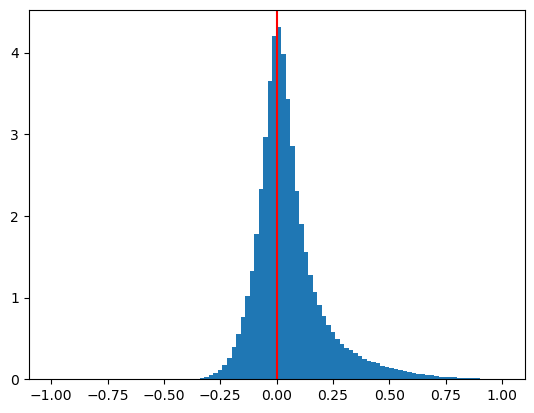

In [178]:
x = np.average((inference_data['Events'] - inference_data['Truth'])/(inference_data['Truth'] + 1e-50),axis=1)
print(x[np.where((x > -1) & (x < 1))].mean())
print(x[np.where((x > -1) & (x < 1))].std())
plt.hist(x[np.where((x > -1) & (x < 1))],bins=100,density=True,range=[-1,1])
plt.axvline(x=0.0,color='red')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0. 0. 0. 0. 0. 0.]


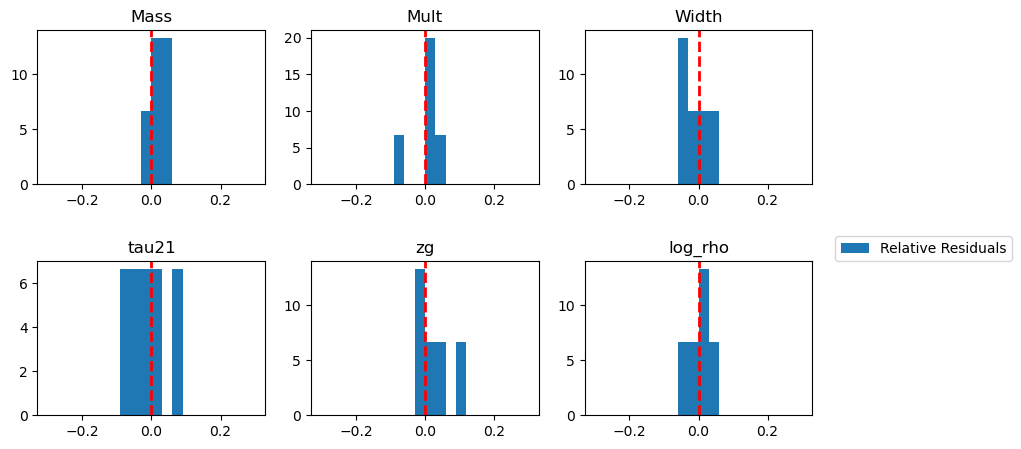

In [155]:
fig,ax = plt.subplots(2,3,figsize=(10,5))
ax = ax.ravel()
plt.subplots_adjust(hspace=0.5)
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
print(gen_herwig[k] - inference_data['Truth'][k])
for i in range(len(inference_data['Truth'][0])):
    key = cols[i]
    bins = 20#binning[key]
    
    true_gen = gen_herwig[k][i]
    predicted_mean = inference_data['Events'][k][i]
    other_gen = gen_herwig[indices][:,i]
    
    res = (other_gen - true_gen)/(true_gen + 1e-50)
    
    #ax[i].hist(true_sim,bins=bins,density=True,color='red',label='True Sim.')
    #ax[i].hist(true_gen,bins=bins,density=True,color='blue',label='True Gen.')
    ax[i].axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax[i].hist(res,bins=20,density=True,label='Relative Residuals',range=[-0.3,0.3])
    ax[2].legend(loc=(1.1,-0.5))
    ax[i].set_title(key)

    
    

In [82]:
nbins = 57 # Make Jet Multiplicity an Integer
binning = [
    ('Mass',np.linspace(1,60,nbins)), # Mass
    ('Width',np.linspace(0,0.6,nbins)), # Width
    ('Mult',np.linspace(4,60,nbins)), # Multi
    ('log_rho',np.linspace(-14,-2,nbins)), # lnp
    ('zg',np.linspace(0.05,0.55,nbins)), # Zg
    ('tau21',np.linspace(0.1,1.1,nbins)), # Tau21
]

binning = dict(binning)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 3.11546326 -3.         -0.04208287 -0.03458004 -0.02654659 -1.83905694]


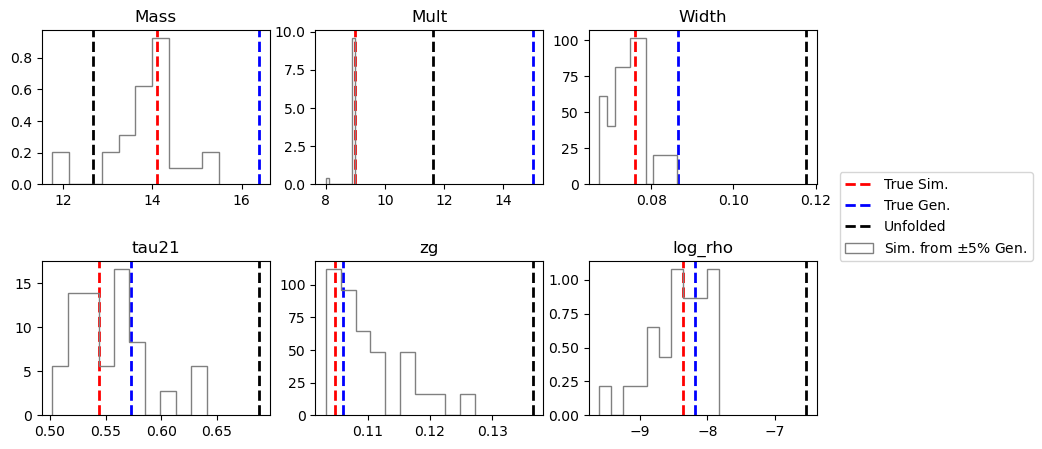

In [20]:
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt 

def getKernelDensityEstimation(values, x, bandwidth = 0.2, kernel = 'gaussian'):
    model = KernelDensity(kernel = kernel, bandwidth=bandwidth)
    model.fit(values[:, np.newaxis])
    log_density = model.score_samples(x[:, np.newaxis])
    return np.exp(log_density)

fig,ax = plt.subplots(2,3,figsize=(10,5))
ax = ax.ravel()
plt.subplots_adjust(hspace=0.5)
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
print(sim_features[k] - inference_data['Truth'][k])
for i in range(len(inference_data['Truth'][0])):
    key = cols[i]
    bins = 10#binning[key]
    
    true_sim = sim_features[k][i]
    true_gen = gen_features[k][i]
    other = sim_features[indices][:,i]
    predicted_mean = inference_data['Events'][k][i]
    x = np.linspace(other.min(),other.max(), other.shape[0])
    if i < 2:
        bwidth=.70
    else:
        bwidth = 0.05
    kde = getKernelDensityEstimation(other,x,bandwidth=bwidth)
    
    #ax[i].hist(true_sim,bins=bins,density=True,color='red',label='True Sim.')
    #ax[i].hist(true_gen,bins=bins,density=True,color='blue',label='True Gen.')
    #ax[i].plot(x,kde,alpha=0.8,label='KDE')
    ax[i].axvline(x=true_sim, color='red', linestyle='--', linewidth=2, label='True Sim.')
    ax[i].axvline(x=true_gen, color='blue', linestyle='--', linewidth=2, label='True Gen.')
    ax[i].axvline(x=predicted_mean, color='k', linestyle='--', linewidth=2, label='Unfolded')
    ax[i].hist(other,bins=bins,density=True,color='grey',histtype='step',label=r'Sim. from $\pm 5\%$ Gen.')
    ax[2].legend(loc=(1.1,-0.5))
    ax[i].set_title(key)

    
    

In [67]:
loss_fn(torch.tensor(inference_data['Events'][k]),torch.tensor(inference_data['Truth'][k]))

tensor(0.6610, dtype=torch.float64)

In [47]:
inference_data['Truth'][k]

array([16.03955269, 23.        ,  0.04802893,  0.83371462,  0.13566902,
       -8.9832756 ])

In [44]:
inference_data['Truth'][indices]

array([[16.03577614, 23.        ,  0.04993623,  0.80138227,  0.13597943,
        -9.08274114]])

In [45]:
inference_data['Events'][indices]

array([[14.17303   , 23.1501    ,  0.0403336 ,  0.8039968 ,  0.14780268,
        -9.340621  ]], dtype=float32)

In [48]:
inference_data['Events'][k]

array([18.887295  , 21.123726  ,  0.0404387 ,  0.7973516 ,  0.12305051,
       -8.288457  ], dtype=float32)

76


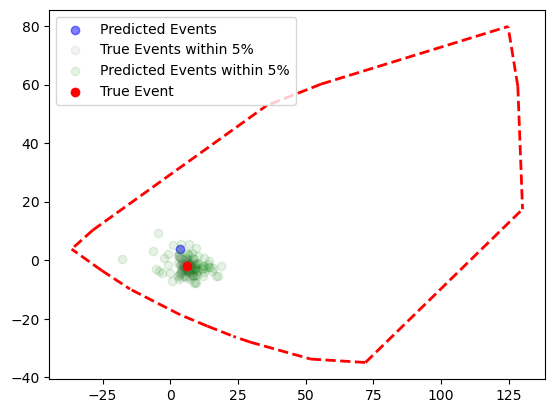

In [181]:
# Assuming 'data1' and 'data2' are your two datasets as NumPy arrays
# Each row represents a vector
similar_points = []
indices = []
k = 100
for i in range(1,len(inference_data['Truth'])):
    ratio = (inference_data['Truth'][i] - inference_data['Truth'][k]) / (inference_data['Truth'][k])
    if (np.sum(abs(ratio)) / 6.0 < 0.05) & (i != k):
        indices.append(i)
        #print(gen_features[i])


print(len(indices))
if len(indices) > 0:
    idx = k
    x_truth = tsne.transform(inference_data['Truth'][idx].reshape(1,-1))[0]
    mu = inference_data['Events'][idx]
    x_cov = inference_data['Covariance'][idx]
    x_pred = np.random.multivariate_normal(mu,x_cov,size=1000)
    x_pred = tsne.transform(mu.reshape(1,-1))
    other_events= tsne.transform(inference_data['Truth'][indices])
    pred_other_events = tsne.transform(inference_data['Events'][indices])
    plt.scatter(x_pred[:,0],x_pred[:,0],color='blue',alpha=0.5,label='Predicted Events')
    plt.scatter(other_events[:,0],other_events[:,1],color='grey',alpha=0.1,label='True Events within 5%')
    plt.scatter(pred_other_events[:,0],pred_other_events[:,1],color='green',alpha=0.1,label='Predicted Events within 5%')
    plt.scatter(x_truth[0],x_truth[1],color='red',alpha=1.0,label='True Event')
    plt.legend()
    for simplex in hull.simplices:
        plt.plot(X_tsne[simplex, 0], X_tsne[simplex, 1], 'r--', lw=2)

In [21]:
inference_data = np.load('Inference/Inference_Covariance.pkl',allow_pickle=True)

In [27]:
ratio = np.average(abs((inference_data['Events'][0] - inference_data['Truth'])/(inference_data['Truth'] + 1e-50)),axis=1)
np.where(ratio < 0.05)

(array([     0,  21107,  26953, 104687, 111371, 142854, 159781, 164883,
        181053, 280338, 319787, 354880, 362517, 378560, 405776, 405813,
        417257, 442138, 469587, 492689, 504066, 507015, 559588],
       dtype=int64),)

In [27]:
gen_features = gen_features[N_t:]
sim_features = sim_features[N_t:]

In [29]:
import numpy as np

indices = []
matched_gen = []
matched_sim = []
maxs_ = []
for i in range(len(inference_data['Truth'])):
    if i % 1000 == 0:
        print(i)
    ratio = np.average(abs((gen_features[i] - gen_features)/(gen_features + 1e-50)),axis=1)
    idx = np.where(ratio < 0.025)[0]
    indices.append(idx)
    if ratio[idx].max() > 0.025:
        print('Bad')
    matched_gen.append(gen_features[idx])
    matched_sim.append(sim_features[idx])
    maxs_.append(len(idx))
    if len(idx) == 0:
        bad_events.append(i)
        #print(gen_features[i])
        
    if i == 1000:
        break

0
1000


In [30]:
np.array(maxs_).max()

10

In [43]:
import scipy.stats as st

st.poisson.rvs(mu=)

array([ 6,  8,  6,  5, 10,  8, 15,  9,  8, 13])

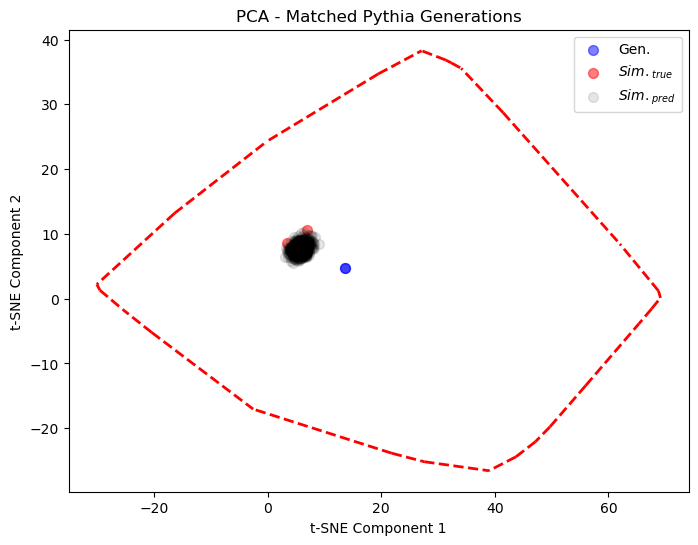

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
# Load your data or use a sample dataset like Iris for demonstration
#data = load_iris()
#X = np.concatenate(matched_gen)[0]
k = 100
X = matched_gen[k]
#y = data.target

# Perform t-SNE
#tsne = TSNE(n_components=2, random_state=42)
tsne = PCA(n_components=2, random_state=42)
X_t = tsne.fit_transform(gen_features)
X_tsne = tsne.transform(matched_gen[k])
X_p = tsne.transform(matched_sim[k])
a = np.random.multivariate_normal(inference_data['Events'][indices[k][0]],inference_data['Covariance'][indices[k][0]],size=1000)
X_ppp = tsne.transform(a)

# print((inference_data['Events'][k] - matched_sim[k])/(matched_sim[k] + 1e-50))
# print((inference_data['Truth'][k] - matched_sim[k][0])/(matched_sim[k][0] + 1e-50))
# print(matched_gen[k] - gen_features[k])

# Plot t-SNE embeddings
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], cmap='viridis', s=50, alpha=0.5,color='blue',label='Gen.')
plt.scatter(X_p[:, 0], X_p[:, 1], cmap='viridis', s=50, alpha=0.5,color='red',label=r'$Sim._{true}$')
plt.scatter(X_ppp[:,0], X_ppp[:,1],s=50,alpha=0.1,color='k',label=r'$Sim._{pred}$')
# Find convex hull around the data points
hull = ConvexHull(X_t)

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(X_t[simplex, 0], X_t[simplex, 1], 'r--', lw=2)

plt.title('PCA - Matched Pythia Generations')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
#plt.colorbar(label='Classes')
plt.legend()
plt.show()


In [180]:
import sklearn
sklearn.cluster.DBSCAN

sklearn.cluster._dbscan.DBSCAN

In [22]:
X

array([[ 7.96271801, 10.        ,  0.07060276,  0.73218447,  0.29621524,
        -7.06061815],
       [19.74843025, 20.70722389,  0.14771007,  0.78269565,  0.2599608 ,
        -6.57264757],
       [ 6.81138325,  7.        ,  0.09788019,  0.25261305,  0.29953174,
        -6.5291346 ]])

In [24]:
len(indices)

1001

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
k = 42
# Concatenate the datasets and assign labels
X = np.concatenate([matched_gen[k], inference_data['Events'][indices[k]], matched_sim[k]], axis=0)
# Assign labels (0 for matched_gen, 1 for inference_data, 2 for matched_sim)
labels = np.concatenate([np.zeros(len(matched_gen[k])), np.ones(len(inference_data['Events'][indices[k]])), np.full(len(matched_sim[k]), 2)])

# Perform t-SNE
tsne = TSNE(n_components=2)
X_t = tsne.fit_transform(X)

# Plot t-SNE embeddings with different colors for each dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_t[labels == 0, 0], X_t[labels == 0, 1], s=50, alpha=0.5, color='blue', label='Gen.')
plt.scatter(X_t[labels == 1, 0], X_t[labels == 1, 1], s=50, alpha=0.5, color='red', label=r'$Sim._{true}$')
plt.scatter(X_t[labels == 2, 0], X_t[labels == 2, 1], s=50, alpha=0.5, color='green', label=r'$Sim._{pred}$')

# Find convex hull around the data points
hull = ConvexHull(X_t)

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(X_t[simplex, 0], X_t[simplex, 1], 'r--', lw=2)

plt.title('t-SNE - Matched Pythia Generations')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

IndexError: index 1084220 is out of bounds for axis 0 with size 553009

In [91]:
import numpy as np

indices = []
bad_events = []
for i in range(len(inference_data['Truth'])):
    if i % 1000 == 0:
        print(i)
    ratio = np.average(abs((inference_data['Events'][i] - inference_data['Truth'])/(inference_data['Truth'] + 1e-50)),axis=1)
    idx = np.where(ratio < 0.05)[0]
    indices.append(idx)
    if len(idx) == 0:
        bad_events.append(i)
        #print(gen_features[i])
        
    if i == 10000:
        break

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [86]:
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt 

def getKernelDensityEstimation(values, x, bandwidth = 0.2, kernel = 'gaussian'):
    model = KernelDensity(kernel = kernel, bandwidth=bandwidth)
    model.fit(values[:, np.newaxis])
    log_density = model.score_samples(x[:, np.newaxis])
    return np.exp(log_density)

fig,ax = plt.subplots(2,3,figsize=(10,5))
ax = ax.ravel()
plt.subplots_adjust(hspace=0.5)
cols = np.array(["Mass","Width", "Mult","log_rho","zg","tau21"])[[0,2,1,5,4,3]]
print(sim_features[k] - inference_data['Truth'][k])
for i in range(len(inference_data['Truth'][0])):
    key = cols[i]
    bins = 10#binning[key]
    
    true_sim = inference_data[k][i]
    true_gen = gen_features[k][i]
    other = sim_features[indices][:,i]
    predicted_mean = inference_data['Events'][k][i]
    x = np.linspace(other.min(),other.max(), other.shape[0])
    if i < 2:
        bwidth=.70
    else:
        bwidth = 0.05
    kde = getKernelDensityEstimation(other,x,bandwidth=bwidth)
    
    #ax[i].hist(true_sim,bins=bins,density=True,color='red',label='True Sim.')
    #ax[i].hist(true_gen,bins=bins,density=True,color='blue',label='True Gen.')
    #ax[i].plot(x,kde,alpha=0.8,label='KDE')
    ax[i].axvline(x=true_sim, color='red', linestyle='--', linewidth=2, label='True Sim.')
    ax[i].axvline(x=true_gen, color='blue', linestyle='--', linewidth=2, label='True Gen.')
    ax[i].axvline(x=predicted_mean, color='k', linestyle='--', linewidth=2, label='Unfolded')
    ax[i].hist(other,bins=bins,density=True,color='grey',histtype='step',label=r'Sim. from $\pm 5\%$ Gen.')
    ax[2].legend(loc=(1.1,-0.5))
    ax[i].set_title(key)

    
    

0.049729415309556046

In [92]:
np.average(abs((inference_data['Events'][0] - inference_data['Truth'][indices[0]])/inference_data['Truth'][indices[0]]),axis=1)

array([0.0325674 , 0.04521414, 0.0341102 , 0.04711679, 0.04592333,
       0.02967621, 0.04903992, 0.04381338, 0.0457863 , 0.03495788,
       0.04947585, 0.04896902, 0.04593649, 0.04922465, 0.03465285,
       0.04345392, 0.04861465, 0.01749006, 0.04733534, 0.04821134,
       0.031389  , 0.0469363 , 0.04073074])

In [80]:
ratio

array([0.27379863, 0.7837686 , 1.00509788, ..., 0.76913064, 0.40874168,
       0.33509415])

In [75]:
abs((inference_data['Events'][indices[0]][0] - inference_data['Truth'][0])/inference_data['Truth'][0]).sum() / 6

0.03256739520854285

In [56]:
ratio.min()

0.018866037332933492

In [48]:
inference_data['Events'][indices[0]].max(0)

array([70.58316   , 54.52282   ,  0.46359283,  0.40748882,  0.4055573 ,
       -3.2710183 ], dtype=float32)

In [2]:
import energyflow as ef
import numpy as np

cache_dir="/global/cfs/cdirs/m3929/I2SB/"
pythia26 =  ef.zjets_delphes.load("Pythia26",
                                                   cache_dir=cache_dir,exclude_keys=['particles'])

In [16]:
(pythia26['gen_jets'] / np.array([100,1,1,10])).mean(0)

array([ 2.33524790e+00, -2.11989599e-04,  3.14448236e+00,  2.06362918e+00])

In [11]:
X = pythia26['gen_jets'] / np.array([100,1,1,10])

ValueError: operands could not be broadcast together with shapes (100000,4) (3,) 

In [37]:
gen_jets = pythia26['gen_jets']
sim_jets = pythia26['sim_jets']

In [62]:
idx = np.where(np.sum(abs((gen_jets - gen_jets[0])/(gen_jets[0] + 1e-10)),axis=1) <  0.1)[0]

In [75]:
np.unique(gen_jets,axis=1)

(100000, 4)

In [78]:
np.random.seed(8)
rho = 0.8
A = np.random.normal(0,2,size=(2,2))
X = np.matmul(pythia26['gen_jets'][:,[0,3]],A)
Y = rho * X + np.sqrt(1 - rho**2)*X + np.random.normal(size=X.shape)

In [100]:
class EightGaussiansDataset():
    '''Adapted from https://github.com/rtqichen/ffjord/blob/master/lib/toy_data.py'''
    def _create_data(self,num_points):
        scale = 10.
        bias = np.pi / 8
        step = np.pi / 4
        centers = [(np.cos(bias + 0*step), np.sin(bias + 0*step)),
                   (np.cos(bias + 1*step), np.sin(bias + 1*step)),
                   (np.cos(bias + 2*step), np.sin(bias + 2*step)),
                   (np.cos(bias + 3*step), np.sin(bias + 3*step)),
                   (np.cos(bias + 4*step), np.sin(bias + 4*step)),
                   (np.cos(bias + 5*step), np.sin(bias + 5*step)),
                   (np.cos(bias + 6*step), np.sin(bias + 6*step)),
                   (np.cos(bias + 7*step), np.sin(bias + 7*step))]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        for i in range(num_points):
            point = np.random.randn(2) * 0.5
            idx = np.random.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype="float32")
        dataset /= 1.414
        return dataset

In [107]:
np.random.seed(8)
Gaussians = EightGaussiansDataset()
generations = Gaussians._create_data(10000)

rho = 0.8
A = np.random.normal(0,2,size=(2,2))
X = np.matmul(dataset,A)
simulation = rho * X + np.sqrt(1 - rho**2)*X + np.random.normal(size=X.shape)

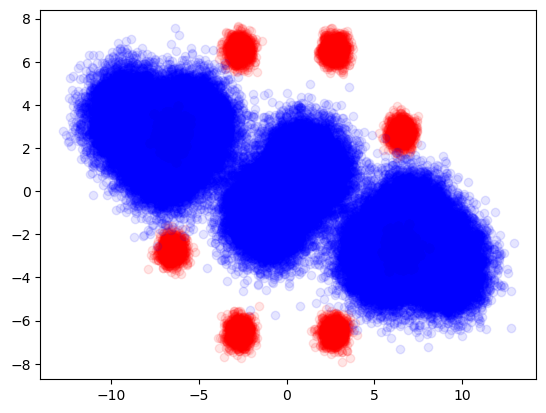

In [111]:
plt.scatter(generations[:,0],generations[:,1],alpha=0.1,color='red',label='Gen.')
plt.scatter(simulation[:,0],simulation[:,1],alpha=0.1,color='blue',label='Reco.')